<a href="https://colab.research.google.com/github/sahana248/brain_tumour_MRI/blob/main/Brain_tumour_class_SahanaM_21076516.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Comparative Analysis of deep learning models for MRI- Based brain tumour Classification.**


In this project, we aim to develop and evaluate deep learning models, including Graph Convolutional Networks (GCN) and Generative Adversarial Networks (GAN), for brain tumour classification using MRI images. Our approach involves training and fine-tuning these custom models on a labelled dataset of brain MRI scans. We will then compare their performance with pretrained models such as VGG19 and ResNet50. Evaluation metrics, including accuracy, precision, recall, F1-score, and ROC-AUC, will guide us in determining the effectiveness of each model.

# Background
This study explores the effectiveness of deep learning techniques on MRI images for the accurate classification of brain tumours. Brain tumours present major diagnostic challenges that require fast and accurate classification methods. The traditional manual examinations conducted by radiologists are labour-intensive and error-prone, which emphasizes the requirement for automated treatments.
This project will specifically discuss the pre-trained models, including VGG19 and ResNet50, and the traditional models, such as Graph Convolutional Networks (GCN) and Generative Adversarial Networks (GAN). While traditional models have the advantage of some features, including higher potential to enhance training outcomes and correlation analysis, on the other hand, pre-trained models benefit from extended training on huge datasets and intricate architectures. The research aims to find the most successful model, determining these models through the use of criteria like accuracy, precision, recall, F1-score, and ROC-AUC, which will enable the accurate and efficient categorization of more brain tumours in medical imaging.


# Dataset
The data was collected from Kaggle and the link to the dataset is:
https://www.kaggle.com/datasets/masoudnickparvar/brain-tumour-mri-dataset/data.

This data was available in Kaggle. It was created by an author named Msoud Nickparvar. The data was originally sourced from three different websites:
Source 1: https://figshare.com/articles/dataset/brain_tumour_dataset/1512427 - this contains 3064 T1-weighted contrast-enhanced images from 233 patients with three kinds of brain tumour.

Source 2: https://www.kaggle.com/sartajbhuvaji/brain-tumour-classification-mri/metadata - it contains of 3264 images split into training and test data. The dataset consists of images of three different types of brain tumour.

Source 3: https://www.kaggle.com/datasets/ahmedhamada0/brain-tumour-detection/metadata - here there are 3865 images and the images are labelled as yes or no based on whether tumour is present or not.

This brain tumour MRI image dataset contains 7022 .jpg files categorized into glioma, meningioma, pituitary, and no tumour, divided into training and test sets. Sourced from three different sources, the dataset totals 156MB of memory space.

The dataset was ethically sourced and meets the requirements of GDPR and UH ethical policy. It is licensed under CC0 (Public Domain) and MIT licenses, ensuring broad usability while adhering to ethical and legal standards for data usage. These licenses permit free use, distribution, and modification of the dataset, facilitating its application in research, development, and educational projects while ensuring ethical compliance.

# Importing libraries

In [ ]:
pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.8 MB/s eta 0:00:00


In [ ]:
pip install spektral

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 10.4 MB/s eta 0:00:00


In [ ]:
import zipfile
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import numpy as np
import seaborn as sns
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import networkx as nx
from torchvision import datasets, transforms
from sklearn.neighbors import kneighbors_graph
from scipy.sparse import csr_matrix
from spektral.data import Dataset, Graph
from spektral.data.loaders import SingleLoader
from tensorflow.keras import layers, Sequential, Model, Input
from tensorflow.keras.layers import LeakyReLU, Reshape, Conv2DTranspose, Conv2D
from tqdm import tqdm

# Extracting the dataset
The dataset has been uploaded as a zip file in the google drive. We first need to mount the drive and unzip the file.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_file_path = '/content/drive/MyDrive/archieve.zip'
extraction_dir = '/content/drive/MyDrive/brain_tumour'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_dir)

In [ ]:
# List the contents of the Training directory
training_dir = os.path.join(extraction_dir, 'Training')
training_categories = os.listdir(training_dir)

# List the contents of the Testing directory
testing_dir = os.path.join(extraction_dir, 'Testing')
testing_categories = os.listdir(testing_dir)

# Output the categories
print("Training Categories:", training_categories)
print("Testing Categories:", testing_categories)

Training Categories: ['glioma', 'meningioma', 'notumor', 'pituitary']
Testing Categories: ['glioma', 'meningioma', 'notumor', 'pituitary']


From this we can identify that the training and testing files have been divided into 4 categories each.

# Data analysis
Now lets load our data, visualize category distributions, and display sample images

Category: glioma


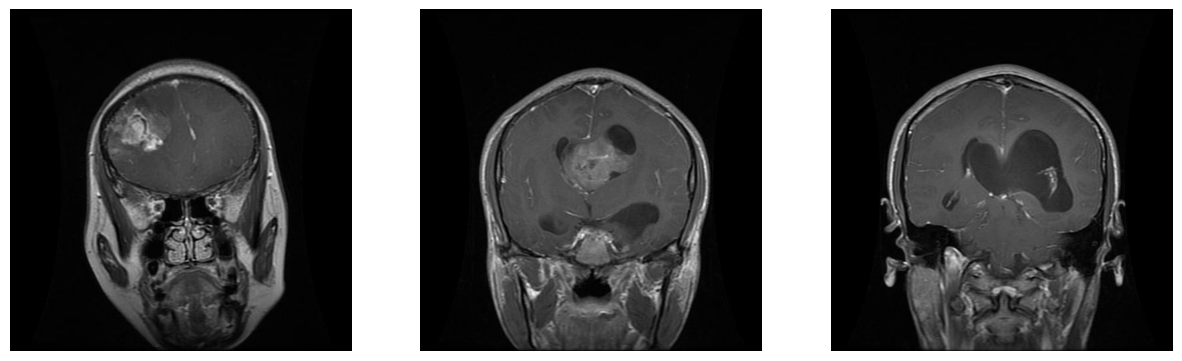

Category: meningioma


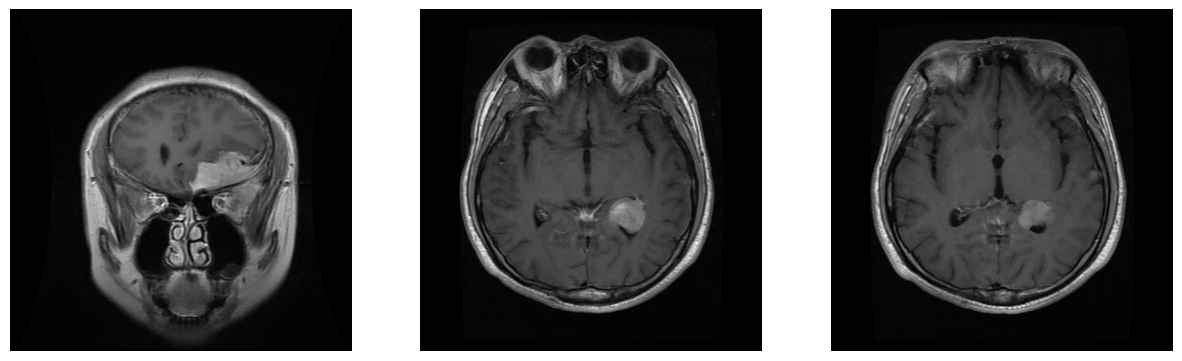

Category: notumor


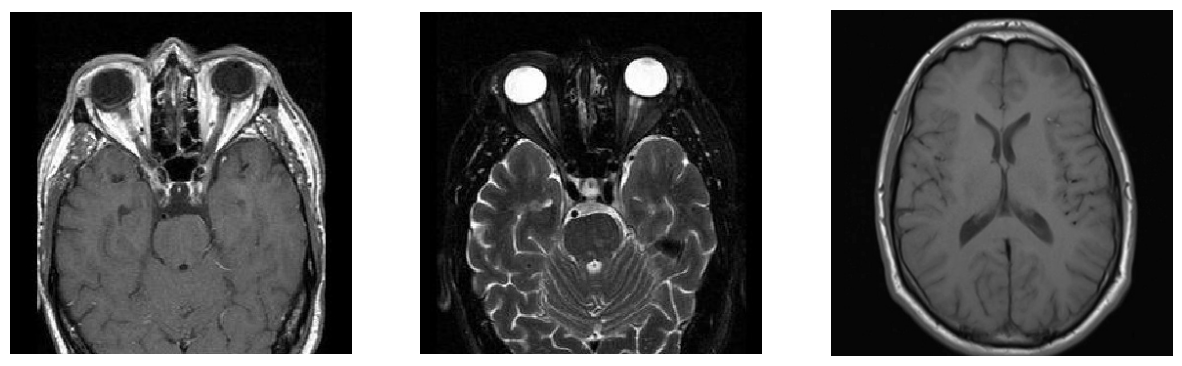

Category: pituitary


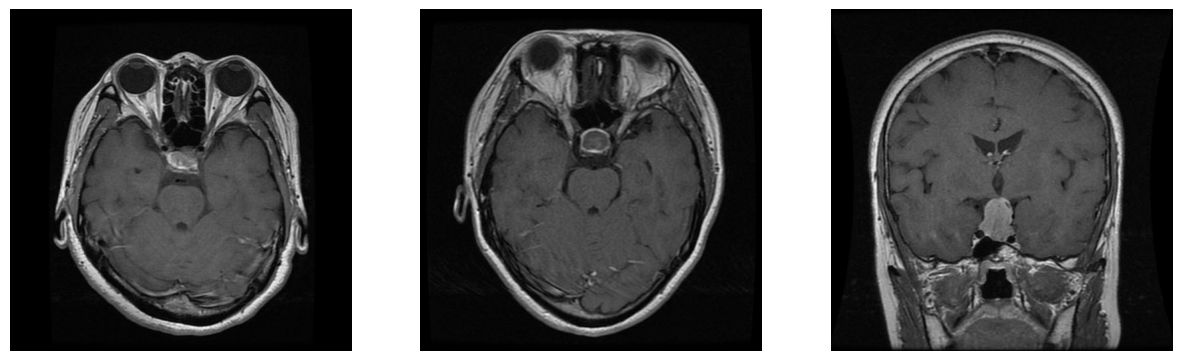

In [ ]:
# Function to display sample images from each category
def display_sample_images(categories, base_dir, num_samples=3):
    for category in categories:
        category_dir = os.path.join(base_dir, category)
        sample_images = os.listdir(category_dir)[:num_samples]

        print(f"Category: {category}")
        fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
        for i, img_file in enumerate(sample_images):
            img_path = os.path.join(category_dir, img_file)
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].axis('off')
        plt.show()

# Display sample images from Training directory
display_sample_images(training_categories, training_dir)

The data needs to be preprocessed and the image size needs to be made uniform inorder to plot the graph for the category distribution.

In [ ]:
# Constants
IMG_SIZE = (224, 224)

# Function to preprocess images
def preprocess_images(base_dir, categories):
    data = []
    labels = []

    for category in categories:
        category_dir = os.path.join(base_dir, category)
        label = categories.index(category)
        for img_file in os.listdir(category_dir):
            img_path = os.path.join(category_dir, img_file)
            img = load_img(img_path, target_size=IMG_SIZE)
            img_array = img_to_array(img) / 255.0  # Normalize to [0, 1]
            data.append(img_array)
            labels.append(label)

    return np.array(data), np.array(labels)

# Preprocess training and testing data
train_data, train_labels = preprocess_images(training_dir, training_categories)
test_data, test_labels = preprocess_images(testing_dir, testing_categories)

# Display shapes of the preprocessed datasets
print("Training data shape:", train_data.shape)
print("Training labels shape:", train_labels.shape)
print("Testing data shape:", test_data.shape)
print("Testing labels shape:", test_labels.shape)

Training data shape: (5712, 224, 224, 3)
Training labels shape: (5712,)
Testing data shape: (1311, 224, 224, 3)
Testing labels shape: (1311,)


<ipython-input-10-d59f94b48ef8>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=train_labels_df, palette='viridis')
<ipython-input-10-d59f94b48ef8>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=test_labels_df, palette='viridis')


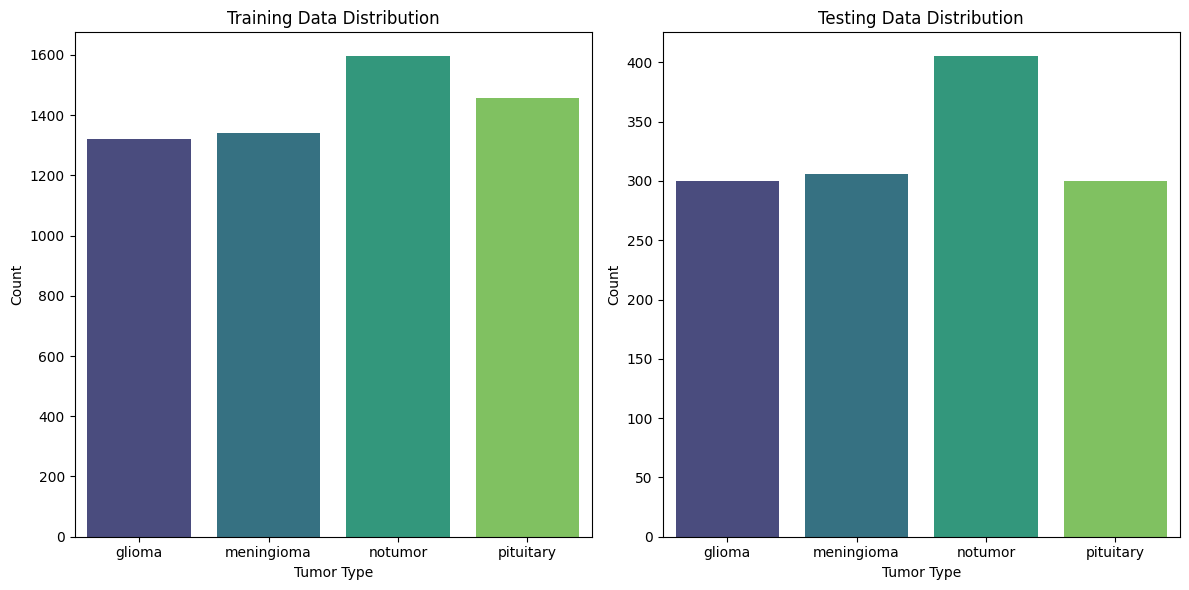

In [ ]:
# Convert labels to DataFrame for visualization
train_labels_df = pd.DataFrame(train_labels, columns=['label'])
test_labels_df = pd.DataFrame(test_labels, columns=['label'])

# Map numerical labels to category names
label_map = {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}
train_labels_df['label'] = train_labels_df['label'].map(label_map)
test_labels_df['label'] = test_labels_df['label'].map(label_map)

# Visualize the distribution of categories in training and testing datasets
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.countplot(x='label', data=train_labels_df, palette='viridis')
plt.title('Training Data Distribution')
plt.xlabel('Tumor Type')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.countplot(x='label', data=test_labels_df, palette='viridis')
plt.title('Testing Data Distribution')
plt.xlabel('Tumor Type')
plt.ylabel('Count')

plt.tight_layout()
plt.show()



From the graph, we can understand that the number of images in the training dataset is approximately four times the number of images in the test dataset for each category. In the training data, glioma and meningioma each have around 1300 images, no tumor has about 1600, and pituitary has approximately 1400 images. The testing data has glioma with around 300 images, meningioma with about 450, no tumor with approximately 370, and pituitary with around 350 images. Both datasets show a balanced distribution of tumor types, crucial for training an unbiased machine learning model. This balanced distribution is essential for developing an effective medical image classification model, ensuring reliable performance across all classes.

In [ ]:
def extract_image_dimensions(base_dir, categories):
    image_paths = []
    dimensions = []

    for category in categories:
        category_dir = os.path.join(base_dir, category)
        for img_file in os.listdir(category_dir):
            if img_file.endswith('.jpg') or img_file.endswith('.png'):
                img_path = os.path.join(category_dir, img_file)
                try:
                    with Image.open(img_path) as img:
                        width, height = img.size
                        image_paths.append(img_path)
                        dimensions.append((width, height))
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")

    return image_paths, dimensions

base_dir = '/content/drive/MyDrive/brain_tumour/Training'

image_paths, dimensions = extract_image_dimensions(base_dir, training_categories)


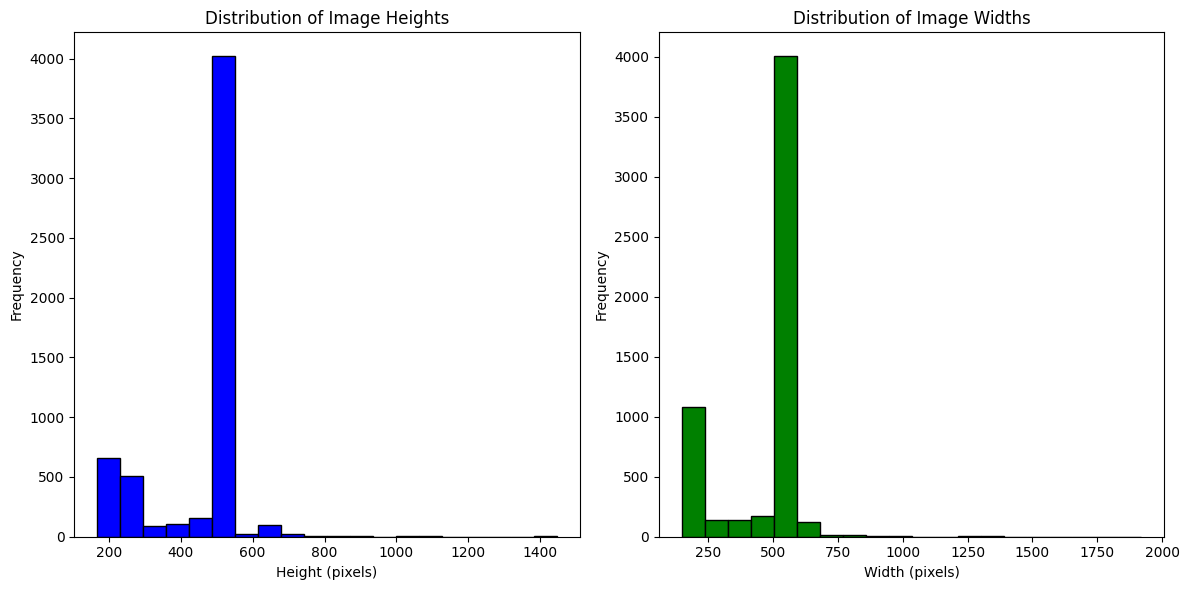

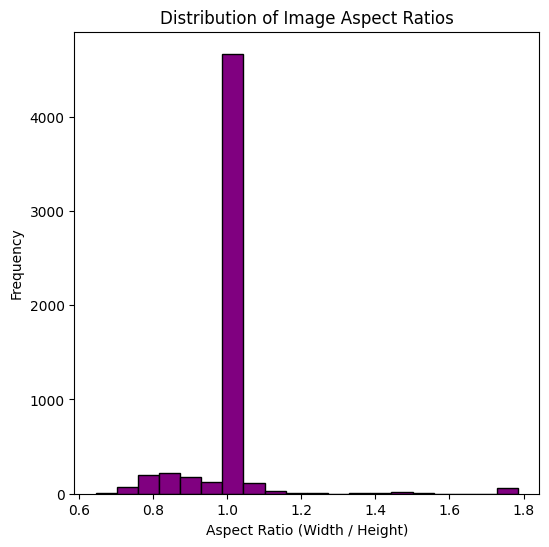

In [ ]:
def plot_image_dimensions(dimensions):
    if not dimensions:
        print("No dimensions to plot. Ensure images are loaded correctly.")
        return

    widths, heights = zip(*dimensions)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(heights, bins=20, color='blue', edgecolor='black')
    plt.xlabel('Height (pixels)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Image Heights')

    plt.subplot(1, 2, 2)
    plt.hist(widths, bins=20, color='green', edgecolor='black')
    plt.xlabel('Width (pixels)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Image Widths')

    plt.tight_layout()
    plt.show()

    aspect_ratios = [width / height for width, height in zip(widths, heights)]
    plt.figure(figsize=(6, 6))
    plt.hist(aspect_ratios, bins=20, color='purple', edgecolor='black')
    plt.xlabel('Aspect Ratio (Width / Height)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Image Aspect Ratios')
    plt.show()

# Plot the image dimensions and aspect ratios
plot_image_dimensions(dimensions)


The above graphs show the pixels and aspect ratio of the images in the training data before preprocessing.
Now we need to alter the image properties according to the requirements of the model.

# Data preprocessing for baseline models
This involve three major steps:
1. Loading the Images: Reading the images from the directories.
2. Resizing and Normalizing: Ensuring all images are of the same size and normalizing pixel values.
3. Augmentation: Optionally augmenting the data to improve model robustness.



In [ ]:
# Data generator function

def create_generators(IMG_SIZE, BATCH_SIZE):
    # Data generators
    train_datagen = ImageDataGenerator(rotation_range=20,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest',
                                       validation_split=0.2)
    test_datagen = ImageDataGenerator()

    train_generator = train_datagen.flow_from_directory(
        training_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training')

    validation_generator = train_datagen.flow_from_directory(
        training_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation')

    test_generator = test_datagen.flow_from_directory(
        testing_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical')

    return train_generator, validation_generator, test_generator

In [ ]:
# Function to plot the history graph

def plot_training_history(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(1, len(train_loss) + 1)

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plotting the training and validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


In [ ]:
# Function to evaluate the model metrics

def evaluate_model(model, test_generator):
    # Get true labels and predictions
    y_true = []
    y_pred = []
    y_pred_proba = []

    for batch in test_generator:
        images, labels = batch
        predictions = model.predict(images)
        y_true.extend(np.argmax(labels, axis=1))
        y_pred.extend(np.argmax(predictions, axis=1))
        y_pred_proba.extend(predictions)
        if len(y_true) >= test_generator.samples:
            break

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_pred_proba = np.array(y_pred_proba)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    # Calculate ROC-AUC score for each class and take the average
    roc_auc = roc_auc_score(tf.keras.utils.to_categorical(y_true), y_pred_proba, average='macro')

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"ROC-AUC Score: {roc_auc}")

    return accuracy, precision, recall, f1, roc_auc

# Creating and evaluating baseline models

## ResNet-50 Model

Now we need to resize all images to a consistent size (224x224 pixels) to fit the input requirements of the models.

In [ ]:
# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 100
NUM_CLASSES = 4  # glioma, meningioma, notumor, pituitary

train_generator, validation_generator, test_generator = create_generators(IMG_SIZE, BATCH_SIZE)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
# Load the ResNet50 model with pre-trained ImageNet weights
base_model_resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model_resnet50.trainable = False

94765736/94765736 [==============================] - 5s 0us/step


In [ ]:
# Add custom layers on top of the base model
x = base_model_resnet50.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(NUM_CLASSES, activation='sigmoid')(x)

# Create the full model
model = Model(inputs=base_model_resnet50.input, outputs=predictions)

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)


In [ ]:
# Train the model with data augmentation
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/100
143/143 [==============================] - 80s 532ms/step - loss: 0.5627 - accuracy: 0.7867 - val_loss: 0.5992 - val_accuracy: 0.7897 - lr: 1.0000e-04
Epoch 2/100
143/143 [==============================] - 76s 533ms/step - loss: 0.3725 - accuracy: 0.8692 - val_loss: 0.4981 - val_accuracy: 0.8221 - lr: 1.0000e-04
Epoch 3/100
143/143 [==============================] - 75s 527ms/step - loss: 0.3172 - accuracy: 0.8851 - val_loss: 0.4876 - val_accuracy: 0.8387 - lr: 1.0000e-04
Epoch 4/100
143/143 [==============================] - 75s 526ms/step - loss: 0.2932 - accuracy: 0.8926 - val_loss: 0.3995 - val_accuracy: 0.8589 - lr: 1.0000e-04
Epoch 5/100
143/143 [==============================] - 75s 526ms/step - loss: 0.2819 - accuracy: 0.9013 - val_loss: 0.4015 - val_accuracy: 0.8519 - lr: 1.0000e-04
Epoch 6/100
143/143 [==============================] - 75s 526ms/step - loss: 0.2346 - accuracy: 0.9127 - val_loss: 0.4068 - val_accuracy: 0.8624 - lr: 1.0000e-04
Epoch 7/100
143/143 [=

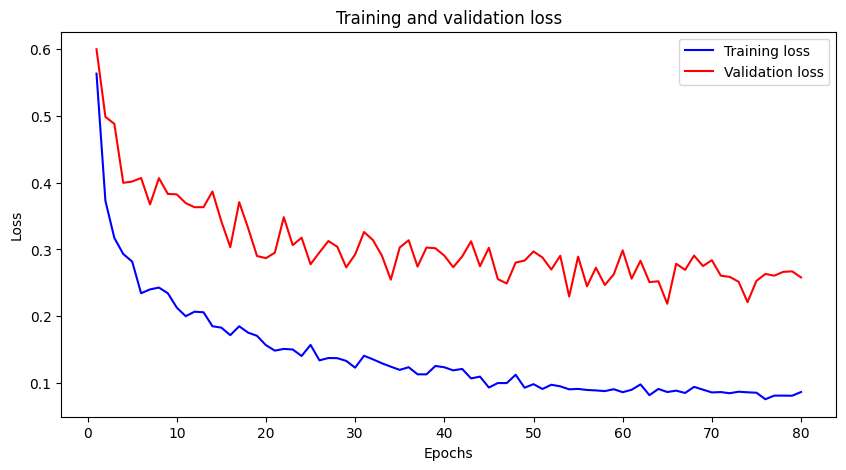

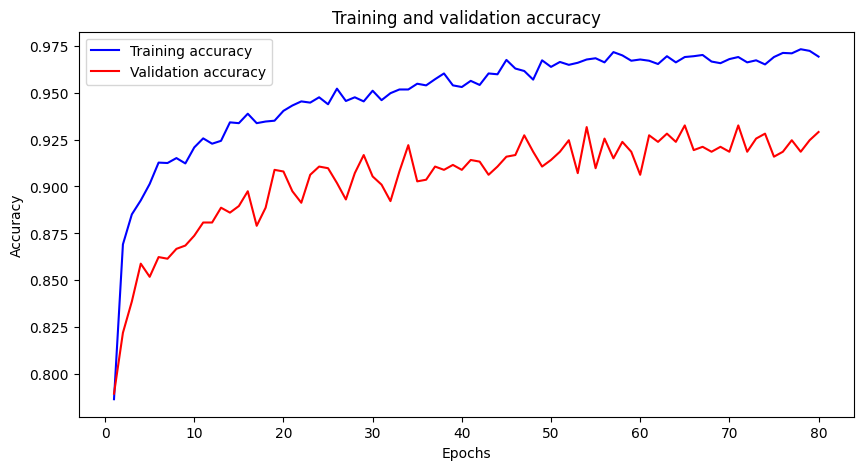

In [ ]:
plot_training_history(history)

In [ ]:
# Evaluate the metrics
accuracy, precision, recall, f1, roc_auc = evaluate_model(model, test_generator)

1/1 [==============================] - 2s 2s/step
Accuracy: 0.9382151029748284
Precision: 0.9365199614227996
Recall: 0.9347476397966594
F1 Score: 0.9349574109474418
ROC-AUC Score: 0.9842394209909889


Trying to run the model by changing the epochs to 100 and batch size to 64

In [ ]:
# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 64
EPOCHS = 100
NUM_CLASSES = 4  # glioma, meningioma, notumor, pituitary

train_generator, validation_generator, test_generator = create_generators(IMG_SIZE, BATCH_SIZE)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
# Load the ResNet50 model with pre-trained ImageNet weights
base_model_resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model_resnet50.trainable = False

In [ ]:
# Add custom layers on top of the base model
x = base_model_resnet50.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(NUM_CLASSES, activation='sigmoid')(x)

# Create the full model
model = Model(inputs=base_model_resnet50.input, outputs=predictions)

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

In [ ]:
# Train the model with data augmentation
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/100
72/72 [==============================] - 85s 1s/step - loss: 0.5581 - accuracy: 0.7933 - val_loss: 0.7653 - val_accuracy: 0.7125 - lr: 1.0000e-04
Epoch 2/100
72/72 [==============================] - 77s 1s/step - loss: 0.3782 - accuracy: 0.8655 - val_loss: 0.4923 - val_accuracy: 0.8186 - lr: 1.0000e-04
Epoch 3/100
72/72 [==============================] - 77s 1s/step - loss: 0.3080 - accuracy: 0.8882 - val_loss: 0.4467 - val_accuracy: 0.8361 - lr: 1.0000e-04
Epoch 4/100
72/72 [==============================] - 77s 1s/step - loss: 0.2812 - accuracy: 0.8978 - val_loss: 0.4432 - val_accuracy: 0.8396 - lr: 1.0000e-04
Epoch 5/100
72/72 [==============================] - 77s 1s/step - loss: 0.2647 - accuracy: 0.9075 - val_loss: 0.3913 - val_accuracy: 0.8545 - lr: 1.0000e-04
Epoch 6/100
72/72 [==============================] - 77s 1s/step - loss: 0.2358 - accuracy: 0.9092 - val_loss: 0.3663 - val_accuracy: 0.8808 - lr: 1.0000e-04
Epoch 7/100
72/72 [==============================] -

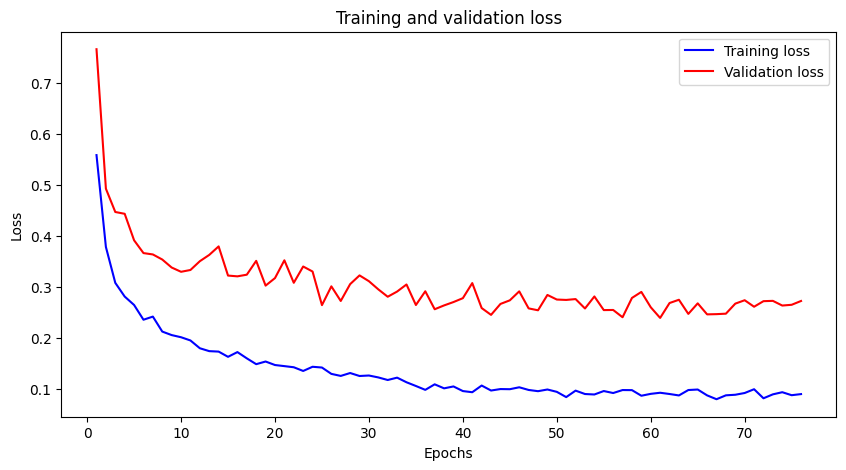

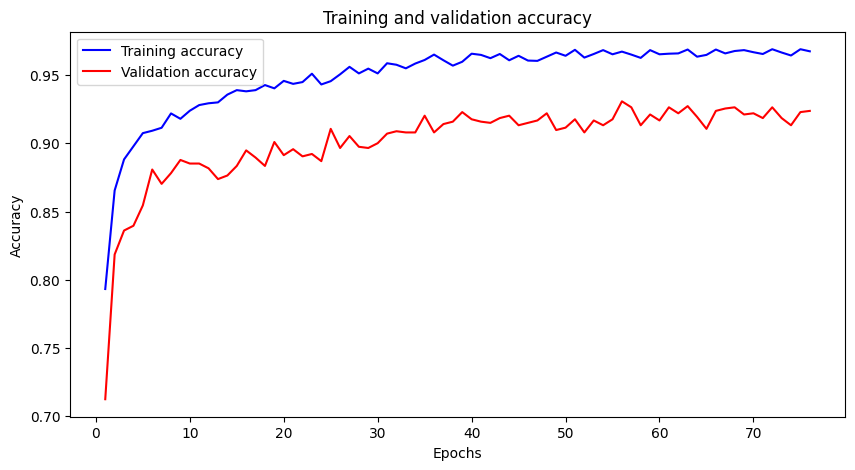

In [ ]:
plot_training_history(history)

In [ ]:
# Evaluate the metrics
accuracy, precision, recall, f1, roc_auc = evaluate_model(model, test_generator)

1/1 [==============================] - 1s 985ms/step
Accuracy: 0.9336384439359268
Precision: 0.9306033048838611
Recall: 0.9295806100217865
F1 Score: 0.9295275537382031
ROC-AUC Score: 0.9844999554734193


## VGG-19

In [ ]:
# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 100
NUM_CLASSES = 4  # glioma, meningioma, notumor, pituitary

train_generator, validation_generator, test_generator = create_generators(IMG_SIZE, BATCH_SIZE)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
# Load the ResNet50 model with pre-trained ImageNet weights
base_model_vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model_vgg19.trainable = False

In [ ]:
# Add custom layers on top of the base model
x = base_model_vgg19.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model_vgg19.input, outputs=predictions)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)


In [ ]:
# Train the model with data augmentation
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/100
143/143 [==============================] - 86s 531ms/step - loss: 0.7554 - accuracy: 0.7095 - val_loss: 0.7169 - val_accuracy: 0.7397 - lr: 1.0000e-04
Epoch 2/100
143/143 [==============================] - 76s 529ms/step - loss: 0.4920 - accuracy: 0.8130 - val_loss: 0.6889 - val_accuracy: 0.7520 - lr: 1.0000e-04
Epoch 3/100
143/143 [==============================] - 75s 526ms/step - loss: 0.4391 - accuracy: 0.8385 - val_loss: 0.6294 - val_accuracy: 0.7835 - lr: 1.0000e-04
Epoch 4/100
143/143 [==============================] - 76s 530ms/step - loss: 0.4055 - accuracy: 0.8569 - val_loss: 0.5657 - val_accuracy: 0.7958 - lr: 1.0000e-04
Epoch 5/100
143/143 [==============================] - 75s 528ms/step - loss: 0.3858 - accuracy: 0.8591 - val_loss: 0.5599 - val_accuracy: 0.8072 - lr: 1.0000e-04
Epoch 6/100
143/143 [==============================] - 75s 526ms/step - loss: 0.3461 - accuracy: 0.8722 - val_loss: 0.5332 - val_accuracy: 0.8107 - lr: 1.0000e-04
Epoch 7/100
143/143 [=

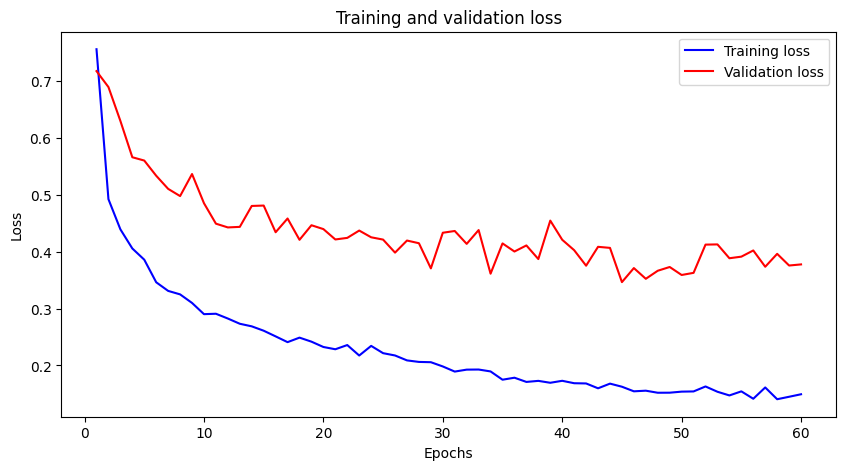

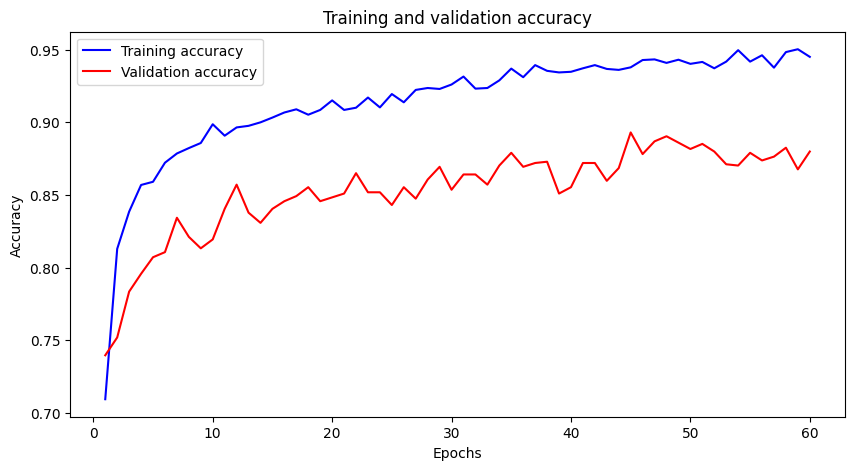

In [ ]:
plot_training_history(history)

In [ ]:
# Evaluate the metrics
accuracy, precision, recall, f1, roc_auc = evaluate_model(model, test_generator)

1/1 [==============================] - 0s 225ms/step
Accuracy: 0.9099923722349351
Precision: 0.9058790422147965
Recall: 0.9050236020334059
F1 Score: 0.903897956051695
ROC-AUC Score: 0.9885236720745094


In [ ]:
# Add custom layers on top of the base model
x = base_model_vgg19.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(NUM_CLASSES, activation='sigmoid')(x)

# Create the full model
model = Model(inputs=base_model_vgg19.input, outputs=predictions)

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)


In [ ]:
# Train the model with data augmentation
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/100
143/143 [==============================] - 94s 565ms/step - loss: 0.7055 - accuracy: 0.7373 - val_loss: 0.7642 - val_accuracy: 0.7274 - lr: 1.0000e-04
Epoch 2/100
143/143 [==============================] - 75s 527ms/step - loss: 0.4814 - accuracy: 0.8239 - val_loss: 0.6770 - val_accuracy: 0.7695 - lr: 1.0000e-04
Epoch 3/100
143/143 [==============================] - 75s 526ms/step - loss: 0.4292 - accuracy: 0.8469 - val_loss: 0.6442 - val_accuracy: 0.7844 - lr: 1.0000e-04
Epoch 4/100
143/143 [==============================] - 76s 530ms/step - loss: 0.3935 - accuracy: 0.8613 - val_loss: 0.5681 - val_accuracy: 0.8081 - lr: 1.0000e-04
Epoch 5/100
143/143 [==============================] - 75s 521ms/step - loss: 0.3728 - accuracy: 0.8692 - val_loss: 0.6355 - val_accuracy: 0.7914 - lr: 1.0000e-04
Epoch 6/100
143/143 [==============================] - 75s 526ms/step - loss: 0.3509 - accuracy: 0.8751 - val_loss: 0.5943 - val_accuracy: 0.8063 - lr: 1.0000e-04
Epoch 7/100
143/143 [=

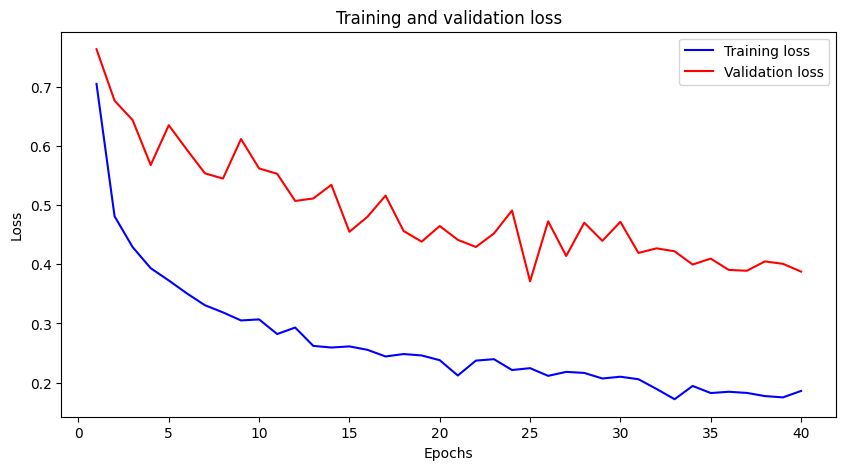

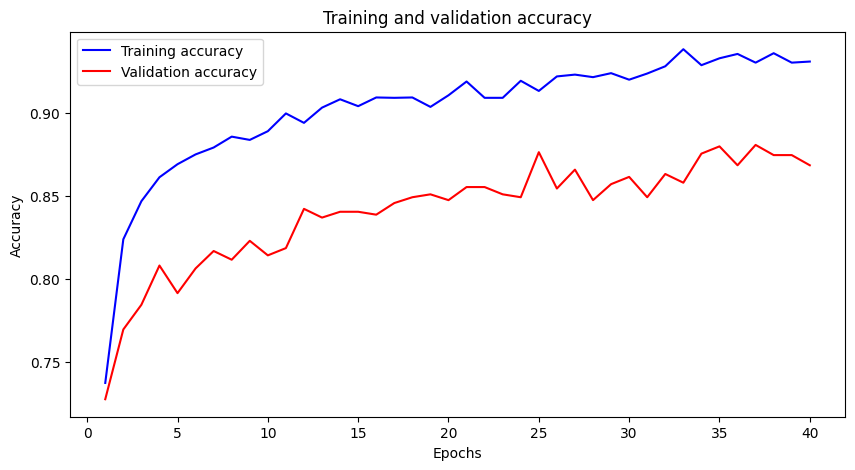

In [ ]:
plot_training_history(history)

In [ ]:
# Evaluate the metrics
accuracy, precision, recall, f1, roc_auc = evaluate_model(model, test_generator)

1/1 [==============================] - 5s 5s/step
Accuracy: 0.8939740655987796
Precision: 0.8920573691193866
Recall: 0.8872185911401598
F1 Score: 0.8861624862461912
ROC-AUC Score: 0.9739074976189821


Trying to run the VGG-19 model with batch size 64 and epochs 100

In [ ]:
# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 64
EPOCHS = 100
NUM_CLASSES = 4  # glioma, meningioma, notumor, pituitary

train_generator, validation_generator, test_generator = create_generators(IMG_SIZE, BATCH_SIZE)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
# Load the ResNet50 model with pre-trained ImageNet weights
base_model_vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model_vgg19.trainable = False

In [ ]:
# Add custom layers on top of the base model
x = base_model_vgg19.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model_vgg19.input, outputs=predictions)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)


In [ ]:
# Train the model with data augmentation
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/100
72/72 [==============================] - 79s 1s/step - loss: 0.7970 - accuracy: 0.6878 - val_loss: 0.8671 - val_accuracy: 0.6766 - lr: 1.0000e-04
Epoch 2/100
72/72 [==============================] - 76s 1s/step - loss: 0.4917 - accuracy: 0.8145 - val_loss: 0.6883 - val_accuracy: 0.7493 - lr: 1.0000e-04
Epoch 3/100
72/72 [==============================] - 76s 1s/step - loss: 0.4223 - accuracy: 0.8410 - val_loss: 0.6366 - val_accuracy: 0.7756 - lr: 1.0000e-04
Epoch 4/100
72/72 [==============================] - 76s 1s/step - loss: 0.4096 - accuracy: 0.8523 - val_loss: 0.6063 - val_accuracy: 0.7800 - lr: 1.0000e-04
Epoch 5/100
72/72 [==============================] - 77s 1s/step - loss: 0.3756 - accuracy: 0.8609 - val_loss: 0.6055 - val_accuracy: 0.7967 - lr: 1.0000e-04
Epoch 6/100
72/72 [==============================] - 77s 1s/step - loss: 0.3625 - accuracy: 0.8674 - val_loss: 0.5669 - val_accuracy: 0.7975 - lr: 1.0000e-04
Epoch 7/100
72/72 [==============================] -

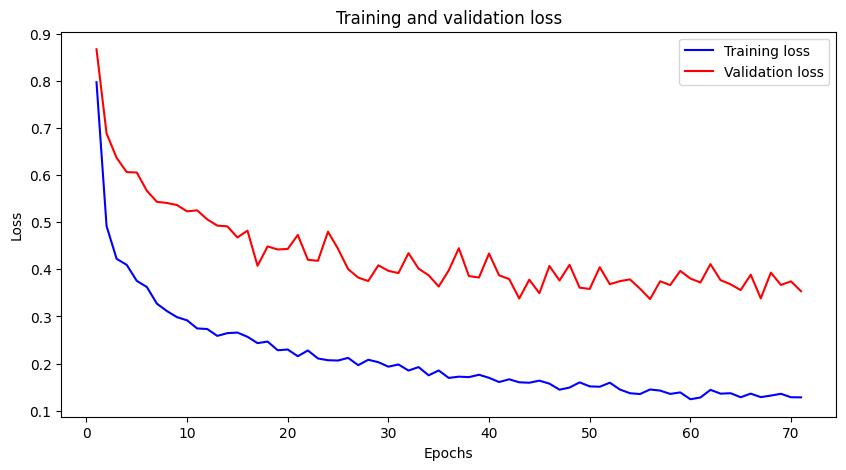

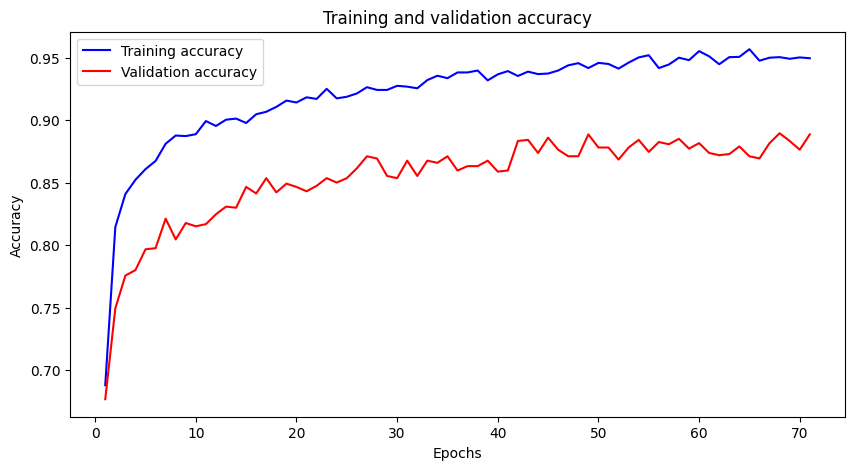

In [ ]:
plot_training_history(history)

In [ ]:
# Evaluate the metrics
accuracy, precision, recall, f1, roc_auc = evaluate_model(model, test_generator)

1/1 [==============================] - 0s 224ms/step
Accuracy: 0.9031273836765827
Precision: 0.9010630778330085
Recall: 0.897156862745098
F1 Score: 0.8967477775183341
ROC-AUC Score: 0.988508366568636


In [ ]:
# Add custom layers on top of the base model
x = base_model_vgg19.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(NUM_CLASSES, activation='sigmoid')(x)

# Create the full model
model = Model(inputs=base_model_vgg19.input, outputs=predictions)

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)


In [ ]:
# Train the model with data augmentation
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/100
72/72 [==============================] - 93s 1s/step - loss: 0.7394 - accuracy: 0.7132 - val_loss: 0.9973 - val_accuracy: 0.6626 - lr: 1.0000e-04
Epoch 2/100
72/72 [==============================] - 77s 1s/step - loss: 0.4792 - accuracy: 0.8232 - val_loss: 0.7238 - val_accuracy: 0.7520 - lr: 1.0000e-04
Epoch 3/100
72/72 [==============================] - 76s 1s/step - loss: 0.4239 - accuracy: 0.8431 - val_loss: 0.6341 - val_accuracy: 0.8011 - lr: 1.0000e-04
Epoch 4/100
72/72 [==============================] - 76s 1s/step - loss: 0.3971 - accuracy: 0.8600 - val_loss: 0.5839 - val_accuracy: 0.7993 - lr: 1.0000e-04
Epoch 5/100
72/72 [==============================] - 76s 1s/step - loss: 0.3726 - accuracy: 0.8683 - val_loss: 0.6067 - val_accuracy: 0.7879 - lr: 1.0000e-04
Epoch 6/100
72/72 [==============================] - 76s 1s/step - loss: 0.3405 - accuracy: 0.8806 - val_loss: 0.5265 - val_accuracy: 0.8098 - lr: 1.0000e-04
Epoch 7/100
72/72 [==============================] -

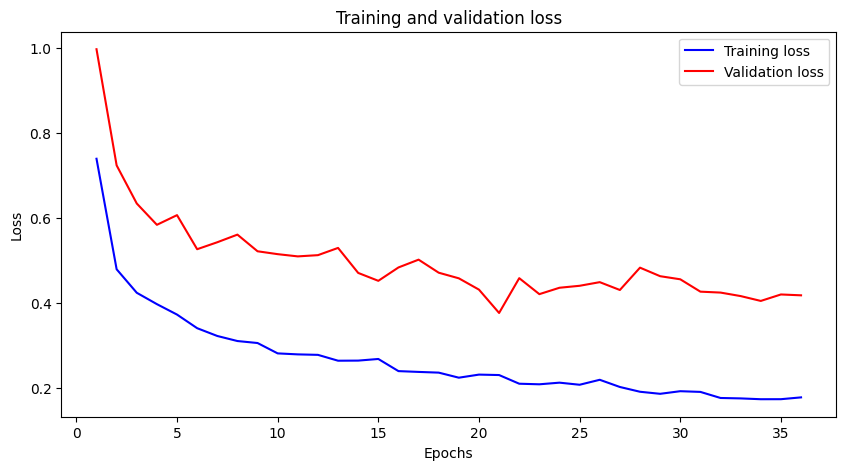

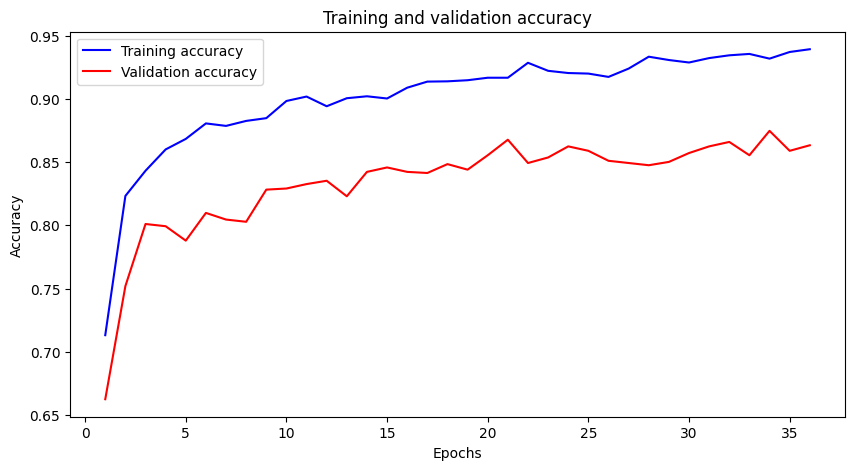

In [ ]:
plot_training_history(history)

In [ ]:
# Evaluate the metrics
accuracy, precision, recall, f1, roc_auc = evaluate_model(model, test_generator)

1/1 [==============================] - 0s 216ms/step
Accuracy: 0.8779557589626239
Precision: 0.8761407402362567
Recall: 0.8706154684095861
F1 Score: 0.8696885026699958
ROC-AUC Score: 0.9711950573247701


# GAN (Generative Adverserial Network)

In [ ]:
# Load the dataset
def load_dataset_from_directory(directory):
    images = []
    labels = []
    class_names = sorted([d.name for d in directory.iterdir() if d.is_dir()])

    for label, class_name in enumerate(class_names):
        class_dir = directory / class_name
        for image_path in class_dir.iterdir():
            if image_path.suffix in ['.png', '.jpg', '.jpeg']:
                image = Image.open(image_path).resize((224, 224)).convert('RGB')
                images.append(np.array(image) / 255.0)
                labels.append(label)

    return np.array(images), np.array(labels), class_names

training_dir = Path('/content/drive/MyDrive/brain_tumour/Training')
train_images, train_labels, class_names = load_dataset_from_directory(training_dir)

In [ ]:
# Convert labels to one-hot encoding
encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = encoder.fit_transform(train_labels.reshape(-1, 1))

# Split the training dataset into training and validation data
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels_one_hot, test_size=0.2, random_state=42)


In [ ]:
# Resize images to 14x14
def resize_images(images, size=(14, 14)):
    resized_images = []
    for img in images:
        img = Image.fromarray((img * 255).astype(np.uint8))
        img = img.resize(size, Image.LANCZOS)
        img = np.array(img) / 255.0
        resized_images.append(img)
    return np.array(resized_images)

# Resize the train and validation images
X_train_resized = resize_images(X_train, size=(14, 14))
X_val_resized = resize_images(X_val, size=(14, 14))

# Normalize to [-1, 1] for tanh activation
X_train_resized = (X_train_resized * 2) - 1
X_val_resized = (X_val_resized * 2) - 1

In [ ]:
# Set parameters
NOISE_DIM = 100
WIDTH, HEIGHT, CHANNELS = 14, 14, 3
BATCH_SIZE = 32
EPOCHS = 100
STEPS_PER_EPOCH = 100
OPTIMIZER = tf.keras.optimizers.legacy.Adam(learning_rate=0.0002, beta_1=0.5)

# Define the generator model
def build_generator():
    model = Sequential([
        Dense(128 * 7 * 7, input_dim=NOISE_DIM),
        LeakyReLU(alpha=0.2),
        Reshape((7, 7, 128)),
        Conv2DTranspose(128, (4, 4), strides=2, padding='same'), # (14, 14, 128)
        LeakyReLU(alpha=0.2),
        Conv2DTranspose(128, (4, 4), strides=1, padding='same'), # (14, 14, 128)
        LeakyReLU(alpha=0.2),
        Conv2D(CHANNELS, (3, 3), padding='same', activation='tanh') # (14, 14, 3)
    ], name="generator")
    model.compile(loss="binary_crossentropy", optimizer=OPTIMIZER)
    return model


In [ ]:
# Define the discriminator model
def build_discriminator():
    model = Sequential([
        Conv2D(64, (3, 3), padding='same', input_shape=(WIDTH, HEIGHT, CHANNELS)),
        LeakyReLU(alpha=0.2),
        Conv2D(128, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        Conv2D(128, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        Conv2D(256, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        Flatten(),
        Dropout(0.4),
        Dense(1, activation="sigmoid")
    ], name="discriminator")
    model.compile(loss="binary_crossentropy", optimizer=OPTIMIZER, metrics=['accuracy'])
    return model

# Build and compile the models
generator = build_generator()
discriminator = build_discriminator()

In [ ]:
# Create the combined GAN model
discriminator.trainable = False
gan_input = Input(shape=(NOISE_DIM,))
fake_image = generator(gan_input)
gan_output = discriminator(fake_image)
gan = Model(gan_input, gan_output, name="gan_model")
gan.compile(loss="binary_crossentropy", optimizer=OPTIMIZER)

# Summarize the models
print("Generator Model Summary:")
generator.summary()
print("\nDiscriminator Model Summary:")
discriminator.summary()
print("\nCombined GAN Model Summary:")
gan.summary()

Generator Model Summary:
Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 6272)              633472    
                                                                 
 leaky_re_lu_28 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_4 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_8 (Conv2D  (None, 14, 14, 128)       262272    
 Transpose)                                                      
                                                                 
 leaky_re_lu_29 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_9 (Conv2D  (None, 14, 14, 128)       262272    
 Transpose)                     

In [ ]:
# Function to display generated images
def display_images(generator, noise_dim, epoch, num_images=10, save=False):
    noise = np.random.normal(0, 1, (num_images, noise_dim))
    generated_images = generator.predict(noise)
    generated_images = 0.5 * generated_images + 0.5  # Rescale images to [0, 1]

    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')

    if save:
        plt.savefig(f'generated_image_epoch_{epoch}.png')
    plt.show()

In [ ]:
# Training loop for the GAN
def train_gan(generator, discriminator, gan, data, epochs, batch_size, steps_per_epoch, noise_dim):
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        for step in tqdm(range(steps_per_epoch)):
            # Train discriminator with real and fake images
            noise = np.random.normal(0, 1, (batch_size, noise_dim))
            fake_images = generator.predict(noise)
            idx = np.random.randint(0, data.shape[0], batch_size)
            real_images = data[idx]
            combined_images = np.concatenate([real_images, fake_images])
            labels = np.concatenate([real_labels, fake_labels])
            d_loss = discriminator.train_on_batch(combined_images, labels)

            # Train generator
            noise = np.random.normal(0, 1, (batch_size, noise_dim))
            g_loss = gan.train_on_batch(noise, real_labels)

        if epoch % 10 == 0:
            print(f'Epoch {epoch+1}, D Loss: {d_loss[0]:.4f}, D Acc: {100*d_loss[1]:.2f}%, G Loss: {g_loss:.4f}')
            display_images(generator, noise_dim, epoch)

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 80ms/step


  1%|          | 1/100 [00:02<03:43,  2.26s/it]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 3/100 [00:02<01:02,  1.56it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 5/100 [00:02<00:33,  2.84it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 7/100 [00:02<00:21,  4.24it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 9/100 [00:02<00:15,  5.71it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 11/100 [00:03<00:12,  7.14it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 13/100 [00:03<00:10,  8.35it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▌        | 15/100 [00:03<00:08,  9.55it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 17/100 [00:03<00:07, 10.48it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 19/100 [00:03<00:07, 11.26it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 21/100 [00:03<00:06, 11.94it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 23/100 [00:03<00:06, 12.30it/s]

1/1 [==============================] - 0s 15ms/step


 25%|██▌       | 25/100 [00:04<00:05, 12.73it/s]

1/1 [==============================] - 0s 15ms/step


 27%|██▋       | 27/100 [00:04<00:05, 12.67it/s]

1/1 [==============================] - 0s 15ms/step


 29%|██▉       | 29/100 [00:04<00:05, 12.58it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 31/100 [00:04<00:05, 12.28it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 33/100 [00:04<00:05, 12.29it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▌      | 35/100 [00:04<00:05, 12.30it/s]

1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 37/100 [00:05<00:05, 12.38it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 39/100 [00:05<00:04, 12.27it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 41/100 [00:05<00:04, 12.13it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 43/100 [00:05<00:04, 12.15it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 45/100 [00:05<00:04, 12.04it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 47/100 [00:05<00:04, 11.99it/s]

1/1 [==============================] - 0s 15ms/step


 49%|████▉     | 49/100 [00:06<00:04, 12.09it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 51/100 [00:06<00:04, 11.99it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 53/100 [00:06<00:03, 11.98it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 55/100 [00:06<00:03, 11.93it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 57/100 [00:06<00:03, 12.00it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 59/100 [00:06<00:03, 12.03it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 61/100 [00:07<00:03, 11.85it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 63/100 [00:07<00:03, 11.87it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 65/100 [00:07<00:02, 12.00it/s]

1/1 [==============================] - 0s 15ms/step


 67%|██████▋   | 67/100 [00:07<00:02, 12.04it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 69/100 [00:07<00:02, 12.05it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 71/100 [00:07<00:02, 11.90it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 73/100 [00:08<00:02, 11.93it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▌  | 75/100 [00:08<00:02, 11.69it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 77/100 [00:08<00:01, 11.68it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 79/100 [00:08<00:01, 11.69it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 81/100 [00:08<00:01, 11.52it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 83/100 [00:08<00:01, 11.53it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 85/100 [00:09<00:01, 11.63it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 87/100 [00:09<00:01, 11.62it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 89/100 [00:09<00:00, 11.59it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 91/100 [00:09<00:00, 11.45it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 93/100 [00:09<00:00, 11.47it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 95/100 [00:09<00:00, 11.56it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 97/100 [00:10<00:00, 11.69it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 99/100 [00:10<00:00, 11.82it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 100/100 [00:10<00:00,  9.63it/s]

Epoch 1, D Loss: 0.7408, D Acc: 53.12%, G Loss: 1.2797


1/1 [==============================] - 0s 289ms/step


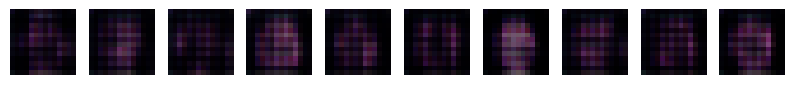

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  2%|▏         | 2/100 [00:00<00:07, 12.48it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 4/100 [00:00<00:07, 12.64it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 6/100 [00:00<00:07, 12.57it/s]

1/1 [==============================] - 0s 15ms/step


  8%|▊         | 8/100 [00:00<00:07, 12.63it/s]

1/1 [==============================] - 0s 15ms/step


 10%|█         | 10/100 [00:00<00:06, 13.02it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 12/100 [00:00<00:06, 12.69it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 14/100 [00:01<00:06, 12.82it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 16/100 [00:01<00:06, 12.96it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 18/100 [00:01<00:06, 13.06it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 20/100 [00:01<00:06, 12.96it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 22/100 [00:01<00:06, 12.63it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 24/100 [00:01<00:06, 12.52it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 26/100 [00:02<00:05, 12.42it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 28/100 [00:02<00:05, 12.19it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 30/100 [00:02<00:05, 11.85it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 32/100 [00:02<00:05, 11.58it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 34/100 [00:02<00:05, 11.59it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 36/100 [00:02<00:05, 11.55it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 38/100 [00:03<00:05, 11.30it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 40/100 [00:03<00:05, 11.48it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 42/100 [00:03<00:05, 11.56it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 44/100 [00:03<00:04, 11.46it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 46/100 [00:03<00:04, 11.55it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 48/100 [00:03<00:04, 11.63it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 50/100 [00:04<00:04, 11.71it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 11.61it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 54/100 [00:04<00:03, 11.74it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 56/100 [00:04<00:03, 11.85it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 58/100 [00:04<00:03, 11.82it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 60/100 [00:04<00:03, 11.96it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 11.89it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 11.88it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 66/100 [00:05<00:02, 11.93it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 68/100 [00:05<00:02, 11.87it/s]

1/1 [==============================] - 0s 15ms/step


 70%|███████   | 70/100 [00:05<00:02, 11.92it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 72/100 [00:05<00:02, 11.87it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 11.89it/s]

1/1 [==============================] - 0s 15ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 11.98it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 78/100 [00:06<00:01, 12.01it/s]

1/1 [==============================] - 0s 16ms/step


 80%|████████  | 80/100 [00:06<00:01, 12.04it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 82/100 [00:06<00:01, 11.99it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 84/100 [00:06<00:01, 12.02it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 11.96it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 88/100 [00:07<00:01, 11.99it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 90/100 [00:07<00:00, 12.00it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 92/100 [00:07<00:00, 11.87it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 94/100 [00:07<00:00, 11.96it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 96/100 [00:07<00:00, 12.02it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 12.03it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 2/100 [00:00<00:08, 11.59it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 4/100 [00:00<00:08, 11.88it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▌         | 6/100 [00:00<00:07, 11.98it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 8/100 [00:00<00:07, 11.83it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 10/100 [00:00<00:07, 11.81it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 12/100 [00:01<00:07, 11.56it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 14/100 [00:01<00:07, 11.54it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 16/100 [00:01<00:07, 11.57it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 18/100 [00:01<00:07, 11.56it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 20/100 [00:01<00:06, 11.63it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 22/100 [00:01<00:06, 11.57it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 24/100 [00:02<00:06, 11.63it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 26/100 [00:02<00:06, 11.41it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 28/100 [00:02<00:06, 11.41it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 30/100 [00:02<00:06, 11.43it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 32/100 [00:02<00:05, 11.35it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 34/100 [00:02<00:05, 11.49it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 36/100 [00:03<00:05, 11.61it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 38/100 [00:03<00:05, 11.47it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 40/100 [00:03<00:05, 11.65it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 42/100 [00:03<00:04, 11.68it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 44/100 [00:03<00:04, 11.65it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 46/100 [00:03<00:04, 11.35it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 48/100 [00:04<00:04, 11.52it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 50/100 [00:04<00:04, 11.56it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 11.63it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 54/100 [00:04<00:03, 11.79it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 56/100 [00:04<00:03, 11.90it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 58/100 [00:04<00:03, 11.74it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 60/100 [00:05<00:03, 11.41it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 11.43it/s]

1/1 [==============================] - 0s 15ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 11.58it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 66/100 [00:05<00:02, 11.68it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 68/100 [00:05<00:02, 11.79it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 70/100 [00:06<00:02, 11.60it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 11.39it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 11.45it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 11.23it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 78/100 [00:06<00:01, 11.23it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 80/100 [00:06<00:01, 10.87it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 10.78it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 10.96it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 11.18it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 88/100 [00:07<00:01, 11.33it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 90/100 [00:07<00:00, 11.40it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 11.40it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 11.49it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 11.63it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 11.80it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 2/100 [00:00<00:08, 12.22it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 4/100 [00:00<00:07, 12.12it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 6/100 [00:00<00:07, 11.89it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 8/100 [00:00<00:07, 11.90it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 10/100 [00:00<00:07, 11.82it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 12/100 [00:01<00:07, 11.89it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 14/100 [00:01<00:07, 11.96it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 16/100 [00:01<00:07, 11.96it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 18/100 [00:01<00:06, 12.06it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 20/100 [00:01<00:06, 11.97it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 22/100 [00:01<00:06, 12.02it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 24/100 [00:02<00:06, 12.06it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 26/100 [00:02<00:06, 12.06it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 28/100 [00:02<00:05, 12.01it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 30/100 [00:02<00:05, 11.74it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 32/100 [00:02<00:05, 11.90it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 34/100 [00:02<00:05, 11.89it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 36/100 [00:03<00:05, 11.99it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 38/100 [00:03<00:05, 12.08it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 40/100 [00:03<00:05, 11.91it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 42/100 [00:03<00:04, 11.80it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 44/100 [00:03<00:04, 11.65it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 46/100 [00:03<00:04, 11.72it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 48/100 [00:04<00:04, 11.89it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 50/100 [00:04<00:04, 11.76it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 11.70it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 54/100 [00:04<00:04, 11.46it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 56/100 [00:04<00:03, 11.65it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 58/100 [00:04<00:03, 11.71it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 60/100 [00:05<00:03, 11.69it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 11.72it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 11.73it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 66/100 [00:05<00:02, 11.55it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 68/100 [00:05<00:02, 11.38it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 70/100 [00:05<00:02, 11.12it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 10.84it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 10.77it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 10.69it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 78/100 [00:06<00:02, 10.63it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 80/100 [00:06<00:01, 10.47it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 10.61it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 10.68it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 10.59it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 88/100 [00:07<00:01, 10.48it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 90/100 [00:07<00:00, 10.45it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 10.70it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 10.98it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 10.88it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 10.71it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 1/100 [00:00<00:14,  6.84it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 2/100 [00:00<00:12,  7.80it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 4/100 [00:00<00:10,  9.23it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 6/100 [00:00<00:09, 10.10it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 8/100 [00:00<00:08, 10.39it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 10/100 [00:00<00:08, 10.69it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 12/100 [00:01<00:07, 11.01it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 14/100 [00:01<00:07, 11.19it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 16/100 [00:01<00:07, 11.23it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 18/100 [00:01<00:07, 11.22it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 20/100 [00:01<00:07, 11.09it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 22/100 [00:02<00:07, 10.85it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 24/100 [00:02<00:06, 10.90it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 26/100 [00:02<00:06, 11.15it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 28/100 [00:02<00:06, 11.28it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 30/100 [00:02<00:06, 11.23it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 32/100 [00:02<00:05, 11.54it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 34/100 [00:03<00:05, 11.73it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 36/100 [00:03<00:05, 11.83it/s]

1/1 [==============================] - 0s 15ms/step


 38%|███▊      | 38/100 [00:03<00:05, 11.98it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 40/100 [00:03<00:05, 11.85it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 42/100 [00:03<00:04, 11.78it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 44/100 [00:03<00:04, 11.92it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 46/100 [00:04<00:04, 11.99it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 48/100 [00:04<00:04, 12.01it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 50/100 [00:04<00:04, 11.86it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 11.86it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 54/100 [00:04<00:03, 11.63it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 56/100 [00:04<00:03, 11.71it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 11.74it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 60/100 [00:05<00:03, 11.71it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 11.84it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 11.85it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 66/100 [00:05<00:02, 11.72it/s]

1/1 [==============================] - 0s 15ms/step


 68%|██████▊   | 68/100 [00:05<00:02, 11.91it/s]

1/1 [==============================] - 0s 15ms/step


 70%|███████   | 70/100 [00:06<00:02, 11.85it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 11.93it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 11.97it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 76/100 [00:06<00:01, 12.05it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 78/100 [00:06<00:01, 11.90it/s]

1/1 [==============================] - 0s 16ms/step


 80%|████████  | 80/100 [00:06<00:01, 11.87it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 11.88it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 11.82it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 11.74it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 88/100 [00:07<00:01, 11.82it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 90/100 [00:07<00:00, 11.55it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 11.60it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 11.70it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 11.75it/s]

1/1 [==============================] - 0s 15ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 11.88it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 2/100 [00:00<00:08, 10.97it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 4/100 [00:00<00:08, 11.43it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 6/100 [00:00<00:08, 11.59it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 8/100 [00:00<00:07, 11.78it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 10/100 [00:00<00:07, 11.73it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 12/100 [00:01<00:07, 11.64it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 14/100 [00:01<00:07, 11.65it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 16/100 [00:01<00:07, 11.70it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 18/100 [00:01<00:07, 11.71it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 20/100 [00:01<00:06, 11.64it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 22/100 [00:01<00:06, 11.71it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 24/100 [00:02<00:06, 11.61it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 26/100 [00:02<00:06, 11.60it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 28/100 [00:02<00:06, 11.71it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 30/100 [00:02<00:06, 11.63it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 32/100 [00:02<00:05, 11.69it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 34/100 [00:02<00:05, 11.71it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 36/100 [00:03<00:05, 11.70it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 38/100 [00:03<00:05, 11.67it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 40/100 [00:03<00:05, 11.58it/s]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 42/100 [00:03<00:05, 11.54it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 44/100 [00:03<00:04, 11.49it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 46/100 [00:03<00:04, 11.47it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 48/100 [00:04<00:04, 11.31it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 50/100 [00:04<00:04, 11.25it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 11.30it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 54/100 [00:04<00:04, 11.30it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 56/100 [00:04<00:03, 11.17it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 11.09it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 60/100 [00:05<00:03, 11.01it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 10.95it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 10.91it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 66/100 [00:05<00:03, 11.03it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 68/100 [00:05<00:02, 10.96it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 70/100 [00:06<00:02, 10.99it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 11.23it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 11.48it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 11.69it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 78/100 [00:06<00:01, 11.84it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 80/100 [00:06<00:01, 11.74it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 11.80it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 11.81it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 11.92it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 88/100 [00:07<00:00, 12.02it/s]

1/1 [==============================] - 0s 16ms/step


 90%|█████████ | 90/100 [00:07<00:00, 11.90it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 92/100 [00:07<00:00, 11.95it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 11.99it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 12.00it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 12.04it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 2/100 [00:00<00:08, 12.02it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 4/100 [00:00<00:08, 11.88it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 6/100 [00:00<00:07, 11.83it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 8/100 [00:00<00:07, 11.88it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 10/100 [00:00<00:07, 11.73it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 12/100 [00:01<00:07, 11.86it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 14/100 [00:01<00:07, 11.94it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 16/100 [00:01<00:07, 11.89it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 18/100 [00:01<00:06, 11.85it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 20/100 [00:01<00:06, 11.75it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 22/100 [00:01<00:06, 11.77it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 24/100 [00:02<00:06, 11.73it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 26/100 [00:02<00:06, 11.78it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 28/100 [00:02<00:06, 11.68it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 30/100 [00:02<00:06, 11.48it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 32/100 [00:02<00:05, 11.42it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 34/100 [00:02<00:05, 11.57it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 36/100 [00:03<00:05, 11.65it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 38/100 [00:03<00:05, 11.69it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 40/100 [00:03<00:05, 11.57it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 42/100 [00:03<00:04, 11.62it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 44/100 [00:03<00:04, 11.56it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 46/100 [00:03<00:04, 11.73it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 48/100 [00:04<00:04, 11.93it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 50/100 [00:04<00:04, 11.86it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 11.73it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 54/100 [00:04<00:03, 11.81it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 56/100 [00:04<00:03, 11.80it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 58/100 [00:04<00:03, 11.88it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 60/100 [00:05<00:03, 11.80it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 11.89it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 11.93it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 66/100 [00:05<00:02, 12.02it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 68/100 [00:05<00:02, 12.04it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 70/100 [00:05<00:02, 11.89it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 11.90it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 11.78it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 11.42it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 78/100 [00:06<00:01, 11.25it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 80/100 [00:06<00:01, 11.25it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 11.35it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 11.45it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 11.59it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 88/100 [00:07<00:01, 11.34it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 90/100 [00:07<00:00, 11.00it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 92/100 [00:07<00:00, 10.94it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 10.98it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 11.06it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 11.23it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 2/100 [00:00<00:08, 11.21it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 4/100 [00:00<00:08, 10.78it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 6/100 [00:00<00:08, 10.94it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 8/100 [00:00<00:08, 11.03it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 10/100 [00:00<00:08, 10.85it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 12/100 [00:01<00:07, 11.05it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 14/100 [00:01<00:07, 11.16it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 16/100 [00:01<00:07, 11.48it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 18/100 [00:01<00:07, 11.68it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 20/100 [00:01<00:06, 11.49it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 22/100 [00:01<00:06, 11.68it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 24/100 [00:02<00:06, 11.77it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 26/100 [00:02<00:06, 11.76it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 28/100 [00:02<00:06, 11.88it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 30/100 [00:02<00:05, 11.80it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 32/100 [00:02<00:05, 11.81it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 34/100 [00:02<00:05, 11.93it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 36/100 [00:03<00:05, 11.99it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 38/100 [00:03<00:05, 11.94it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 40/100 [00:03<00:05, 11.82it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 42/100 [00:03<00:04, 11.90it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 44/100 [00:03<00:04, 11.89it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 46/100 [00:03<00:04, 12.02it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 48/100 [00:04<00:04, 12.10it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 50/100 [00:04<00:04, 11.83it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 11.94it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 54/100 [00:04<00:03, 11.92it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 56/100 [00:04<00:03, 11.92it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 58/100 [00:04<00:03, 12.00it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 60/100 [00:05<00:03, 11.94it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 11.76it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 11.80it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 66/100 [00:05<00:02, 11.83it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 68/100 [00:05<00:02, 11.68it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 70/100 [00:05<00:02, 11.59it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 11.64it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 11.64it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 11.76it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 78/100 [00:06<00:01, 11.69it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 80/100 [00:06<00:01, 11.58it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 11.64it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 11.72it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 11.71it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 88/100 [00:07<00:01, 11.85it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 90/100 [00:07<00:00, 11.61it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 92/100 [00:07<00:00, 11.68it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 11.74it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 11.82it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 11.85it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 2/100 [00:00<00:08, 11.79it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 4/100 [00:00<00:08, 11.99it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 6/100 [00:00<00:07, 12.08it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 8/100 [00:00<00:07, 12.08it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 10/100 [00:00<00:07, 11.62it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 12/100 [00:01<00:07, 11.70it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 14/100 [00:01<00:07, 11.74it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 16/100 [00:01<00:07, 11.84it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 18/100 [00:01<00:06, 12.02it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 20/100 [00:01<00:06, 11.59it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 22/100 [00:01<00:06, 11.62it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 24/100 [00:02<00:06, 11.77it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 26/100 [00:02<00:06, 11.53it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 28/100 [00:02<00:06, 11.71it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 30/100 [00:02<00:06, 11.53it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 32/100 [00:02<00:06, 11.28it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 34/100 [00:02<00:05, 11.25it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 36/100 [00:03<00:05, 11.37it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 38/100 [00:03<00:05, 11.20it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 40/100 [00:03<00:05, 11.16it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 42/100 [00:03<00:05, 11.27it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 44/100 [00:03<00:05, 11.14it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 46/100 [00:03<00:04, 11.18it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 48/100 [00:04<00:04, 10.99it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 50/100 [00:04<00:04, 10.73it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 10.58it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 54/100 [00:04<00:04, 10.60it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 56/100 [00:04<00:04, 10.51it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 10.69it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 60/100 [00:05<00:03, 10.80it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 11.08it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 11.27it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 66/100 [00:05<00:02, 11.38it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 68/100 [00:06<00:02, 11.52it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 70/100 [00:06<00:02, 11.42it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 11.57it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 11.67it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 11.55it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 78/100 [00:06<00:01, 11.53it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 80/100 [00:07<00:01, 11.54it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 11.42it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 11.38it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 11.44it/s]

1/1 [==============================] - 0s 15ms/step


 88%|████████▊ | 88/100 [00:07<00:01, 11.56it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 90/100 [00:07<00:00, 11.46it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 11.42it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 11.21it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 11.16it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 11.15it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 2/100 [00:00<00:08, 11.16it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 4/100 [00:00<00:09, 10.58it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 6/100 [00:00<00:08, 10.59it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 8/100 [00:00<00:08, 10.95it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 10/100 [00:00<00:08, 10.99it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 12/100 [00:01<00:07, 11.01it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 14/100 [00:01<00:07, 10.95it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 16/100 [00:01<00:07, 10.96it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 18/100 [00:01<00:07, 10.81it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 20/100 [00:01<00:07, 10.66it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 22/100 [00:02<00:07, 10.98it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 24/100 [00:02<00:06, 11.08it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 26/100 [00:02<00:06, 11.08it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 28/100 [00:02<00:06, 11.06it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 30/100 [00:02<00:06, 10.90it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 32/100 [00:02<00:06, 11.03it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 34/100 [00:03<00:05, 11.14it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 36/100 [00:03<00:05, 11.17it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 38/100 [00:03<00:05, 11.04it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 40/100 [00:03<00:05, 10.94it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 42/100 [00:03<00:05, 10.91it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 44/100 [00:04<00:05, 10.84it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 46/100 [00:04<00:04, 10.92it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 48/100 [00:04<00:04, 10.98it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 50/100 [00:04<00:04, 10.95it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 10.96it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 54/100 [00:04<00:04, 10.95it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 56/100 [00:05<00:03, 11.08it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 11.19it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 60/100 [00:05<00:03, 11.14it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 11.16it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 11.20it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 66/100 [00:05<00:03, 11.28it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 68/100 [00:06<00:02, 11.16it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 70/100 [00:06<00:02, 10.89it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 10.88it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 10.88it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 10.76it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 78/100 [00:07<00:02, 10.79it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 80/100 [00:07<00:01, 10.53it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 10.51it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 10.51it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 10.41it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 88/100 [00:08<00:01, 10.34it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 90/100 [00:08<00:00, 10.20it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 10.38it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 10.31it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 10.39it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 98/100 [00:09<00:00, 10.58it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 1/100 [00:00<00:10,  9.84it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 3/100 [00:00<00:09, 10.09it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 5/100 [00:00<00:09, 10.08it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 7/100 [00:00<00:09, 10.18it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 9/100 [00:00<00:09, 10.09it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█         | 11/100 [00:01<00:08,  9.90it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 13/100 [00:01<00:08, 10.18it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 15/100 [00:01<00:08, 10.32it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 17/100 [00:01<00:08, 10.30it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 19/100 [00:01<00:07, 10.38it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 21/100 [00:02<00:07, 10.17it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 23/100 [00:02<00:07, 10.28it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 25/100 [00:02<00:07, 10.33it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 27/100 [00:02<00:06, 10.47it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 29/100 [00:02<00:07, 10.06it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 31/100 [00:03<00:06, 10.11it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 33/100 [00:03<00:06, 10.18it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 35/100 [00:03<00:06, 10.38it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 37/100 [00:03<00:06, 10.47it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 39/100 [00:03<00:05, 10.31it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 41/100 [00:04<00:05, 10.34it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 43/100 [00:04<00:05, 10.46it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 45/100 [00:04<00:05, 10.59it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 47/100 [00:04<00:04, 10.72it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 49/100 [00:04<00:04, 10.46it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 51/100 [00:04<00:04, 10.70it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 53/100 [00:05<00:04, 10.76it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 55/100 [00:05<00:04, 10.83it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 57/100 [00:05<00:03, 11.10it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 59/100 [00:05<00:03, 10.99it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 61/100 [00:05<00:03, 11.13it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 63/100 [00:06<00:03, 11.10it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 65/100 [00:06<00:03, 10.97it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 67/100 [00:06<00:03, 10.90it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 69/100 [00:06<00:02, 10.59it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 71/100 [00:06<00:02, 10.70it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 73/100 [00:06<00:02, 10.74it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 75/100 [00:07<00:02, 10.89it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 77/100 [00:07<00:02, 10.72it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 79/100 [00:07<00:01, 10.74it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 81/100 [00:07<00:01, 10.68it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 83/100 [00:07<00:01, 10.68it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 85/100 [00:08<00:01, 10.71it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 87/100 [00:08<00:01, 10.52it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 89/100 [00:08<00:01, 10.54it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 91/100 [00:08<00:00, 10.35it/s]

1/1 [==============================] - 0s 20ms/step


 93%|█████████▎| 93/100 [00:08<00:00, 10.34it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 95/100 [00:09<00:00, 10.48it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 97/100 [00:09<00:00, 10.33it/s]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▉| 99/100 [00:09<00:00, 10.20it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 100/100 [00:09<00:00, 10.49it/s]

Epoch 11, D Loss: 0.6464, D Acc: 59.38%, G Loss: 0.9191
1/1 [==============================] - 0s 22ms/step


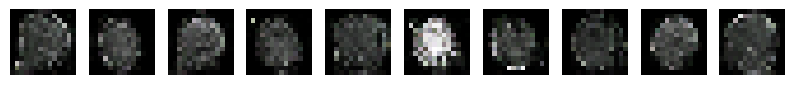

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 1/100 [00:00<00:11,  8.98it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 3/100 [00:00<00:10,  9.69it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 5/100 [00:00<00:09,  9.93it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 6/100 [00:00<00:09,  9.87it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 7/100 [00:00<00:09,  9.84it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 8/100 [00:00<00:09,  9.41it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 9/100 [00:00<00:09,  9.49it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 10/100 [00:01<00:09,  9.60it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 11/100 [00:01<00:09,  9.31it/s]

1/1 [==============================] - 0s 21ms/step


 12%|█▏        | 12/100 [00:01<00:09,  9.47it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 13/100 [00:01<00:09,  9.44it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 14/100 [00:01<00:09,  9.36it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 15/100 [00:01<00:09,  9.39it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 16/100 [00:01<00:08,  9.54it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 18/100 [00:01<00:08,  9.94it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 20/100 [00:02<00:08,  9.94it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 22/100 [00:02<00:07, 10.14it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 24/100 [00:02<00:07, 10.41it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 26/100 [00:02<00:07, 10.51it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 28/100 [00:02<00:06, 10.39it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 30/100 [00:03<00:06, 10.31it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 32/100 [00:03<00:06, 10.41it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 34/100 [00:03<00:06, 10.59it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 36/100 [00:03<00:05, 10.67it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 38/100 [00:03<00:05, 10.62it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 40/100 [00:03<00:05, 10.62it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 42/100 [00:04<00:05, 10.59it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 44/100 [00:04<00:05, 10.61it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 46/100 [00:04<00:05, 10.61it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 48/100 [00:04<00:04, 10.47it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 50/100 [00:04<00:04, 10.06it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 52/100 [00:05<00:04, 10.06it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 54/100 [00:05<00:04, 10.22it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 56/100 [00:05<00:04, 10.43it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 10.56it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 60/100 [00:05<00:03, 10.20it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 62/100 [00:06<00:03, 10.05it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 64/100 [00:06<00:03, 10.12it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 66/100 [00:06<00:03, 10.25it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 68/100 [00:06<00:03, 10.32it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 70/100 [00:06<00:02, 10.18it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 72/100 [00:07<00:02, 10.23it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 74/100 [00:07<00:02, 10.32it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 76/100 [00:07<00:02, 10.33it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 78/100 [00:07<00:02, 10.44it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 80/100 [00:07<00:01, 10.28it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 82/100 [00:08<00:01, 10.45it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 84/100 [00:08<00:01, 10.55it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 86/100 [00:08<00:01, 10.67it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 88/100 [00:08<00:01, 10.68it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 90/100 [00:08<00:00, 10.68it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 11.05it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 94/100 [00:09<00:00, 11.15it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 96/100 [00:09<00:00, 11.17it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 98/100 [00:09<00:00, 11.14it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 1/100 [00:00<00:10,  9.90it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 3/100 [00:00<00:09, 10.16it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 5/100 [00:00<00:09, 10.24it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 7/100 [00:00<00:09, 10.29it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 9/100 [00:00<00:09, 10.06it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 11/100 [00:01<00:08, 10.08it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 13/100 [00:01<00:08, 10.13it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 15/100 [00:01<00:08, 10.18it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 17/100 [00:01<00:08, 10.23it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 19/100 [00:01<00:07, 10.25it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 21/100 [00:02<00:07, 10.05it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 23/100 [00:02<00:07,  9.97it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 24/100 [00:02<00:07,  9.97it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 25/100 [00:02<00:07,  9.70it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 26/100 [00:02<00:07,  9.72it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 28/100 [00:02<00:07,  9.88it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 30/100 [00:03<00:07,  9.73it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 31/100 [00:03<00:07,  9.71it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 32/100 [00:03<00:06,  9.72it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 33/100 [00:03<00:06,  9.74it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 34/100 [00:03<00:06,  9.74it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 35/100 [00:03<00:06,  9.76it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 36/100 [00:03<00:06,  9.66it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 37/100 [00:03<00:06,  9.62it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 38/100 [00:03<00:06,  9.71it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 39/100 [00:03<00:06,  9.26it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 40/100 [00:04<00:06,  8.98it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 41/100 [00:04<00:06,  8.79it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 42/100 [00:04<00:06,  9.06it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 43/100 [00:04<00:06,  9.25it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 44/100 [00:04<00:05,  9.44it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 45/100 [00:04<00:05,  9.53it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 47/100 [00:04<00:05,  9.90it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 49/100 [00:04<00:05, 10.13it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 51/100 [00:05<00:04,  9.97it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 53/100 [00:05<00:04, 10.05it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▌    | 55/100 [00:05<00:04, 10.07it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 57/100 [00:05<00:04, 10.11it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 59/100 [00:05<00:04, 10.14it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 61/100 [00:06<00:03,  9.97it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 63/100 [00:06<00:03, 10.11it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 65/100 [00:06<00:03, 10.17it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 67/100 [00:06<00:03, 10.16it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 69/100 [00:06<00:03, 10.22it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 71/100 [00:07<00:02,  9.99it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 73/100 [00:07<00:02,  9.92it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 74/100 [00:07<00:02,  9.91it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▌  | 75/100 [00:07<00:02,  9.92it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 76/100 [00:07<00:02,  9.87it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 78/100 [00:07<00:02,  9.98it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 79/100 [00:07<00:02,  9.92it/s]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 80/100 [00:08<00:02,  9.52it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 82/100 [00:08<00:01,  9.96it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 84/100 [00:08<00:01, 10.22it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 86/100 [00:08<00:01, 10.10it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 88/100 [00:08<00:01, 10.29it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 90/100 [00:09<00:00, 10.41it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 92/100 [00:09<00:00, 10.45it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 94/100 [00:09<00:00, 10.63it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 96/100 [00:09<00:00, 10.72it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 98/100 [00:09<00:00, 10.84it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 2/100 [00:00<00:08, 10.96it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 4/100 [00:00<00:08, 11.10it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 6/100 [00:00<00:08, 11.28it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 8/100 [00:00<00:08, 11.24it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 10/100 [00:00<00:08, 11.13it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 12/100 [00:01<00:07, 11.17it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 14/100 [00:01<00:07, 11.16it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 16/100 [00:01<00:07, 11.30it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 18/100 [00:01<00:07, 11.21it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 20/100 [00:01<00:07, 10.98it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 22/100 [00:01<00:07, 11.11it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 24/100 [00:02<00:06, 11.13it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 26/100 [00:02<00:06, 11.29it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 28/100 [00:02<00:06, 11.42it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 30/100 [00:02<00:06, 11.29it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 32/100 [00:02<00:06, 11.30it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 34/100 [00:03<00:05, 11.33it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 36/100 [00:03<00:05, 11.27it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 38/100 [00:03<00:05, 11.50it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 40/100 [00:03<00:05, 11.46it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 42/100 [00:03<00:05, 11.46it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 44/100 [00:03<00:04, 11.47it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 46/100 [00:04<00:04, 11.47it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 48/100 [00:04<00:04, 11.36it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 50/100 [00:04<00:04, 11.25it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 11.37it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 54/100 [00:04<00:04, 11.26it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 56/100 [00:04<00:03, 11.24it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 10.62it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 60/100 [00:05<00:03, 10.50it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 10.61it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 10.71it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 66/100 [00:05<00:03, 10.66it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 68/100 [00:06<00:03, 10.52it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 70/100 [00:06<00:02, 10.68it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 10.81it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 10.96it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 10.98it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 78/100 [00:07<00:02, 10.96it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 80/100 [00:07<00:01, 11.03it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 11.24it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 11.36it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 11.44it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 88/100 [00:07<00:01, 11.33it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 90/100 [00:08<00:00, 11.42it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 11.37it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 11.43it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 11.55it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 11.25it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 2/100 [00:00<00:09, 10.80it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 4/100 [00:00<00:08, 10.76it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 6/100 [00:00<00:08, 10.95it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 8/100 [00:00<00:08, 10.86it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 10/100 [00:00<00:08, 10.99it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 12/100 [00:01<00:07, 11.01it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 14/100 [00:01<00:07, 11.00it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 16/100 [00:01<00:07, 11.11it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 18/100 [00:01<00:07, 11.02it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 20/100 [00:01<00:07, 11.07it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 22/100 [00:02<00:07, 10.94it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 24/100 [00:02<00:06, 10.97it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 26/100 [00:02<00:06, 11.00it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 28/100 [00:02<00:06, 10.93it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 30/100 [00:02<00:06, 11.02it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 32/100 [00:02<00:06, 11.09it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 34/100 [00:03<00:05, 11.17it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 36/100 [00:03<00:05, 11.21it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 38/100 [00:03<00:05, 11.20it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 40/100 [00:03<00:05, 11.22it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 42/100 [00:03<00:05, 11.34it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 44/100 [00:03<00:04, 11.33it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 46/100 [00:04<00:04, 11.29it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 48/100 [00:04<00:04, 11.29it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 50/100 [00:04<00:04, 11.34it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 11.49it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 54/100 [00:04<00:03, 11.60it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 56/100 [00:05<00:03, 11.67it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 11.53it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 60/100 [00:05<00:03, 11.63it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 11.71it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 11.80it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 66/100 [00:05<00:02, 11.79it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 68/100 [00:06<00:02, 11.67it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 70/100 [00:06<00:02, 11.39it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 11.61it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 11.70it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 11.84it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 78/100 [00:06<00:01, 11.67it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 80/100 [00:07<00:01, 11.67it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 11.56it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 11.60it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 11.59it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 88/100 [00:07<00:01, 11.27it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 90/100 [00:07<00:00, 11.28it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 11.20it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 11.03it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 11.06it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 10.99it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 2/100 [00:00<00:08, 11.08it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 4/100 [00:00<00:08, 10.89it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 6/100 [00:00<00:08, 11.22it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 8/100 [00:00<00:08, 10.93it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 10/100 [00:00<00:08, 11.08it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 12/100 [00:01<00:07, 11.21it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 14/100 [00:01<00:07, 10.84it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 16/100 [00:01<00:07, 11.06it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 18/100 [00:01<00:07, 10.98it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 20/100 [00:01<00:07, 11.27it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 22/100 [00:01<00:06, 11.37it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 24/100 [00:02<00:06, 11.55it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 26/100 [00:02<00:06, 11.44it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 28/100 [00:02<00:06, 11.30it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 30/100 [00:02<00:06, 11.48it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 32/100 [00:02<00:05, 11.51it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 34/100 [00:03<00:05, 11.52it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 36/100 [00:03<00:05, 11.59it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 38/100 [00:03<00:05, 11.20it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 40/100 [00:03<00:05, 11.24it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 42/100 [00:03<00:05, 11.38it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 44/100 [00:03<00:04, 11.52it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 46/100 [00:04<00:04, 11.56it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 48/100 [00:04<00:04, 11.24it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 50/100 [00:04<00:04, 11.22it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 11.24it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 54/100 [00:04<00:04, 11.15it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 56/100 [00:04<00:03, 11.22it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 11.15it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 60/100 [00:05<00:03, 11.20it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 11.28it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 11.42it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 66/100 [00:05<00:02, 11.57it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 68/100 [00:06<00:02, 11.41it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 70/100 [00:06<00:02, 11.48it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 11.38it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 11.46it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 11.49it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 78/100 [00:06<00:01, 11.35it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 80/100 [00:07<00:01, 11.45it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 11.52it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 11.23it/s]

1/1 [==============================] - 0s 15ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 11.46it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 88/100 [00:07<00:01, 11.37it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 90/100 [00:07<00:00, 11.23it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 11.24it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 11.14it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 11.26it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 11.14it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 2/100 [00:00<00:08, 11.35it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 4/100 [00:00<00:08, 11.68it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 6/100 [00:00<00:08, 11.50it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 8/100 [00:00<00:08, 11.24it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 10/100 [00:00<00:07, 11.37it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 12/100 [00:01<00:07, 11.56it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 14/100 [00:01<00:07, 11.50it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 16/100 [00:01<00:07, 11.43it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 18/100 [00:01<00:07, 11.03it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 20/100 [00:01<00:07, 11.14it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 22/100 [00:01<00:06, 11.24it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 24/100 [00:02<00:06, 11.38it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 26/100 [00:02<00:06, 11.53it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 28/100 [00:02<00:06, 11.40it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 30/100 [00:02<00:06, 11.41it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 32/100 [00:02<00:06, 11.19it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 34/100 [00:03<00:05, 11.04it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 36/100 [00:03<00:05, 11.08it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 38/100 [00:03<00:05, 10.85it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 40/100 [00:03<00:05, 10.81it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 42/100 [00:03<00:05, 10.92it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 44/100 [00:03<00:05, 11.11it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 46/100 [00:04<00:04, 11.21it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 48/100 [00:04<00:04, 10.94it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 50/100 [00:04<00:04, 10.89it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 11.01it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 54/100 [00:04<00:04, 10.93it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 56/100 [00:05<00:04, 10.91it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 10.85it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 60/100 [00:05<00:03, 11.12it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 11.18it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 11.21it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 66/100 [00:05<00:03, 11.32it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 68/100 [00:06<00:02, 11.15it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 70/100 [00:06<00:02, 11.13it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 11.00it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 10.88it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 11.01it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 78/100 [00:07<00:02, 10.83it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 80/100 [00:07<00:01, 10.95it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 10.97it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 11.01it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 11.00it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 88/100 [00:07<00:01, 11.06it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 90/100 [00:08<00:00, 11.08it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 11.20it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 11.18it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 11.12it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 11.07it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 2/100 [00:00<00:08, 11.35it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 4/100 [00:00<00:08, 11.32it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 6/100 [00:00<00:08, 10.97it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 8/100 [00:00<00:08, 10.96it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 10/100 [00:00<00:08, 11.15it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 12/100 [00:01<00:07, 11.19it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 14/100 [00:01<00:07, 11.24it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 16/100 [00:01<00:07, 11.31it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 18/100 [00:01<00:07, 11.24it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 20/100 [00:01<00:07, 11.39it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 22/100 [00:01<00:06, 11.53it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 24/100 [00:02<00:06, 11.50it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 26/100 [00:02<00:06, 11.51it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 28/100 [00:02<00:06, 11.19it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 30/100 [00:02<00:06, 11.28it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 32/100 [00:02<00:06, 11.27it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 34/100 [00:03<00:05, 11.32it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 36/100 [00:03<00:05, 11.30it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 38/100 [00:03<00:05, 11.36it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 40/100 [00:03<00:05, 11.40it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 42/100 [00:03<00:05, 11.50it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 44/100 [00:03<00:04, 11.56it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 46/100 [00:04<00:04, 11.76it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 48/100 [00:04<00:04, 11.64it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 50/100 [00:04<00:04, 11.81it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 11.71it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 54/100 [00:04<00:03, 11.77it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 56/100 [00:04<00:03, 11.76it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 11.67it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 60/100 [00:05<00:03, 11.66it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 11.61it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 11.66it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 66/100 [00:05<00:02, 11.76it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 68/100 [00:05<00:02, 11.35it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 70/100 [00:06<00:02, 11.33it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 11.06it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 10.89it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 11.01it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 78/100 [00:06<00:02, 10.82it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 80/100 [00:07<00:01, 10.82it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 10.92it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 10.88it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 10.77it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 88/100 [00:07<00:01, 10.81it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 90/100 [00:07<00:00, 10.92it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 11.03it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 11.19it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 11.04it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 11.08it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 2/100 [00:00<00:08, 11.41it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 4/100 [00:00<00:08, 11.58it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 6/100 [00:00<00:07, 11.85it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 8/100 [00:00<00:08, 11.32it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 10/100 [00:00<00:07, 11.39it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 12/100 [00:01<00:07, 11.54it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 14/100 [00:01<00:07, 11.67it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 16/100 [00:01<00:07, 11.58it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 18/100 [00:01<00:07, 11.48it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 20/100 [00:01<00:06, 11.44it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 22/100 [00:01<00:06, 11.53it/s]

1/1 [==============================] - 0s 15ms/step


 24%|██▍       | 24/100 [00:02<00:06, 11.65it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 26/100 [00:02<00:06, 11.87it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 28/100 [00:02<00:06, 11.66it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 30/100 [00:02<00:05, 11.72it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 32/100 [00:02<00:05, 11.78it/s]

1/1 [==============================] - 0s 15ms/step


 34%|███▍      | 34/100 [00:02<00:05, 11.92it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 36/100 [00:03<00:05, 11.99it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 38/100 [00:03<00:05, 11.88it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 40/100 [00:03<00:05, 11.87it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 42/100 [00:03<00:04, 11.90it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 44/100 [00:03<00:04, 11.50it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 46/100 [00:03<00:04, 11.64it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 48/100 [00:04<00:04, 11.47it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 50/100 [00:04<00:04, 11.44it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 11.55it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 54/100 [00:04<00:03, 11.61it/s]

1/1 [==============================] - 0s 15ms/step


 56%|█████▌    | 56/100 [00:04<00:03, 11.80it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 58/100 [00:04<00:03, 11.76it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 60/100 [00:05<00:03, 11.62it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 11.50it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 11.44it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 66/100 [00:05<00:02, 11.36it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 68/100 [00:05<00:02, 11.31it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 70/100 [00:06<00:02, 11.47it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 11.60it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 11.69it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 11.71it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 78/100 [00:06<00:01, 11.20it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 80/100 [00:06<00:01, 11.23it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 11.37it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 11.46it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 11.63it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 88/100 [00:07<00:01, 11.44it/s]

1/1 [==============================] - 0s 16ms/step


 90%|█████████ | 90/100 [00:07<00:00, 11.50it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 92/100 [00:07<00:00, 11.58it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 11.52it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 11.49it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 11.32it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 2/100 [00:00<00:08, 11.40it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 4/100 [00:00<00:08, 11.42it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 6/100 [00:00<00:08, 11.45it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 8/100 [00:00<00:08, 11.39it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 10/100 [00:00<00:07, 11.41it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 12/100 [00:01<00:07, 11.34it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 14/100 [00:01<00:07, 11.34it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 16/100 [00:01<00:07, 11.32it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 18/100 [00:01<00:07, 11.21it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 20/100 [00:01<00:07, 11.39it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 22/100 [00:01<00:06, 11.38it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 24/100 [00:02<00:06, 11.45it/s]

1/1 [==============================] - 0s 15ms/step


 26%|██▌       | 26/100 [00:02<00:06, 11.61it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 28/100 [00:02<00:06, 11.47it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 30/100 [00:02<00:06, 11.37it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 32/100 [00:02<00:05, 11.34it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 34/100 [00:02<00:05, 11.16it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 36/100 [00:03<00:05, 11.19it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 38/100 [00:03<00:05, 11.07it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 40/100 [00:03<00:05, 11.14it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 42/100 [00:03<00:05, 11.21it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 44/100 [00:03<00:04, 11.35it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 46/100 [00:04<00:04, 11.27it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 48/100 [00:04<00:04, 11.37it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 50/100 [00:04<00:04, 11.59it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 11.56it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 54/100 [00:04<00:03, 11.52it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 56/100 [00:04<00:03, 11.55it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 11.32it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 60/100 [00:05<00:03, 11.47it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 11.60it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 11.70it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 66/100 [00:05<00:02, 11.80it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 68/100 [00:05<00:02, 11.43it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 70/100 [00:06<00:02, 11.39it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 11.57it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 11.65it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 11.73it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 78/100 [00:06<00:01, 11.56it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 80/100 [00:07<00:01, 11.48it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 11.67it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 11.83it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 11.93it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 88/100 [00:07<00:01, 11.78it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 90/100 [00:07<00:00, 11.85it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 11.80it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 11.87it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 11.89it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 11.82it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 2/100 [00:00<00:08, 11.57it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 4/100 [00:00<00:08, 11.50it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▌         | 6/100 [00:00<00:07, 11.79it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 8/100 [00:00<00:07, 11.63it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 10/100 [00:00<00:07, 11.52it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 12/100 [00:01<00:07, 11.61it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 14/100 [00:01<00:07, 11.57it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 16/100 [00:01<00:07, 11.33it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 18/100 [00:01<00:07, 11.29it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 20/100 [00:01<00:06, 11.45it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 22/100 [00:01<00:06, 11.39it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 24/100 [00:02<00:06, 11.48it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 26/100 [00:02<00:06, 11.37it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 28/100 [00:02<00:06, 11.41it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 30/100 [00:02<00:06, 11.53it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 32/100 [00:02<00:05, 11.49it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 34/100 [00:02<00:05, 11.29it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 36/100 [00:03<00:05, 11.27it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 38/100 [00:03<00:05, 11.24it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 40/100 [00:03<00:05, 11.32it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 42/100 [00:03<00:05, 11.46it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 44/100 [00:03<00:04, 11.46it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 46/100 [00:04<00:04, 11.40it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 48/100 [00:04<00:04, 11.20it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 50/100 [00:04<00:04, 11.11it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 11.13it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 54/100 [00:04<00:04, 11.11it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 56/100 [00:04<00:04, 10.96it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 11.11it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 60/100 [00:05<00:03, 10.91it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 11.13it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 11.17it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 66/100 [00:05<00:03, 11.20it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 68/100 [00:06<00:02, 11.33it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 70/100 [00:06<00:02, 11.07it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 11.06it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 11.04it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 11.15it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 78/100 [00:06<00:01, 11.16it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 80/100 [00:07<00:01, 10.90it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 10.99it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 11.23it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 11.43it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 88/100 [00:07<00:01, 11.54it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 90/100 [00:07<00:00, 11.28it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 11.33it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 11.22it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 11.44it/s]

1/1 [==============================] - 0s 15ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 11.64it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 100/100 [00:08<00:00, 11.31it/s]


Epoch 21, D Loss: 0.6245, D Acc: 68.75%, G Loss: 0.6733
1/1 [==============================] - 0s 17ms/step


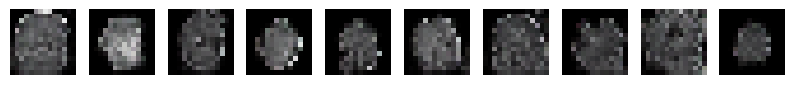

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 2/100 [00:00<00:08, 11.37it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 4/100 [00:00<00:08, 11.39it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 6/100 [00:00<00:08, 11.60it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 8/100 [00:00<00:07, 11.67it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 10/100 [00:00<00:07, 11.68it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 12/100 [00:01<00:07, 11.71it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 14/100 [00:01<00:07, 11.63it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 16/100 [00:01<00:07, 11.75it/s]

1/1 [==============================] - 0s 15ms/step


 18%|█▊        | 18/100 [00:01<00:06, 11.83it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 20/100 [00:01<00:06, 11.88it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 22/100 [00:01<00:06, 11.95it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 24/100 [00:02<00:06, 11.70it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 26/100 [00:02<00:06, 11.72it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 28/100 [00:02<00:06, 11.76it/s]

1/1 [==============================] - 0s 15ms/step


 30%|███       | 30/100 [00:02<00:05, 11.75it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 32/100 [00:02<00:05, 11.73it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 34/100 [00:02<00:05, 11.61it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 36/100 [00:03<00:05, 11.35it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 38/100 [00:03<00:05, 11.13it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 40/100 [00:03<00:05, 11.23it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 42/100 [00:03<00:05, 11.37it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 44/100 [00:03<00:04, 11.30it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 46/100 [00:03<00:04, 11.28it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 48/100 [00:04<00:04, 11.16it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 50/100 [00:04<00:04, 11.32it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 11.45it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 54/100 [00:04<00:04, 11.45it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 56/100 [00:04<00:03, 11.57it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 11.64it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 60/100 [00:05<00:03, 11.57it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 11.74it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 11.63it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 66/100 [00:05<00:02, 11.50it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 68/100 [00:05<00:02, 11.30it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 70/100 [00:06<00:02, 11.24it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 11.12it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 10.87it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 11.01it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 78/100 [00:06<00:01, 11.13it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 80/100 [00:06<00:01, 11.19it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 10.93it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 10.72it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 10.75it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 88/100 [00:07<00:01, 10.83it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 90/100 [00:07<00:00, 10.86it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 10.94it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 10.72it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 10.63it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 10.48it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 2/100 [00:00<00:08, 11.23it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 4/100 [00:00<00:09, 10.62it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 6/100 [00:00<00:08, 10.75it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 8/100 [00:00<00:08, 10.80it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 10/100 [00:00<00:08, 10.87it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 12/100 [00:01<00:08, 10.79it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 14/100 [00:01<00:08, 10.65it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 16/100 [00:01<00:07, 10.80it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 18/100 [00:01<00:07, 11.03it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 20/100 [00:01<00:07, 11.19it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 22/100 [00:01<00:06, 11.36it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 24/100 [00:02<00:06, 11.13it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 26/100 [00:02<00:06, 11.20it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 28/100 [00:02<00:06, 11.36it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 30/100 [00:02<00:06, 11.51it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 32/100 [00:02<00:05, 11.65it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 34/100 [00:03<00:05, 11.68it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 36/100 [00:03<00:05, 11.66it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 38/100 [00:03<00:05, 11.66it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 40/100 [00:03<00:05, 11.77it/s]

1/1 [==============================] - 0s 15ms/step


 42%|████▏     | 42/100 [00:03<00:04, 11.90it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 44/100 [00:03<00:04, 11.72it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 46/100 [00:04<00:04, 11.78it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 48/100 [00:04<00:04, 11.82it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 50/100 [00:04<00:04, 11.83it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 11.91it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 54/100 [00:04<00:03, 11.73it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 56/100 [00:04<00:03, 11.73it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 11.82it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 60/100 [00:05<00:03, 11.80it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 11.77it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 11.69it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 66/100 [00:05<00:02, 11.80it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 68/100 [00:05<00:02, 11.81it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 70/100 [00:06<00:02, 11.87it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 11.89it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 11.71it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 11.69it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 78/100 [00:06<00:01, 11.80it/s]

1/1 [==============================] - 0s 15ms/step


 80%|████████  | 80/100 [00:06<00:01, 11.88it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 11.91it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 11.70it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 11.74it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 88/100 [00:07<00:01, 11.69it/s]

1/1 [==============================] - 0s 16ms/step


 90%|█████████ | 90/100 [00:07<00:00, 11.73it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 92/100 [00:07<00:00, 11.80it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 11.66it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 11.74it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 11.78it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 2/100 [00:00<00:07, 12.33it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 4/100 [00:00<00:08, 11.68it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 6/100 [00:00<00:08, 11.68it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 8/100 [00:00<00:07, 11.55it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 10/100 [00:00<00:07, 11.74it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 12/100 [00:01<00:07, 11.73it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 14/100 [00:01<00:07, 11.54it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 16/100 [00:01<00:07, 11.61it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 18/100 [00:01<00:07, 11.59it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 20/100 [00:01<00:06, 11.54it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 22/100 [00:01<00:06, 11.54it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 24/100 [00:02<00:06, 11.28it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 26/100 [00:02<00:06, 11.40it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 28/100 [00:02<00:06, 11.37it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 30/100 [00:02<00:06, 11.31it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 32/100 [00:02<00:05, 11.40it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 34/100 [00:02<00:05, 11.43it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 36/100 [00:03<00:05, 11.40it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 38/100 [00:03<00:05, 11.37it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 40/100 [00:03<00:05, 11.49it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 42/100 [00:03<00:05, 11.38it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 44/100 [00:03<00:05, 11.07it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 46/100 [00:04<00:04, 11.12it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 48/100 [00:04<00:04, 11.22it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 50/100 [00:04<00:04, 10.92it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 10.76it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 54/100 [00:04<00:04, 10.65it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 56/100 [00:04<00:04, 10.82it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 10.79it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 60/100 [00:05<00:03, 10.69it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 10.56it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 10.77it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 66/100 [00:05<00:03, 11.08it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 68/100 [00:06<00:02, 11.23it/s]

1/1 [==============================] - 0s 15ms/step


 70%|███████   | 70/100 [00:06<00:02, 11.39it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 11.35it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 74/100 [00:07<00:04,  6.13it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 76/100 [00:07<00:03,  7.08it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 78/100 [00:07<00:02,  7.95it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 80/100 [00:07<00:02,  8.62it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 82/100 [00:07<00:01,  9.33it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 84/100 [00:07<00:01,  9.60it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 86/100 [00:08<00:01, 10.04it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 88/100 [00:08<00:01, 10.41it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 90/100 [00:08<00:00, 10.67it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 10.69it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 10.79it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 96/100 [00:09<00:00, 11.01it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 98/100 [00:09<00:00, 11.15it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 2/100 [00:00<00:09, 10.66it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 4/100 [00:00<00:08, 10.93it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 6/100 [00:00<00:08, 11.17it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 8/100 [00:00<00:08, 11.34it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 10/100 [00:00<00:07, 11.42it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 12/100 [00:01<00:07, 11.13it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 14/100 [00:01<00:07, 11.02it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 16/100 [00:01<00:07, 11.17it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 18/100 [00:01<00:07, 11.32it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 20/100 [00:01<00:07, 11.31it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 22/100 [00:01<00:07, 11.02it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 24/100 [00:02<00:07, 10.80it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 26/100 [00:02<00:06, 10.97it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 28/100 [00:02<00:06, 11.04it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 30/100 [00:02<00:06, 11.24it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 32/100 [00:02<00:06, 10.83it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 34/100 [00:03<00:06, 10.89it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 36/100 [00:03<00:05, 10.79it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 38/100 [00:03<00:05, 10.99it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 40/100 [00:03<00:05, 11.06it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 42/100 [00:03<00:05, 10.75it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 44/100 [00:03<00:05, 10.82it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 46/100 [00:04<00:04, 10.87it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 48/100 [00:04<00:04, 10.86it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 50/100 [00:04<00:04, 10.67it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 10.76it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 54/100 [00:04<00:04, 10.83it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 56/100 [00:05<00:04, 10.87it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 10.75it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 60/100 [00:05<00:03, 10.80it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 10.97it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 11.09it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 66/100 [00:06<00:03, 11.16it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 68/100 [00:06<00:02, 10.93it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 70/100 [00:06<00:02, 10.57it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 10.66it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 10.59it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 10.55it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 78/100 [00:07<00:02, 10.66it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 80/100 [00:07<00:01, 10.41it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 10.42it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 10.39it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 10.36it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 88/100 [00:08<00:01, 10.33it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 90/100 [00:08<00:00, 10.14it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 10.32it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 10.59it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 10.75it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 98/100 [00:09<00:00, 10.88it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 2/100 [00:00<00:09, 10.61it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 4/100 [00:00<00:08, 11.06it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 6/100 [00:00<00:08, 11.23it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 8/100 [00:00<00:08, 11.35it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 10/100 [00:00<00:08, 11.07it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 12/100 [00:01<00:08, 11.00it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 14/100 [00:01<00:07, 11.12it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 16/100 [00:01<00:07, 11.20it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 18/100 [00:01<00:07, 11.35it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 20/100 [00:01<00:07, 11.21it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 22/100 [00:01<00:07, 11.12it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 24/100 [00:02<00:06, 11.20it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 26/100 [00:02<00:06, 11.26it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 28/100 [00:02<00:06, 11.34it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 30/100 [00:02<00:06, 11.22it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 32/100 [00:02<00:06, 11.20it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 34/100 [00:03<00:05, 11.07it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 36/100 [00:03<00:05, 11.17it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 38/100 [00:03<00:05, 11.32it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 40/100 [00:03<00:05, 11.18it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 42/100 [00:03<00:05, 11.24it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 44/100 [00:03<00:05, 11.18it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 46/100 [00:04<00:04, 11.31it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 48/100 [00:04<00:04, 11.38it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 50/100 [00:04<00:04, 11.18it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 11.27it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 54/100 [00:04<00:04, 11.26it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 56/100 [00:04<00:03, 11.25it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 11.39it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 60/100 [00:05<00:03, 11.34it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 11.45it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 11.57it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 66/100 [00:05<00:02, 11.53it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 68/100 [00:06<00:02, 11.41it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 70/100 [00:06<00:02, 11.17it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 11.28it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 11.34it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 11.42it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 78/100 [00:06<00:01, 11.35it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 80/100 [00:07<00:01, 11.14it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 11.16it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 11.20it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 11.14it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 88/100 [00:07<00:01, 11.19it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 90/100 [00:08<00:00, 11.01it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 11.09it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 11.31it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 11.44it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 11.46it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 2/100 [00:00<00:08, 10.99it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 4/100 [00:00<00:08, 11.29it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 6/100 [00:00<00:08, 11.06it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 8/100 [00:00<00:08, 11.05it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 10/100 [00:00<00:08, 10.82it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 12/100 [00:01<00:08, 10.79it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 14/100 [00:01<00:07, 10.76it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 16/100 [00:01<00:07, 10.93it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 18/100 [00:01<00:07, 10.87it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 20/100 [00:01<00:07, 10.68it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 22/100 [00:02<00:07, 10.53it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 24/100 [00:02<00:07, 10.52it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 26/100 [00:02<00:06, 10.71it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 28/100 [00:02<00:06, 10.73it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 30/100 [00:02<00:06, 10.70it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 32/100 [00:02<00:06, 10.80it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 34/100 [00:03<00:06, 10.90it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 36/100 [00:03<00:05, 11.09it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 38/100 [00:03<00:05, 11.26it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 40/100 [00:03<00:05, 11.22it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 42/100 [00:03<00:05, 11.30it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 44/100 [00:04<00:04, 11.27it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 46/100 [00:04<00:04, 11.30it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 48/100 [00:04<00:04, 11.41it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 50/100 [00:04<00:04, 11.32it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 11.38it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 54/100 [00:04<00:04, 11.42it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 56/100 [00:05<00:03, 11.45it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 11.59it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 60/100 [00:05<00:03, 11.44it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 11.53it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 11.65it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 66/100 [00:05<00:02, 11.66it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 68/100 [00:06<00:02, 11.61it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 70/100 [00:06<00:02, 11.51it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 11.55it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 11.65it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 11.76it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 78/100 [00:06<00:01, 11.71it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 80/100 [00:07<00:01, 11.38it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 11.47it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 11.63it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 11.69it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 88/100 [00:07<00:01, 11.81it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 90/100 [00:07<00:00, 11.56it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 11.41it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 11.42it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 11.46it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 11.48it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 2/100 [00:00<00:08, 10.92it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 4/100 [00:00<00:08, 11.13it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 6/100 [00:00<00:08, 11.14it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 8/100 [00:00<00:08, 11.12it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 10/100 [00:00<00:07, 11.30it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 12/100 [00:01<00:07, 11.46it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 14/100 [00:01<00:07, 11.41it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 16/100 [00:01<00:07, 11.46it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 18/100 [00:01<00:07, 11.30it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 20/100 [00:01<00:07, 11.34it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 22/100 [00:01<00:06, 11.34it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 24/100 [00:02<00:06, 11.24it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 26/100 [00:02<00:06, 11.28it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 28/100 [00:02<00:06, 11.19it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 30/100 [00:02<00:06, 11.43it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 32/100 [00:02<00:05, 11.55it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 34/100 [00:02<00:05, 11.61it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 36/100 [00:03<00:05, 11.55it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 38/100 [00:03<00:05, 11.29it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 40/100 [00:03<00:05, 11.31it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 42/100 [00:03<00:05, 11.45it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 44/100 [00:03<00:04, 11.38it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 46/100 [00:04<00:04, 10.98it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 48/100 [00:04<00:04, 10.70it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 50/100 [00:04<00:04, 10.78it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 10.83it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 54/100 [00:04<00:04, 10.81it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 56/100 [00:05<00:04, 10.87it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 10.70it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 60/100 [00:05<00:03, 10.84it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 10.86it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 10.95it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 66/100 [00:05<00:03, 11.09it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 68/100 [00:06<00:03, 10.52it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 70/100 [00:06<00:02, 10.51it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 10.70it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 10.97it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 11.11it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 78/100 [00:07<00:02, 10.99it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 80/100 [00:07<00:01, 10.99it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 11.17it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 11.27it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 11.35it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 88/100 [00:07<00:01, 11.19it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 90/100 [00:08<00:00, 11.19it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 11.14it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 11.29it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 11.45it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 11.21it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 2/100 [00:00<00:08, 11.03it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 4/100 [00:00<00:08, 11.35it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 6/100 [00:00<00:08, 11.35it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 8/100 [00:00<00:08, 11.12it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 10/100 [00:00<00:07, 11.34it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 12/100 [00:01<00:07, 11.53it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 14/100 [00:01<00:07, 11.52it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 16/100 [00:01<00:07, 11.62it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 18/100 [00:01<00:07, 11.46it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 20/100 [00:01<00:06, 11.56it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 22/100 [00:01<00:06, 11.63it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 24/100 [00:02<00:06, 11.60it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 26/100 [00:02<00:06, 11.43it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 28/100 [00:02<00:06, 11.30it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 30/100 [00:02<00:06, 11.46it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 32/100 [00:02<00:05, 11.49it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 34/100 [00:02<00:05, 11.36it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 36/100 [00:03<00:05, 11.39it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 38/100 [00:03<00:05, 11.13it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 40/100 [00:03<00:05, 11.04it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 42/100 [00:03<00:05, 10.98it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 44/100 [00:03<00:05, 11.06it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 46/100 [00:04<00:04, 11.22it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 48/100 [00:04<00:04, 10.99it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 50/100 [00:04<00:04, 11.16it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 11.31it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 54/100 [00:04<00:04, 11.32it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 56/100 [00:04<00:03, 11.26it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 11.03it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 60/100 [00:05<00:03, 10.98it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 10.98it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 11.22it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 66/100 [00:05<00:02, 11.40it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 68/100 [00:06<00:02, 11.24it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 70/100 [00:06<00:02, 11.18it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 11.32it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 11.30it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 11.29it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 78/100 [00:06<00:01, 11.08it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 80/100 [00:07<00:01, 11.20it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 11.14it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 11.14it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 11.04it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 88/100 [00:07<00:01, 10.79it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 90/100 [00:08<00:00, 10.78it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 10.81it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 11.05it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 11.25it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 11.23it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 2/100 [00:00<00:08, 11.29it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 4/100 [00:00<00:08, 11.05it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 6/100 [00:00<00:08, 11.16it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 8/100 [00:00<00:08, 10.97it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 10/100 [00:00<00:08, 11.09it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 12/100 [00:01<00:07, 11.21it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 14/100 [00:01<00:07, 11.37it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 16/100 [00:01<00:07, 11.41it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 18/100 [00:01<00:07, 11.41it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 20/100 [00:01<00:07, 11.42it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 22/100 [00:01<00:06, 11.40it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 24/100 [00:02<00:06, 11.44it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 26/100 [00:02<00:06, 11.43it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 28/100 [00:02<00:06, 11.18it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 30/100 [00:02<00:06, 11.35it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 32/100 [00:02<00:05, 11.35it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 34/100 [00:03<00:05, 11.46it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 36/100 [00:03<00:05, 11.51it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 38/100 [00:03<00:05, 11.15it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 40/100 [00:03<00:05, 11.19it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 42/100 [00:03<00:05, 11.23it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 44/100 [00:03<00:04, 11.35it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 46/100 [00:04<00:04, 11.42it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 48/100 [00:04<00:04, 10.95it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 50/100 [00:04<00:04, 10.97it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 11.18it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 54/100 [00:04<00:04, 11.32it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 56/100 [00:04<00:03, 11.44it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 11.18it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 60/100 [00:05<00:03, 11.33it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 11.49it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 11.48it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 66/100 [00:05<00:02, 11.49it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 68/100 [00:06<00:02, 11.39it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 70/100 [00:06<00:02, 11.44it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 11.48it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 11.49it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 11.55it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 78/100 [00:06<00:01, 11.27it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 80/100 [00:07<00:01, 11.37it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 11.24it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 11.15it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 11.29it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 88/100 [00:07<00:01, 11.26it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 90/100 [00:07<00:00, 11.22it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 11.23it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 11.09it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 11.15it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 11.05it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 2/100 [00:00<00:08, 11.75it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 4/100 [00:00<00:08, 11.38it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 6/100 [00:00<00:08, 11.52it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 8/100 [00:00<00:08, 11.39it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 10/100 [00:00<00:07, 11.43it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 12/100 [00:01<00:07, 11.41it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 14/100 [00:01<00:07, 11.48it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 16/100 [00:01<00:07, 11.45it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 18/100 [00:01<00:07, 11.14it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 20/100 [00:01<00:07, 11.15it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 22/100 [00:01<00:06, 11.21it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 24/100 [00:02<00:06, 11.07it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 26/100 [00:02<00:06, 10.98it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 28/100 [00:02<00:06, 10.86it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 30/100 [00:02<00:06, 10.98it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 32/100 [00:02<00:06, 11.14it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 34/100 [00:03<00:05, 11.16it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 36/100 [00:03<00:05, 11.21it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 38/100 [00:03<00:05, 11.05it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 40/100 [00:03<00:05, 11.07it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 42/100 [00:03<00:05, 11.07it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 44/100 [00:03<00:05, 11.09it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 46/100 [00:04<00:05, 10.79it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 48/100 [00:04<00:04, 10.67it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 50/100 [00:04<00:04, 10.61it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 10.94it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 54/100 [00:04<00:04, 11.17it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 56/100 [00:05<00:03, 11.36it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 11.37it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 60/100 [00:05<00:03, 11.44it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 11.42it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 11.54it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 66/100 [00:05<00:02, 11.61it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 68/100 [00:06<00:02, 11.45it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 70/100 [00:06<00:02, 11.58it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 11.44it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 11.44it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 11.42it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 78/100 [00:06<00:01, 11.37it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 80/100 [00:07<00:01, 11.28it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 11.43it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 11.41it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 11.47it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 88/100 [00:07<00:01, 11.37it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 90/100 [00:07<00:00, 11.35it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 11.40it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 11.20it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 11.19it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 11.24it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 100/100 [00:08<00:00, 11.26it/s]


Epoch 31, D Loss: 0.5741, D Acc: 71.88%, G Loss: 1.0945
1/1 [==============================] - 0s 19ms/step


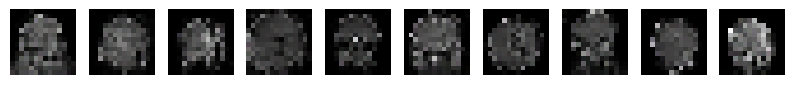

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 2/100 [00:00<00:08, 10.98it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 4/100 [00:00<00:08, 11.33it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 6/100 [00:00<00:08, 11.51it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 8/100 [00:00<00:07, 11.57it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 10/100 [00:00<00:07, 11.48it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 12/100 [00:01<00:07, 11.31it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 14/100 [00:01<00:07, 11.30it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 16/100 [00:01<00:07, 11.40it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 18/100 [00:01<00:07, 11.42it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 20/100 [00:01<00:07, 11.39it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 22/100 [00:01<00:06, 11.37it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 24/100 [00:02<00:06, 11.44it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 26/100 [00:02<00:06, 11.21it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 28/100 [00:02<00:06, 11.33it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 30/100 [00:02<00:06, 11.39it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 32/100 [00:02<00:06, 11.26it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 34/100 [00:02<00:05, 11.46it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 36/100 [00:03<00:05, 11.38it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 38/100 [00:03<00:05, 11.40it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 40/100 [00:03<00:05, 11.47it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 42/100 [00:03<00:05, 11.36it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 44/100 [00:03<00:04, 11.39it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 46/100 [00:04<00:04, 11.48it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 48/100 [00:04<00:04, 11.49it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 50/100 [00:04<00:04, 11.36it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 11.25it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 54/100 [00:04<00:04, 11.38it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 56/100 [00:04<00:03, 11.42it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 11.53it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 60/100 [00:05<00:03, 11.63it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 11.43it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 11.29it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 66/100 [00:05<00:03, 11.24it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 68/100 [00:05<00:02, 11.22it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 70/100 [00:06<00:02, 11.03it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 10.75it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 10.86it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 10.82it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 78/100 [00:06<00:02, 10.68it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 80/100 [00:07<00:01, 10.73it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 10.63it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 10.73it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 10.73it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 88/100 [00:07<00:01, 10.82it/s]

1/1 [==============================] - 0s 16ms/step


 90%|█████████ | 90/100 [00:08<00:00, 11.08it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 11.08it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 11.26it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 11.40it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 11.48it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 2/100 [00:00<00:08, 11.35it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 4/100 [00:00<00:08, 11.08it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 6/100 [00:00<00:08, 11.33it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 8/100 [00:00<00:07, 11.56it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 10/100 [00:00<00:07, 11.68it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 12/100 [00:01<00:07, 11.54it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 14/100 [00:01<00:07, 11.64it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 16/100 [00:01<00:07, 11.44it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 18/100 [00:01<00:07, 11.63it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 20/100 [00:01<00:06, 11.66it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 22/100 [00:01<00:06, 11.52it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 24/100 [00:02<00:06, 11.48it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 26/100 [00:02<00:06, 11.51it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 28/100 [00:02<00:06, 11.38it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 30/100 [00:02<00:06, 11.53it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 32/100 [00:02<00:05, 11.43it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 34/100 [00:02<00:05, 11.49it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 36/100 [00:03<00:05, 11.63it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 38/100 [00:03<00:05, 11.65it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 40/100 [00:03<00:05, 11.39it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 42/100 [00:03<00:05, 11.31it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 44/100 [00:03<00:04, 11.39it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 46/100 [00:04<00:04, 11.37it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 48/100 [00:04<00:04, 11.42it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 50/100 [00:04<00:04, 11.29it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 11.29it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 54/100 [00:04<00:04, 11.26it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 56/100 [00:04<00:03, 11.31it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 11.31it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 60/100 [00:05<00:03, 11.29it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 11.09it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 11.21it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 66/100 [00:05<00:03, 11.27it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 68/100 [00:05<00:02, 11.31it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 70/100 [00:06<00:02, 11.28it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 11.10it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 11.02it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 11.00it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 78/100 [00:06<00:02, 10.98it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 80/100 [00:07<00:01, 11.10it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 10.94it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 10.95it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 10.91it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 88/100 [00:07<00:01, 11.15it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 90/100 [00:07<00:00, 11.25it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 11.34it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 11.47it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 11.46it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 11.51it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 2/100 [00:00<00:08, 11.06it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 4/100 [00:00<00:08, 11.37it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 6/100 [00:00<00:08, 11.49it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 8/100 [00:00<00:08, 11.38it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 10/100 [00:00<00:07, 11.45it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 12/100 [00:01<00:07, 11.19it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 14/100 [00:01<00:07, 11.21it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 16/100 [00:01<00:07, 11.36it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 18/100 [00:01<00:07, 11.26it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 20/100 [00:01<00:07, 11.35it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 22/100 [00:01<00:06, 11.19it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 24/100 [00:02<00:06, 11.24it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 26/100 [00:02<00:06, 11.32it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 28/100 [00:02<00:06, 11.24it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 30/100 [00:02<00:06, 11.41it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 32/100 [00:02<00:05, 11.48it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 34/100 [00:02<00:05, 11.65it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 36/100 [00:03<00:05, 11.73it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 38/100 [00:03<00:05, 11.88it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 40/100 [00:03<00:05, 11.91it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 42/100 [00:03<00:04, 11.67it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 44/100 [00:03<00:04, 11.68it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 46/100 [00:04<00:04, 11.81it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 48/100 [00:04<00:04, 11.83it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 50/100 [00:04<00:04, 11.73it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 11.52it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 54/100 [00:04<00:03, 11.54it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 56/100 [00:04<00:03, 11.61it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 11.60it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 60/100 [00:05<00:03, 11.77it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 11.72it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 11.55it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 66/100 [00:05<00:02, 11.65it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 68/100 [00:05<00:02, 11.71it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 70/100 [00:06<00:02, 11.75it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 11.61it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 11.67it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 11.57it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 78/100 [00:06<00:01, 11.72it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 80/100 [00:06<00:01, 11.80it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 11.59it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 11.45it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 11.49it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 88/100 [00:07<00:01, 11.48it/s]

1/1 [==============================] - 0s 16ms/step


 90%|█████████ | 90/100 [00:07<00:00, 11.47it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 92/100 [00:07<00:00, 11.33it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 11.25it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 11.17it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 11.23it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 2/100 [00:00<00:09, 10.79it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 4/100 [00:00<00:08, 11.05it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 6/100 [00:00<00:08, 11.01it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 8/100 [00:00<00:08, 11.09it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 10/100 [00:00<00:08, 11.15it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 12/100 [00:01<00:07, 11.13it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 14/100 [00:01<00:07, 11.21it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 16/100 [00:01<00:07, 11.40it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 18/100 [00:01<00:07, 11.46it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 20/100 [00:01<00:06, 11.58it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 22/100 [00:01<00:06, 11.30it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 24/100 [00:02<00:06, 11.33it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 26/100 [00:02<00:06, 11.41it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 28/100 [00:02<00:06, 11.41it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 30/100 [00:02<00:06, 11.55it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 32/100 [00:02<00:05, 11.44it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 34/100 [00:02<00:05, 11.52it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 36/100 [00:03<00:05, 11.69it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 38/100 [00:03<00:05, 11.74it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 40/100 [00:03<00:05, 11.84it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 42/100 [00:03<00:04, 11.70it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 44/100 [00:03<00:04, 11.50it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 46/100 [00:04<00:04, 11.56it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 48/100 [00:04<00:04, 11.66it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 50/100 [00:04<00:04, 11.67it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 11.52it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 54/100 [00:04<00:04, 11.39it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 56/100 [00:04<00:03, 11.27it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 11.49it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 60/100 [00:05<00:03, 11.49it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 11.26it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 11.35it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 66/100 [00:05<00:03, 11.25it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 68/100 [00:05<00:02, 11.21it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 70/100 [00:06<00:02, 11.05it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 11.22it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 11.34it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 11.53it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 78/100 [00:06<00:01, 11.48it/s]

1/1 [==============================] - 0s 16ms/step


 80%|████████  | 80/100 [00:07<00:01, 11.60it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 11.47it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 11.57it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 11.71it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 88/100 [00:07<00:01, 11.79it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 90/100 [00:07<00:00, 11.52it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 11.45it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 11.61it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 11.72it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 11.83it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 2/100 [00:00<00:09, 10.40it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 4/100 [00:00<00:08, 11.39it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 6/100 [00:00<00:08, 11.62it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 8/100 [00:00<00:07, 11.55it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 10/100 [00:00<00:07, 11.55it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 12/100 [00:01<00:07, 11.33it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 14/100 [00:01<00:07, 11.41it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 16/100 [00:01<00:07, 11.66it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 18/100 [00:01<00:06, 11.73it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 20/100 [00:01<00:06, 11.76it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 22/100 [00:01<00:06, 11.55it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 24/100 [00:02<00:06, 11.46it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 26/100 [00:02<00:06, 11.47it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 28/100 [00:02<00:06, 11.59it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 30/100 [00:02<00:06, 11.48it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 32/100 [00:02<00:05, 11.37it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 34/100 [00:02<00:05, 11.39it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 36/100 [00:03<00:05, 11.22it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 38/100 [00:03<00:05, 10.98it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 40/100 [00:03<00:05, 11.03it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 42/100 [00:03<00:05, 10.94it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 44/100 [00:03<00:05, 10.92it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 46/100 [00:04<00:04, 10.96it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 48/100 [00:04<00:04, 11.09it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 50/100 [00:04<00:04, 11.08it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 11.15it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 54/100 [00:04<00:04, 11.29it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 56/100 [00:04<00:03, 11.42it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 11.36it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 60/100 [00:05<00:03, 11.33it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 11.31it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 11.36it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 66/100 [00:05<00:02, 11.47it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 68/100 [00:05<00:02, 11.65it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 70/100 [00:06<00:02, 11.75it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 11.71it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 11.84it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 11.86it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 78/100 [00:06<00:01, 11.96it/s]

1/1 [==============================] - 0s 15ms/step


 80%|████████  | 80/100 [00:06<00:01, 11.89it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 11.69it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 11.78it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 11.72it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 88/100 [00:07<00:01, 11.65it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 90/100 [00:07<00:00, 11.70it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 11.63it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 11.74it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 11.78it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 11.83it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 2/100 [00:00<00:09, 10.85it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 4/100 [00:00<00:08, 11.33it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 6/100 [00:00<00:08, 11.16it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 8/100 [00:00<00:08, 11.35it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 10/100 [00:00<00:07, 11.42it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 12/100 [00:01<00:08, 10.96it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 14/100 [00:01<00:07, 11.13it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 16/100 [00:01<00:07, 11.29it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 18/100 [00:01<00:07, 11.52it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 20/100 [00:01<00:06, 11.73it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 22/100 [00:01<00:06, 11.65it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 24/100 [00:02<00:06, 11.80it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 26/100 [00:02<00:06, 11.85it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 28/100 [00:02<00:06, 11.89it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 30/100 [00:02<00:05, 11.79it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 32/100 [00:02<00:05, 11.69it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 34/100 [00:02<00:05, 11.70it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 36/100 [00:03<00:05, 11.74it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 38/100 [00:03<00:05, 11.76it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 40/100 [00:03<00:05, 11.19it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 42/100 [00:03<00:05, 11.18it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 44/100 [00:03<00:04, 11.23it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 46/100 [00:04<00:04, 11.23it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 48/100 [00:04<00:04, 11.35it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 50/100 [00:04<00:04, 11.29it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 11.11it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 54/100 [00:04<00:04, 11.29it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 56/100 [00:04<00:03, 11.46it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 11.58it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 60/100 [00:05<00:03, 11.50it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 11.36it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 11.36it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 66/100 [00:05<00:03, 11.31it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 68/100 [00:05<00:02, 11.42it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 70/100 [00:06<00:02, 11.54it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 11.48it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 11.33it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 11.40it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 78/100 [00:06<00:01, 11.34it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 80/100 [00:07<00:01, 11.23it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 11.01it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 10.81it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 10.64it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 88/100 [00:07<00:01, 10.66it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 90/100 [00:07<00:00, 10.81it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 10.60it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 10.82it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 10.67it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 10.86it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 2/100 [00:00<00:09, 10.53it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 4/100 [00:00<00:08, 10.79it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 6/100 [00:00<00:08, 10.95it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 8/100 [00:00<00:08, 11.21it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 10/100 [00:00<00:08, 11.22it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 12/100 [00:01<00:07, 11.10it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 14/100 [00:01<00:07, 11.15it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 16/100 [00:01<00:07, 11.26it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 18/100 [00:01<00:07, 11.16it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 20/100 [00:01<00:07, 11.40it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 22/100 [00:01<00:06, 11.36it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 24/100 [00:02<00:06, 11.47it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 26/100 [00:02<00:06, 11.51it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 28/100 [00:02<00:06, 11.46it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 30/100 [00:02<00:06, 11.31it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 32/100 [00:02<00:06, 11.22it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 34/100 [00:03<00:05, 11.24it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 36/100 [00:03<00:05, 11.22it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 38/100 [00:03<00:05, 11.31it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 40/100 [00:03<00:05, 11.21it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 42/100 [00:03<00:05, 10.54it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 44/100 [00:03<00:05, 10.52it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 46/100 [00:04<00:05, 10.61it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 48/100 [00:04<00:04, 10.63it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 50/100 [00:04<00:04, 10.88it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 10.83it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 54/100 [00:04<00:04, 11.09it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 56/100 [00:05<00:03, 11.25it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 11.48it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 60/100 [00:05<00:03, 11.54it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 11.42it/s]

1/1 [==============================] - 0s 15ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 11.48it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 66/100 [00:05<00:02, 11.58it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 68/100 [00:06<00:02, 11.63it/s]

1/1 [==============================] - 0s 15ms/step


 70%|███████   | 70/100 [00:06<00:02, 11.62it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 11.55it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 11.55it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 11.52it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 78/100 [00:06<00:01, 11.64it/s]

1/1 [==============================] - 0s 15ms/step


 80%|████████  | 80/100 [00:07<00:01, 11.66it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 11.59it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 11.60it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 11.36it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 88/100 [00:07<00:01, 11.42it/s]

1/1 [==============================] - 0s 16ms/step


 90%|█████████ | 90/100 [00:07<00:00, 11.52it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 11.41it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 11.38it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 11.44it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 11.36it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 2/100 [00:00<00:09, 10.79it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 4/100 [00:00<00:08, 11.04it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 6/100 [00:00<00:08, 11.54it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 8/100 [00:00<00:07, 11.52it/s]

1/1 [==============================] - 0s 15ms/step


 10%|█         | 10/100 [00:00<00:07, 11.61it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 12/100 [00:01<00:07, 11.44it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 14/100 [00:01<00:07, 11.40it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 16/100 [00:01<00:07, 11.26it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 18/100 [00:01<00:07, 11.25it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 20/100 [00:01<00:07, 11.03it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 22/100 [00:01<00:07, 10.96it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 24/100 [00:02<00:06, 11.04it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 26/100 [00:02<00:06, 11.28it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 28/100 [00:02<00:06, 11.45it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 30/100 [00:02<00:06, 11.41it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 32/100 [00:02<00:06, 11.30it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 34/100 [00:03<00:05, 11.36it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 36/100 [00:03<00:05, 11.21it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 38/100 [00:03<00:05, 11.25it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 40/100 [00:03<00:05, 11.42it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 42/100 [00:03<00:05, 11.26it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 44/100 [00:03<00:04, 11.29it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 46/100 [00:04<00:04, 11.27it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 48/100 [00:04<00:04, 11.28it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 50/100 [00:04<00:04, 11.46it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 11.30it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 54/100 [00:04<00:04, 11.28it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 56/100 [00:04<00:03, 11.43it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 11.53it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 60/100 [00:05<00:03, 11.51it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 11.59it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 11.66it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 66/100 [00:05<00:02, 11.53it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 68/100 [00:05<00:02, 11.46it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 70/100 [00:06<00:02, 11.45it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 11.29it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 11.41it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 11.45it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 78/100 [00:06<00:01, 11.58it/s]

1/1 [==============================] - 0s 16ms/step


 80%|████████  | 80/100 [00:07<00:01, 11.60it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 11.56it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 11.43it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 11.49it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 88/100 [00:07<00:01, 11.36it/s]

1/1 [==============================] - 0s 16ms/step


 90%|█████████ | 90/100 [00:07<00:00, 11.45it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 11.30it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 11.37it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 11.60it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 11.81it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 2/100 [00:00<00:08, 11.71it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 4/100 [00:00<00:07, 12.00it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 6/100 [00:00<00:07, 11.99it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 8/100 [00:00<00:07, 12.06it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 10/100 [00:00<00:07, 12.08it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 12/100 [00:01<00:07, 11.75it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 14/100 [00:01<00:07, 11.79it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 16/100 [00:01<00:07, 11.80it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 18/100 [00:01<00:06, 11.81it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 20/100 [00:01<00:06, 11.87it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 22/100 [00:01<00:06, 11.69it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 24/100 [00:02<00:12,  6.09it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 26/100 [00:02<00:10,  7.01it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 28/100 [00:02<00:09,  7.88it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 30/100 [00:03<00:08,  8.63it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 32/100 [00:03<00:07,  9.17it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 34/100 [00:03<00:06,  9.48it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 36/100 [00:03<00:06,  9.81it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 38/100 [00:03<00:06, 10.13it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 40/100 [00:04<00:05, 10.27it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 42/100 [00:04<00:05, 10.33it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 44/100 [00:04<00:05, 10.48it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 46/100 [00:04<00:05, 10.28it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 48/100 [00:04<00:05, 10.39it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 50/100 [00:04<00:04, 10.39it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 52/100 [00:05<00:04, 10.22it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 54/100 [00:05<00:04, 10.24it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 56/100 [00:05<00:04, 10.47it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 10.66it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 60/100 [00:05<00:03, 10.64it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 62/100 [00:06<00:03, 10.50it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 64/100 [00:06<00:03, 10.59it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 66/100 [00:06<00:03, 10.72it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 68/100 [00:06<00:02, 10.83it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 70/100 [00:06<00:02, 10.66it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 72/100 [00:07<00:02, 10.71it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 74/100 [00:07<00:02, 10.78it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 76/100 [00:07<00:02, 10.93it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 78/100 [00:07<00:01, 11.08it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 80/100 [00:07<00:01, 11.02it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 10.91it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 84/100 [00:08<00:01, 10.97it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 86/100 [00:08<00:01, 11.04it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 88/100 [00:08<00:01, 11.10it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 90/100 [00:08<00:00, 10.88it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 10.83it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 94/100 [00:09<00:00, 10.76it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 96/100 [00:09<00:00, 10.93it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 98/100 [00:09<00:00, 10.95it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 1/100 [00:00<00:10,  9.20it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 3/100 [00:00<00:09, 10.10it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 4/100 [00:00<00:09,  9.91it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 6/100 [00:00<00:08, 10.46it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 8/100 [00:00<00:08, 10.76it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 10/100 [00:00<00:08, 10.58it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 12/100 [00:01<00:08, 10.77it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 14/100 [00:01<00:08, 10.57it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 16/100 [00:01<00:07, 10.65it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 18/100 [00:01<00:07, 10.66it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 20/100 [00:01<00:07, 10.47it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 22/100 [00:02<00:07, 10.58it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 24/100 [00:02<00:07, 10.59it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 26/100 [00:02<00:06, 10.86it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 28/100 [00:02<00:06, 11.00it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 30/100 [00:02<00:06, 10.77it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 32/100 [00:02<00:06, 10.91it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 34/100 [00:03<00:06, 10.91it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 36/100 [00:03<00:05, 11.05it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 38/100 [00:03<00:05, 11.17it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 40/100 [00:03<00:05, 10.98it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 42/100 [00:03<00:05, 11.05it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 44/100 [00:04<00:05, 11.15it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 46/100 [00:04<00:04, 11.23it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 48/100 [00:04<00:04, 11.18it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 50/100 [00:04<00:04, 11.11it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 11.16it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 54/100 [00:04<00:04, 11.19it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 56/100 [00:05<00:03, 11.34it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 11.19it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 60/100 [00:05<00:03, 11.09it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 11.22it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 11.16it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 66/100 [00:06<00:03, 11.18it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 68/100 [00:06<00:02, 11.23it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 70/100 [00:06<00:02, 11.02it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 11.03it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 10.97it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 11.02it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 78/100 [00:07<00:01, 11.00it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 80/100 [00:07<00:01, 10.65it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 10.68it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 10.71it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 10.75it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 88/100 [00:08<00:01, 10.93it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 90/100 [00:08<00:00, 10.58it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 10.72it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 10.83it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 10.99it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 11.13it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 100/100 [00:09<00:00, 10.91it/s]


Epoch 41, D Loss: 0.4658, D Acc: 87.50%, G Loss: 1.1098
1/1 [==============================] - 0s 24ms/step


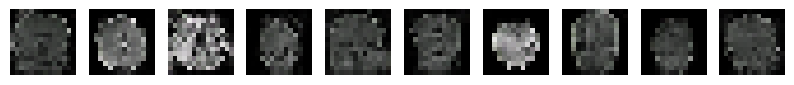

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 2/100 [00:00<00:09, 10.70it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 4/100 [00:00<00:09, 10.63it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 6/100 [00:00<00:08, 10.76it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 8/100 [00:00<00:08, 10.86it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 10/100 [00:00<00:08, 10.85it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 12/100 [00:01<00:07, 11.06it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 14/100 [00:01<00:07, 10.98it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 16/100 [00:01<00:07, 11.11it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 18/100 [00:01<00:07, 11.24it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 20/100 [00:01<00:07, 11.17it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 22/100 [00:01<00:06, 11.26it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 24/100 [00:02<00:06, 11.00it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 26/100 [00:02<00:06, 10.79it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 28/100 [00:02<00:06, 10.85it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 30/100 [00:02<00:06, 11.07it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 32/100 [00:02<00:06, 10.86it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 34/100 [00:03<00:06, 10.71it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 36/100 [00:03<00:05, 10.73it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 38/100 [00:03<00:05, 10.76it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 40/100 [00:03<00:05, 10.94it/s]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 42/100 [00:03<00:05, 10.52it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 44/100 [00:04<00:05, 10.52it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 46/100 [00:04<00:05, 10.55it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 48/100 [00:04<00:04, 10.61it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 50/100 [00:04<00:04, 10.64it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 10.45it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 54/100 [00:05<00:04, 10.36it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 56/100 [00:05<00:04, 10.29it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 58/100 [00:05<00:04, 10.48it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 60/100 [00:05<00:03, 10.63it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 10.41it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 10.51it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 66/100 [00:06<00:03, 10.62it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 68/100 [00:06<00:03, 10.65it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 70/100 [00:06<00:02, 10.84it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 10.57it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 10.57it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 76/100 [00:07<00:02, 10.76it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 78/100 [00:07<00:02, 10.86it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 80/100 [00:07<00:01, 10.98it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 10.83it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 10.92it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 11.00it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 88/100 [00:08<00:01, 11.07it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 90/100 [00:08<00:00, 11.10it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 10.87it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 10.82it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 10.83it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 98/100 [00:09<00:00, 10.84it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 1/100 [00:00<00:10,  9.29it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 2/100 [00:00<00:10,  9.30it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 4/100 [00:00<00:09, 10.22it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 6/100 [00:00<00:09, 10.41it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 8/100 [00:00<00:08, 10.40it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 10/100 [00:00<00:08, 10.45it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 12/100 [00:01<00:08, 10.42it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 14/100 [00:01<00:08, 10.61it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 16/100 [00:01<00:07, 10.72it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 18/100 [00:01<00:07, 10.87it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 20/100 [00:01<00:07, 10.91it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 22/100 [00:02<00:07, 10.80it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 24/100 [00:02<00:06, 10.97it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 26/100 [00:02<00:06, 11.08it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 28/100 [00:02<00:06, 11.13it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 30/100 [00:02<00:06, 11.19it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 32/100 [00:02<00:06, 11.13it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 34/100 [00:03<00:05, 11.06it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 36/100 [00:03<00:05, 11.10it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 38/100 [00:03<00:05, 11.07it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 40/100 [00:03<00:05, 11.06it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 42/100 [00:03<00:05, 10.97it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 44/100 [00:04<00:05, 11.08it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 46/100 [00:04<00:04, 11.20it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 48/100 [00:04<00:04, 11.15it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 50/100 [00:04<00:04, 11.27it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 11.14it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 54/100 [00:04<00:04, 11.28it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 56/100 [00:05<00:03, 11.39it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 11.38it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 60/100 [00:05<00:03, 11.37it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 11.23it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 11.09it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 66/100 [00:06<00:03, 11.08it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 68/100 [00:06<00:02, 11.01it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 70/100 [00:06<00:02, 11.14it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 10.75it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 10.79it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 10.86it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 78/100 [00:07<00:02, 10.96it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 80/100 [00:07<00:01, 10.96it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 10.73it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 10.73it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 10.73it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 88/100 [00:08<00:01, 10.79it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 90/100 [00:08<00:00, 10.32it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 10.25it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 10.46it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 10.63it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 10.88it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 2/100 [00:00<00:08, 11.36it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 4/100 [00:00<00:08, 10.94it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 6/100 [00:00<00:08, 11.19it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 8/100 [00:00<00:08, 11.17it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 10/100 [00:00<00:08, 11.11it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 12/100 [00:01<00:07, 11.29it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 14/100 [00:01<00:07, 11.27it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 16/100 [00:01<00:07, 11.33it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 18/100 [00:01<00:07, 11.43it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 20/100 [00:01<00:07, 11.19it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 22/100 [00:01<00:07, 11.11it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 24/100 [00:02<00:06, 11.26it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 26/100 [00:02<00:06, 11.17it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 28/100 [00:02<00:06, 11.19it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 30/100 [00:02<00:06, 10.98it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 32/100 [00:02<00:06, 10.84it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 34/100 [00:03<00:06, 10.90it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 36/100 [00:03<00:05, 10.89it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 38/100 [00:03<00:05, 10.69it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 40/100 [00:03<00:05, 10.49it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 42/100 [00:03<00:05, 10.47it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 44/100 [00:04<00:05, 10.61it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 46/100 [00:04<00:05, 10.69it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 48/100 [00:04<00:04, 10.71it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 50/100 [00:04<00:04, 10.74it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 10.89it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 54/100 [00:04<00:04, 10.92it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 56/100 [00:05<00:03, 11.05it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 11.22it/s]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 60/100 [00:05<00:03, 10.83it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 11.05it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 11.19it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 66/100 [00:05<00:03, 11.23it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 68/100 [00:06<00:02, 11.29it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 70/100 [00:06<00:02, 11.20it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 11.24it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 11.27it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 11.34it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 78/100 [00:07<00:01, 11.33it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 80/100 [00:07<00:01, 11.18it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 11.03it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 11.12it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 11.23it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 88/100 [00:07<00:01, 11.22it/s]

1/1 [==============================] - 0s 16ms/step


 90%|█████████ | 90/100 [00:08<00:00, 11.16it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 11.21it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 11.28it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 11.32it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 11.36it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 2/100 [00:00<00:08, 11.54it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 4/100 [00:00<00:08, 10.96it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 6/100 [00:00<00:08, 11.12it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 8/100 [00:00<00:08, 11.21it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 10/100 [00:00<00:08, 11.06it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 12/100 [00:01<00:07, 11.21it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 14/100 [00:01<00:07, 11.21it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 16/100 [00:01<00:07, 11.30it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 18/100 [00:01<00:07, 11.28it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 20/100 [00:01<00:07, 11.03it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 22/100 [00:01<00:07, 10.81it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 24/100 [00:02<00:07, 10.78it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 26/100 [00:02<00:07, 10.54it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 28/100 [00:02<00:06, 10.43it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 30/100 [00:02<00:06, 10.52it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 32/100 [00:02<00:06, 10.59it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 34/100 [00:03<00:06, 10.96it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 36/100 [00:03<00:05, 10.95it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 38/100 [00:03<00:05, 11.09it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 40/100 [00:03<00:05, 11.00it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 42/100 [00:03<00:05, 11.05it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 44/100 [00:04<00:05, 11.18it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 46/100 [00:04<00:04, 11.26it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 48/100 [00:04<00:04, 11.27it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 50/100 [00:04<00:04, 11.15it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 11.30it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 54/100 [00:04<00:04, 11.29it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 56/100 [00:05<00:03, 11.31it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 11.39it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 60/100 [00:05<00:03, 11.09it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 11.13it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 11.21it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 66/100 [00:05<00:03, 11.17it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 68/100 [00:06<00:02, 11.18it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 70/100 [00:06<00:02, 10.92it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 10.91it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 11.00it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 10.92it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 78/100 [00:07<00:02, 10.93it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 80/100 [00:07<00:01, 10.78it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 10.83it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 10.75it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 11.04it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 88/100 [00:07<00:01, 11.21it/s]

1/1 [==============================] - 0s 16ms/step


 90%|█████████ | 90/100 [00:08<00:00, 11.21it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 11.16it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 11.30it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 11.42it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 11.49it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 2/100 [00:00<00:08, 11.72it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 4/100 [00:00<00:08, 11.54it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 6/100 [00:00<00:08, 11.63it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 8/100 [00:00<00:07, 11.68it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 10/100 [00:00<00:07, 11.54it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 12/100 [00:01<00:07, 11.47it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 14/100 [00:01<00:07, 11.59it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 16/100 [00:01<00:07, 11.59it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 18/100 [00:01<00:07, 11.66it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 20/100 [00:01<00:06, 11.57it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 22/100 [00:01<00:06, 11.62it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 24/100 [00:02<00:06, 11.58it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 26/100 [00:02<00:06, 11.47it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 28/100 [00:02<00:06, 11.37it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 30/100 [00:02<00:06, 11.38it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 32/100 [00:02<00:05, 11.54it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 34/100 [00:02<00:05, 11.62it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 36/100 [00:03<00:05, 11.69it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 38/100 [00:03<00:05, 11.60it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 40/100 [00:03<00:05, 11.42it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 42/100 [00:03<00:05, 11.40it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 44/100 [00:03<00:04, 11.28it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 46/100 [00:04<00:04, 11.07it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 48/100 [00:04<00:04, 10.94it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 50/100 [00:04<00:04, 10.77it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 10.97it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 54/100 [00:04<00:04, 10.76it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 56/100 [00:04<00:04, 10.83it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 10.54it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 60/100 [00:05<00:03, 10.43it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 10.34it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 10.49it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 66/100 [00:05<00:03, 10.56it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 68/100 [00:06<00:02, 10.73it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 70/100 [00:06<00:02, 10.46it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 10.61it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 10.84it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 11.00it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 78/100 [00:07<00:02, 10.98it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 80/100 [00:07<00:01, 10.92it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 10.72it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 10.88it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 10.87it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 88/100 [00:07<00:01, 10.80it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 90/100 [00:08<00:00, 10.81it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 10.84it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 10.73it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 10.76it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 10.70it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 1/100 [00:00<00:11,  8.29it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 2/100 [00:00<00:10,  9.21it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 4/100 [00:00<00:09, 10.07it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 6/100 [00:00<00:08, 10.48it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 8/100 [00:00<00:08, 10.47it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 10/100 [00:00<00:08, 10.36it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 12/100 [00:01<00:08, 10.45it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 14/100 [00:01<00:08, 10.37it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 16/100 [00:01<00:08, 10.49it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 18/100 [00:01<00:07, 10.45it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 20/100 [00:01<00:07, 10.54it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 22/100 [00:02<00:07, 10.71it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 24/100 [00:02<00:07, 10.77it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 26/100 [00:02<00:06, 10.87it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 28/100 [00:02<00:06, 11.00it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 30/100 [00:02<00:06, 10.95it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 32/100 [00:03<00:06, 10.99it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 34/100 [00:03<00:06, 10.87it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 36/100 [00:03<00:05, 10.88it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 38/100 [00:03<00:05, 10.99it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 40/100 [00:03<00:05, 10.96it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 42/100 [00:03<00:05, 11.04it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 44/100 [00:04<00:05, 11.11it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 46/100 [00:04<00:04, 11.00it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 48/100 [00:04<00:04, 11.23it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 50/100 [00:04<00:04, 11.06it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 11.20it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 54/100 [00:04<00:04, 11.33it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 56/100 [00:05<00:03, 11.29it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 11.26it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 60/100 [00:05<00:03, 11.18it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 11.36it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 11.42it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 66/100 [00:06<00:02, 11.41it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 68/100 [00:06<00:02, 11.42it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 70/100 [00:06<00:02, 11.35it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 11.30it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 11.38it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 11.30it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 78/100 [00:07<00:01, 11.17it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 80/100 [00:07<00:01, 10.69it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 10.79it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 10.88it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 10.87it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 88/100 [00:08<00:01, 10.84it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 90/100 [00:08<00:00, 10.66it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 10.91it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 10.92it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 10.88it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 10.80it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 2/100 [00:00<00:09, 10.45it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 4/100 [00:00<00:09, 10.50it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 6/100 [00:00<00:08, 10.86it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 8/100 [00:00<00:08, 11.02it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 10/100 [00:00<00:08, 10.94it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 12/100 [00:01<00:08, 10.96it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 14/100 [00:01<00:07, 11.11it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 16/100 [00:01<00:07, 11.16it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 18/100 [00:01<00:07, 11.14it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 20/100 [00:01<00:07, 11.05it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 22/100 [00:02<00:07, 11.01it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 24/100 [00:02<00:06, 11.12it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 26/100 [00:02<00:06, 10.99it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 28/100 [00:02<00:06, 10.88it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 30/100 [00:02<00:06, 10.78it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 32/100 [00:02<00:06, 10.95it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 34/100 [00:03<00:06, 10.79it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 36/100 [00:03<00:06, 10.64it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 38/100 [00:03<00:05, 10.54it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 40/100 [00:03<00:05, 10.47it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 42/100 [00:03<00:05, 10.64it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 44/100 [00:04<00:05, 10.55it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 46/100 [00:04<00:05, 10.47it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 48/100 [00:04<00:04, 10.41it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 50/100 [00:04<00:04, 10.44it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 10.65it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 54/100 [00:05<00:04, 10.82it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 56/100 [00:05<00:04, 10.97it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 11.18it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 60/100 [00:05<00:03, 11.14it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 11.08it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 11.11it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 66/100 [00:06<00:03, 11.12it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 68/100 [00:06<00:02, 11.18it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 70/100 [00:06<00:02, 10.99it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 11.07it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 11.11it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 11.13it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 78/100 [00:07<00:02, 10.95it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 80/100 [00:07<00:01, 10.90it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 11.03it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 11.14it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 11.13it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 88/100 [00:08<00:01, 11.20it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 90/100 [00:08<00:00, 11.10it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 11.08it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 11.14it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 11.11it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 11.10it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 2/100 [00:00<00:08, 11.16it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 4/100 [00:00<00:08, 11.15it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 6/100 [00:00<00:08, 11.14it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 8/100 [00:00<00:08, 11.23it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 10/100 [00:00<00:08, 10.81it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 12/100 [00:01<00:08, 10.87it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 14/100 [00:01<00:07, 10.84it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 16/100 [00:01<00:07, 10.82it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 18/100 [00:01<00:07, 11.00it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 20/100 [00:01<00:07, 10.86it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 22/100 [00:02<00:07, 10.73it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 24/100 [00:02<00:07, 10.65it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 26/100 [00:02<00:06, 10.67it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 28/100 [00:02<00:06, 10.83it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 30/100 [00:02<00:06, 10.56it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 32/100 [00:02<00:06, 10.43it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 34/100 [00:03<00:06, 10.46it/s]

1/1 [==============================] - 0s 23ms/step


 36%|███▌      | 36/100 [00:03<00:06, 10.51it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 38/100 [00:03<00:05, 10.56it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 40/100 [00:03<00:05, 10.72it/s]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 42/100 [00:03<00:05, 10.68it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 44/100 [00:04<00:05, 10.68it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 46/100 [00:04<00:05, 10.69it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 48/100 [00:04<00:04, 10.85it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 50/100 [00:04<00:04, 10.78it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 10.89it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 54/100 [00:05<00:04, 10.74it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 56/100 [00:05<00:04, 10.75it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 10.63it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 60/100 [00:05<00:03, 10.55it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 10.69it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 10.64it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 66/100 [00:06<00:03, 10.58it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 68/100 [00:06<00:02, 10.67it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 70/100 [00:06<00:02, 10.50it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 10.41it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 10.23it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 76/100 [00:07<00:02, 10.33it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 78/100 [00:07<00:02, 10.43it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 80/100 [00:07<00:01, 10.38it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 10.39it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 10.44it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 86/100 [00:08<00:01, 10.59it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 88/100 [00:08<00:01, 10.71it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 90/100 [00:08<00:00, 10.64it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 10.60it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 10.66it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 96/100 [00:09<00:00, 10.60it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 98/100 [00:09<00:00, 10.60it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 2/100 [00:00<00:09, 10.48it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 4/100 [00:00<00:08, 10.80it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 6/100 [00:00<00:08, 10.64it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 8/100 [00:00<00:08, 10.83it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 10/100 [00:00<00:08, 10.54it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 12/100 [00:01<00:08, 10.60it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 14/100 [00:01<00:08, 10.69it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 16/100 [00:01<00:07, 10.71it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 18/100 [00:01<00:07, 10.75it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 20/100 [00:01<00:07, 10.72it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 22/100 [00:02<00:07, 10.88it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 24/100 [00:02<00:07, 10.52it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 26/100 [00:02<00:07, 10.46it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 28/100 [00:02<00:06, 10.58it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 30/100 [00:02<00:06, 10.37it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 32/100 [00:03<00:06, 10.50it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 34/100 [00:03<00:06, 10.56it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 36/100 [00:03<00:06, 10.65it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 38/100 [00:03<00:05, 10.79it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 40/100 [00:03<00:05, 11.07it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 42/100 [00:03<00:05, 10.99it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 44/100 [00:04<00:05, 10.94it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 46/100 [00:04<00:04, 11.03it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 48/100 [00:04<00:04, 11.04it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 50/100 [00:04<00:04, 10.88it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 11.03it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 54/100 [00:05<00:04, 11.09it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 56/100 [00:05<00:03, 11.16it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 11.07it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 60/100 [00:05<00:03, 10.64it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 10.78it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 10.83it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 66/100 [00:06<00:03, 10.58it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 68/100 [00:06<00:02, 10.76it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 70/100 [00:06<00:02, 10.55it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 10.62it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 10.94it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 76/100 [00:07<00:02, 11.16it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 78/100 [00:07<00:01, 11.28it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 80/100 [00:07<00:01, 11.22it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 11.13it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 11.19it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 11.30it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 88/100 [00:08<00:01, 11.15it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 90/100 [00:08<00:00, 11.02it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 10.98it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 10.97it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 10.95it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 98/100 [00:09<00:00, 10.99it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 2/100 [00:00<00:09, 10.67it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 4/100 [00:00<00:09, 10.46it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 6/100 [00:00<00:08, 10.61it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 8/100 [00:00<00:08, 10.69it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 10/100 [00:00<00:08, 10.57it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 12/100 [00:01<00:08, 10.50it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 14/100 [00:01<00:08, 10.58it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 16/100 [00:01<00:07, 10.71it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 18/100 [00:01<00:07, 10.71it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 20/100 [00:01<00:07, 10.59it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 22/100 [00:02<00:07, 10.64it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 24/100 [00:02<00:07, 10.73it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 26/100 [00:02<00:06, 10.88it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 28/100 [00:02<00:06, 10.90it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 30/100 [00:02<00:06, 10.67it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 32/100 [00:02<00:06, 10.71it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 34/100 [00:03<00:06, 10.84it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 36/100 [00:03<00:05, 10.73it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 38/100 [00:03<00:05, 10.88it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 40/100 [00:03<00:05, 10.71it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 42/100 [00:03<00:05, 10.77it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 44/100 [00:04<00:05, 10.88it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 46/100 [00:04<00:04, 10.91it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 48/100 [00:04<00:04, 11.03it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 50/100 [00:04<00:04, 10.88it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 11.04it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 54/100 [00:05<00:04, 11.06it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 56/100 [00:05<00:03, 11.11it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 10.97it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 60/100 [00:05<00:03, 11.00it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 10.95it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 10.98it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 66/100 [00:06<00:03, 10.99it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 68/100 [00:06<00:02, 11.04it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 70/100 [00:06<00:02, 10.89it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 10.96it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 11.04it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 76/100 [00:07<00:02, 11.13it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 78/100 [00:07<00:01, 11.08it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 80/100 [00:07<00:01, 11.05it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 11.02it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 10.96it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 11.00it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 88/100 [00:08<00:01, 10.78it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 90/100 [00:08<00:00, 10.66it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 10.42it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 10.39it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 10.25it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 98/100 [00:09<00:00, 10.10it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 100/100 [00:09<00:00, 10.74it/s]

Epoch 51, D Loss: 0.4553, D Acc: 79.69%, G Loss: 1.2240
1/1 [==============================] - 0s 23ms/step


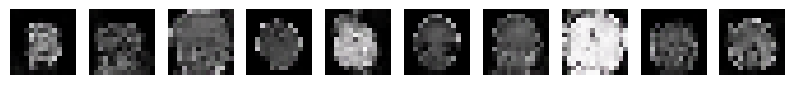

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 1/100 [00:00<00:10,  9.13it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 2/100 [00:00<00:10,  9.29it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 3/100 [00:00<00:10,  9.56it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 5/100 [00:00<00:09, 10.06it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 7/100 [00:00<00:08, 10.54it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 9/100 [00:00<00:08, 10.63it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 11/100 [00:01<00:08, 10.69it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 13/100 [00:01<00:08, 10.82it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 15/100 [00:01<00:07, 10.85it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 17/100 [00:01<00:07, 10.56it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 19/100 [00:01<00:07, 10.60it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 21/100 [00:01<00:07, 10.79it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 23/100 [00:02<00:07, 10.75it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 25/100 [00:02<00:07, 10.62it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 27/100 [00:02<00:06, 10.80it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 29/100 [00:02<00:06, 10.63it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 31/100 [00:02<00:06, 10.76it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 33/100 [00:03<00:06, 10.82it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 35/100 [00:03<00:06, 10.75it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 37/100 [00:03<00:05, 10.86it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 39/100 [00:03<00:05, 10.71it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 41/100 [00:03<00:05, 10.82it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 43/100 [00:04<00:05, 11.00it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 45/100 [00:04<00:05, 10.98it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 47/100 [00:04<00:04, 11.01it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 49/100 [00:04<00:04, 11.29it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 51/100 [00:04<00:04, 11.34it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 53/100 [00:04<00:04, 11.33it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 55/100 [00:05<00:04, 10.96it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 57/100 [00:05<00:03, 11.04it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 59/100 [00:05<00:03, 11.14it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 61/100 [00:05<00:03, 10.89it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 63/100 [00:05<00:03, 11.08it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 65/100 [00:06<00:03, 11.01it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 67/100 [00:06<00:02, 11.11it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 69/100 [00:06<00:02, 11.06it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 71/100 [00:06<00:02, 11.11it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 73/100 [00:06<00:02, 10.95it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 75/100 [00:06<00:02, 10.88it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 77/100 [00:07<00:02, 10.87it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 79/100 [00:07<00:01, 11.02it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 81/100 [00:07<00:01, 11.22it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 83/100 [00:07<00:01, 11.18it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 85/100 [00:07<00:01, 10.87it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 87/100 [00:07<00:01, 11.00it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 89/100 [00:08<00:00, 11.17it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 91/100 [00:08<00:00, 11.23it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 93/100 [00:08<00:00, 11.31it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 95/100 [00:08<00:00, 11.13it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 97/100 [00:08<00:00, 11.18it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 99/100 [00:09<00:00, 11.17it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 2/100 [00:00<00:08, 11.72it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 4/100 [00:00<00:08, 11.45it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 6/100 [00:00<00:08, 11.24it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 8/100 [00:00<00:08, 11.28it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 10/100 [00:00<00:08, 11.13it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 12/100 [00:01<00:07, 11.09it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 14/100 [00:01<00:07, 10.82it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 16/100 [00:01<00:07, 10.62it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 18/100 [00:01<00:07, 10.70it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 20/100 [00:01<00:07, 10.84it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 22/100 [00:02<00:07, 10.62it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 24/100 [00:02<00:07, 10.79it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 26/100 [00:02<00:07, 10.52it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 28/100 [00:02<00:06, 10.35it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 30/100 [00:02<00:06, 10.47it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 32/100 [00:02<00:06, 10.68it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 34/100 [00:03<00:06, 10.63it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 36/100 [00:03<00:06, 10.44it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 38/100 [00:03<00:05, 10.52it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 40/100 [00:03<00:05, 10.69it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 42/100 [00:03<00:05, 10.86it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 44/100 [00:04<00:05, 10.88it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 46/100 [00:04<00:05, 10.78it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 48/100 [00:04<00:04, 10.90it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 50/100 [00:04<00:04, 10.83it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 10.81it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 54/100 [00:04<00:04, 11.00it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 56/100 [00:05<00:04, 10.80it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 10.77it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 60/100 [00:05<00:03, 10.74it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 10.80it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 10.72it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 66/100 [00:06<00:03, 10.59it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 68/100 [00:06<00:02, 10.81it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 70/100 [00:06<00:02, 10.76it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 10.81it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 10.95it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 76/100 [00:07<00:02, 10.94it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 78/100 [00:07<00:01, 11.01it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 80/100 [00:07<00:01, 10.90it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 10.80it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 11.03it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 86/100 [00:08<00:02,  5.72it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 88/100 [00:08<00:01,  6.58it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 90/100 [00:08<00:01,  7.39it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 92/100 [00:09<00:00,  8.15it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 94/100 [00:09<00:00,  8.71it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 95/100 [00:09<00:00,  8.76it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 96/100 [00:09<00:00,  8.84it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 97/100 [00:09<00:00,  8.92it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 99/100 [00:09<00:00,  9.47it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 2/100 [00:00<00:09, 10.39it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 4/100 [00:00<00:09, 10.38it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 6/100 [00:00<00:09,  9.98it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 8/100 [00:00<00:09, 10.17it/s]

1/1 [==============================] - 0s 21ms/step


 10%|█         | 10/100 [00:00<00:08, 10.34it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 12/100 [00:01<00:08, 10.51it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 14/100 [00:01<00:08, 10.29it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 16/100 [00:01<00:08, 10.41it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 18/100 [00:01<00:07, 10.53it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 20/100 [00:01<00:07, 10.66it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 22/100 [00:02<00:07, 10.79it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 24/100 [00:02<00:07, 10.56it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 26/100 [00:02<00:06, 10.68it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 28/100 [00:02<00:06, 10.71it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 30/100 [00:02<00:06, 10.81it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 32/100 [00:03<00:06, 10.86it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 34/100 [00:03<00:06, 10.83it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 36/100 [00:03<00:05, 10.80it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 38/100 [00:03<00:05, 10.76it/s]

1/1 [==============================] - 0s 24ms/step


 40%|████      | 40/100 [00:03<00:05, 10.67it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 42/100 [00:03<00:05, 10.53it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 44/100 [00:04<00:05, 10.41it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 46/100 [00:04<00:05, 10.35it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 48/100 [00:04<00:05, 10.26it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 50/100 [00:04<00:04, 10.42it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 10.55it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 54/100 [00:05<00:04, 10.45it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 56/100 [00:05<00:04, 10.49it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 58/100 [00:05<00:04, 10.37it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 60/100 [00:05<00:03, 10.34it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 10.26it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 64/100 [00:06<00:03, 10.26it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 66/100 [00:06<00:03, 10.39it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 68/100 [00:06<00:03, 10.46it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 70/100 [00:06<00:02, 10.67it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 10.55it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 74/100 [00:07<00:02, 10.53it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 76/100 [00:07<00:02, 10.72it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 78/100 [00:07<00:02, 10.89it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 80/100 [00:07<00:01, 10.88it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 10.56it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 10.57it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 86/100 [00:08<00:01, 10.50it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 88/100 [00:08<00:01, 10.54it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 90/100 [00:08<00:00, 10.59it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 10.65it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 10.69it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 96/100 [00:09<00:00, 10.62it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 98/100 [00:09<00:00, 10.70it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 1/100 [00:00<00:10,  9.89it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 2/100 [00:00<00:10,  9.54it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 4/100 [00:00<00:09, 10.40it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 6/100 [00:00<00:08, 10.52it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 8/100 [00:00<00:08, 10.72it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 10/100 [00:00<00:08, 10.90it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 12/100 [00:01<00:08, 10.61it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 14/100 [00:01<00:07, 10.81it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 16/100 [00:01<00:07, 10.94it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 18/100 [00:01<00:07, 11.02it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 20/100 [00:01<00:07, 11.21it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 22/100 [00:02<00:07, 10.90it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 24/100 [00:02<00:06, 10.99it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 26/100 [00:02<00:06, 10.98it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 28/100 [00:02<00:06, 11.09it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 30/100 [00:02<00:06, 11.29it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 32/100 [00:02<00:06, 11.07it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 34/100 [00:03<00:06, 10.97it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 36/100 [00:03<00:05, 10.94it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 38/100 [00:03<00:05, 11.04it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 40/100 [00:03<00:05, 11.07it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 42/100 [00:03<00:05, 10.86it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 44/100 [00:04<00:05, 10.94it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 46/100 [00:04<00:04, 11.00it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 48/100 [00:04<00:04, 10.97it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 50/100 [00:04<00:04, 11.04it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 10.87it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 54/100 [00:04<00:04, 10.88it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 56/100 [00:05<00:04, 10.79it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 10.97it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 60/100 [00:05<00:03, 11.04it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 10.91it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 10.98it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 66/100 [00:06<00:03, 10.72it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 68/100 [00:06<00:02, 10.67it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 70/100 [00:06<00:02, 10.66it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 10.65it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 10.63it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 10.70it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 78/100 [00:07<00:02, 10.61it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 80/100 [00:07<00:01, 10.77it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 10.59it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 10.64it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 10.75it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 88/100 [00:08<00:01, 10.67it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 90/100 [00:08<00:00, 10.74it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 10.61it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 10.50it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 10.47it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 98/100 [00:09<00:00, 10.32it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 2/100 [00:00<00:09, 10.40it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 4/100 [00:00<00:08, 10.71it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 6/100 [00:00<00:08, 10.91it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 8/100 [00:00<00:08, 10.99it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 10/100 [00:00<00:08, 10.78it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 12/100 [00:01<00:08, 10.56it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 14/100 [00:01<00:08, 10.66it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 16/100 [00:01<00:07, 10.94it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 18/100 [00:01<00:07, 10.86it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 20/100 [00:01<00:07, 10.89it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 22/100 [00:02<00:07, 10.79it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 24/100 [00:02<00:06, 10.96it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 26/100 [00:02<00:06, 10.90it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 28/100 [00:02<00:06, 10.86it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 30/100 [00:02<00:06, 10.73it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 32/100 [00:02<00:06, 10.50it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 34/100 [00:03<00:06, 10.76it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 36/100 [00:03<00:05, 10.92it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 38/100 [00:03<00:05, 10.93it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 40/100 [00:03<00:05, 11.00it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 42/100 [00:03<00:05, 10.92it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 44/100 [00:04<00:05, 10.93it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 46/100 [00:04<00:04, 11.07it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 48/100 [00:04<00:04, 11.18it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 50/100 [00:04<00:04, 11.31it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 11.19it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 54/100 [00:04<00:04, 11.33it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 56/100 [00:05<00:03, 11.30it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 11.39it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 60/100 [00:05<00:03, 11.41it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 11.27it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 11.27it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 66/100 [00:06<00:03, 11.22it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 68/100 [00:06<00:02, 11.28it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 70/100 [00:06<00:02, 11.36it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 11.17it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 11.03it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 11.05it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 78/100 [00:07<00:01, 11.11it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 80/100 [00:07<00:01, 10.99it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 11.01it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 11.19it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 11.04it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 88/100 [00:07<00:01, 10.99it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 90/100 [00:08<00:00, 11.05it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 11.03it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 11.06it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 11.10it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 11.08it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 1/100 [00:00<00:10,  9.28it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 3/100 [00:00<00:09, 10.52it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 5/100 [00:00<00:08, 10.79it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 7/100 [00:00<00:08, 10.84it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 9/100 [00:00<00:08, 10.73it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 11/100 [00:01<00:08, 10.63it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 13/100 [00:01<00:08, 10.56it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 15/100 [00:01<00:08, 10.45it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 17/100 [00:01<00:07, 10.53it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 19/100 [00:01<00:07, 10.64it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 21/100 [00:01<00:07, 10.35it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 23/100 [00:02<00:07, 10.33it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▌       | 25/100 [00:02<00:07, 10.36it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 27/100 [00:02<00:07, 10.39it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 29/100 [00:02<00:07, 10.13it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 31/100 [00:02<00:06, 10.11it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 33/100 [00:03<00:06, 10.24it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 35/100 [00:03<00:06, 10.42it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 37/100 [00:03<00:05, 10.68it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 39/100 [00:03<00:05, 10.73it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 41/100 [00:03<00:05, 10.63it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 43/100 [00:04<00:05, 10.47it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 45/100 [00:04<00:05, 10.63it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 47/100 [00:04<00:04, 10.80it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 49/100 [00:04<00:04, 10.82it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 51/100 [00:04<00:04, 10.51it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 53/100 [00:05<00:04, 10.89it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 55/100 [00:05<00:04, 10.91it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 57/100 [00:05<00:03, 10.76it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 59/100 [00:05<00:03, 10.71it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 61/100 [00:05<00:03, 10.75it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 63/100 [00:05<00:03, 10.74it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 65/100 [00:06<00:03, 10.90it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 67/100 [00:06<00:03, 10.99it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 69/100 [00:06<00:02, 10.97it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 71/100 [00:06<00:02, 11.08it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 73/100 [00:06<00:02, 11.02it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▌  | 75/100 [00:07<00:02, 11.18it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 77/100 [00:07<00:02, 11.22it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 79/100 [00:07<00:01, 11.11it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 81/100 [00:07<00:01, 11.23it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 83/100 [00:07<00:01, 11.26it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 85/100 [00:07<00:01, 11.36it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 87/100 [00:08<00:01, 11.24it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 89/100 [00:08<00:00, 11.08it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 91/100 [00:08<00:00, 11.07it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 93/100 [00:08<00:00, 11.11it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 95/100 [00:08<00:00, 11.15it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 97/100 [00:08<00:00, 11.11it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 99/100 [00:09<00:00, 11.01it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 2/100 [00:00<00:08, 11.41it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 4/100 [00:00<00:08, 11.45it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 6/100 [00:00<00:08, 11.15it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 8/100 [00:00<00:08, 11.01it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 10/100 [00:00<00:08, 11.15it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 12/100 [00:01<00:07, 11.19it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 14/100 [00:01<00:07, 11.37it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 16/100 [00:01<00:07, 11.37it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 18/100 [00:01<00:07, 11.06it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 20/100 [00:01<00:07, 11.10it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 22/100 [00:01<00:06, 11.22it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 24/100 [00:02<00:06, 11.36it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 26/100 [00:02<00:06, 11.31it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 28/100 [00:02<00:06, 11.10it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 30/100 [00:02<00:06, 11.31it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 32/100 [00:02<00:06, 11.23it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 34/100 [00:03<00:05, 11.17it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 36/100 [00:03<00:05, 11.01it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 38/100 [00:03<00:05, 10.63it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 40/100 [00:03<00:05, 10.73it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 42/100 [00:03<00:05, 10.68it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 44/100 [00:03<00:05, 10.76it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 46/100 [00:04<00:05, 10.54it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 48/100 [00:04<00:04, 10.56it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 50/100 [00:04<00:04, 10.73it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 10.83it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 54/100 [00:04<00:04, 10.43it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 56/100 [00:05<00:04, 10.38it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 58/100 [00:05<00:04, 10.35it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 60/100 [00:05<00:03, 10.37it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 10.27it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 10.23it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 66/100 [00:06<00:03, 10.10it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 68/100 [00:06<00:03,  9.92it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 69/100 [00:06<00:03,  9.67it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 71/100 [00:06<00:02, 10.00it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 73/100 [00:06<00:02, 10.17it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 75/100 [00:07<00:02, 10.37it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 77/100 [00:07<00:02, 10.32it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 79/100 [00:07<00:01, 10.55it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 81/100 [00:07<00:01, 10.61it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 83/100 [00:07<00:01, 10.63it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 85/100 [00:07<00:01, 10.87it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 87/100 [00:08<00:01, 10.77it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 89/100 [00:08<00:01, 10.73it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 91/100 [00:08<00:00, 10.52it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 93/100 [00:08<00:00, 10.72it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 95/100 [00:08<00:00, 10.90it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 97/100 [00:09<00:00, 10.94it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 99/100 [00:09<00:00, 10.96it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 2/100 [00:00<00:08, 10.96it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 4/100 [00:00<00:08, 11.01it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 6/100 [00:00<00:08, 11.19it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 8/100 [00:00<00:08, 10.80it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 10/100 [00:00<00:08, 11.01it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 12/100 [00:01<00:07, 11.15it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 14/100 [00:01<00:07, 11.13it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 16/100 [00:01<00:07, 11.31it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 18/100 [00:01<00:07, 11.28it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 20/100 [00:01<00:07, 11.17it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 22/100 [00:01<00:06, 11.31it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 24/100 [00:02<00:06, 11.25it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 26/100 [00:02<00:06, 11.26it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 28/100 [00:02<00:06, 11.14it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 30/100 [00:02<00:06, 11.16it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 32/100 [00:02<00:06, 11.23it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 34/100 [00:03<00:05, 11.10it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 36/100 [00:03<00:05, 11.06it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 38/100 [00:03<00:05, 11.10it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 40/100 [00:03<00:05, 11.29it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 42/100 [00:03<00:05, 11.43it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 44/100 [00:03<00:04, 11.22it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 46/100 [00:04<00:04, 11.12it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 48/100 [00:04<00:04, 11.09it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 50/100 [00:04<00:04, 11.08it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 11.12it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 54/100 [00:04<00:04, 11.11it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 56/100 [00:05<00:03, 11.25it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 11.04it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 60/100 [00:05<00:03, 10.95it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 11.07it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 11.20it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 66/100 [00:05<00:03, 11.23it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 68/100 [00:06<00:02, 10.93it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 70/100 [00:06<00:02, 11.04it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 11.28it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 11.28it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 11.41it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 78/100 [00:06<00:01, 11.16it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 80/100 [00:07<00:01, 11.23it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 11.10it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 11.16it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 10.83it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 88/100 [00:07<00:01, 10.64it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 90/100 [00:08<00:00, 10.38it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 10.42it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 10.45it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 10.61it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 10.56it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 2/100 [00:00<00:09, 10.55it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 4/100 [00:00<00:09, 10.34it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 6/100 [00:00<00:09, 10.16it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 8/100 [00:00<00:08, 10.26it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 10/100 [00:00<00:08, 10.29it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 12/100 [00:01<00:08, 10.38it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 14/100 [00:01<00:08, 10.56it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 16/100 [00:01<00:07, 10.71it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 18/100 [00:01<00:07, 10.51it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 20/100 [00:01<00:07, 10.65it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 22/100 [00:02<00:07, 10.52it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 24/100 [00:02<00:07, 10.58it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 26/100 [00:02<00:06, 10.77it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 28/100 [00:02<00:06, 10.81it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 30/100 [00:02<00:06, 11.12it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 32/100 [00:02<00:06, 11.10it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 34/100 [00:03<00:05, 11.08it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 36/100 [00:03<00:05, 11.26it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 38/100 [00:03<00:05, 11.25it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 40/100 [00:03<00:05, 11.24it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 42/100 [00:03<00:05, 11.37it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 44/100 [00:04<00:04, 11.44it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 46/100 [00:04<00:04, 11.42it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 48/100 [00:04<00:04, 11.16it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 50/100 [00:04<00:04, 11.29it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 11.51it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 54/100 [00:04<00:03, 11.69it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 56/100 [00:05<00:03, 11.53it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 11.39it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 60/100 [00:05<00:03, 11.36it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 11.52it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 11.46it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 66/100 [00:05<00:02, 11.39it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 68/100 [00:06<00:02, 11.19it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 70/100 [00:06<00:02, 11.26it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 11.41it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 11.51it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 11.64it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 78/100 [00:07<00:01, 11.41it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 80/100 [00:07<00:01, 11.26it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 11.45it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 11.52it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 11.43it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 88/100 [00:07<00:01, 11.36it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 90/100 [00:08<00:00, 11.25it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 11.30it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 11.37it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 11.48it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 11.36it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 2/100 [00:00<00:09, 10.25it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 4/100 [00:00<00:08, 10.97it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 6/100 [00:00<00:08, 11.34it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 8/100 [00:00<00:08, 11.17it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 10/100 [00:00<00:08, 11.17it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 12/100 [00:01<00:07, 11.04it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 14/100 [00:01<00:07, 11.06it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 16/100 [00:01<00:07, 11.31it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 18/100 [00:01<00:07, 11.00it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 20/100 [00:01<00:07, 11.00it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 22/100 [00:01<00:07, 11.12it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 24/100 [00:02<00:06, 11.10it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 26/100 [00:02<00:06, 10.89it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 28/100 [00:02<00:06, 10.95it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 30/100 [00:02<00:06, 10.99it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 32/100 [00:02<00:06, 10.95it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 34/100 [00:03<00:06, 10.84it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 36/100 [00:03<00:05, 10.72it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 38/100 [00:03<00:05, 10.46it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 40/100 [00:03<00:05, 10.37it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 42/100 [00:03<00:05, 10.47it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 44/100 [00:04<00:05, 10.52it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 46/100 [00:04<00:05, 10.50it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 48/100 [00:04<00:04, 10.44it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 50/100 [00:04<00:04, 10.70it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 10.75it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 54/100 [00:04<00:04, 10.88it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 56/100 [00:05<00:04, 10.69it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 10.50it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 60/100 [00:05<00:03, 10.65it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 10.59it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 10.66it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 66/100 [00:06<00:03, 10.79it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 68/100 [00:06<00:02, 10.82it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 70/100 [00:06<00:02, 11.00it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 10.92it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 11.10it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 76/100 [00:07<00:02, 11.21it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 78/100 [00:07<00:02, 10.90it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 80/100 [00:07<00:01, 11.08it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 11.02it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 11.08it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 11.35it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 88/100 [00:08<00:01, 11.23it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 90/100 [00:08<00:00, 11.37it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 11.27it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 11.43it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 11.54it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 11.42it/s]

1/1 [==============================] - 0s 19ms/step


100%|██████████| 100/100 [00:09<00:00, 10.94it/s]


Epoch 61, D Loss: 0.4552, D Acc: 75.00%, G Loss: 1.7660
1/1 [==============================] - 0s 19ms/step


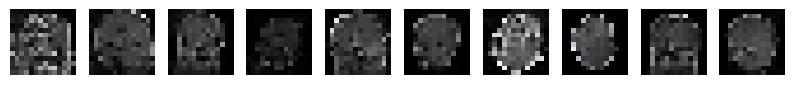

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 2/100 [00:00<00:08, 11.08it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 4/100 [00:00<00:08, 11.22it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 6/100 [00:00<00:08, 11.17it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 8/100 [00:00<00:08, 11.27it/s]

1/1 [==============================] - 0s 15ms/step


 10%|█         | 10/100 [00:00<00:07, 11.52it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 12/100 [00:01<00:07, 11.36it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 14/100 [00:01<00:07, 11.47it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 16/100 [00:01<00:07, 11.55it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 18/100 [00:01<00:07, 11.66it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 20/100 [00:01<00:07, 11.36it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 22/100 [00:01<00:06, 11.19it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 24/100 [00:02<00:06, 11.17it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 26/100 [00:02<00:06, 11.17it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 28/100 [00:02<00:06, 11.33it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 30/100 [00:02<00:06, 11.41it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 32/100 [00:02<00:06, 11.25it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 34/100 [00:03<00:05, 11.32it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 36/100 [00:03<00:05, 11.23it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 38/100 [00:03<00:05, 11.16it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 40/100 [00:03<00:05, 11.32it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 42/100 [00:03<00:05, 11.17it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 44/100 [00:03<00:04, 11.22it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 46/100 [00:04<00:04, 11.14it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 48/100 [00:04<00:04, 11.13it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 50/100 [00:04<00:04, 11.18it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 10.98it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 54/100 [00:04<00:04, 11.07it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 56/100 [00:04<00:03, 11.02it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 11.00it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 60/100 [00:05<00:03, 10.81it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 10.75it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 10.44it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 66/100 [00:05<00:03, 10.54it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 68/100 [00:06<00:03, 10.43it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 70/100 [00:06<00:02, 10.64it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 10.40it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 10.36it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 10.40it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 78/100 [00:07<00:02, 10.39it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 80/100 [00:07<00:01, 10.31it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 10.49it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 10.60it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 10.66it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 88/100 [00:08<00:01, 10.68it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 90/100 [00:08<00:00, 10.82it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 10.73it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 10.78it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 10.80it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 11.05it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 1/100 [00:00<00:10,  9.12it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 3/100 [00:00<00:09,  9.94it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 5/100 [00:00<00:09, 10.41it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 7/100 [00:00<00:08, 10.73it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 9/100 [00:00<00:08, 10.78it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 11/100 [00:01<00:08, 10.90it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 13/100 [00:01<00:07, 11.08it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 15/100 [00:01<00:07, 11.07it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 17/100 [00:01<00:07, 10.79it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 19/100 [00:01<00:07, 10.99it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 21/100 [00:01<00:07, 10.95it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 23/100 [00:02<00:07, 10.78it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 25/100 [00:02<00:06, 11.08it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 27/100 [00:02<00:06, 11.28it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 29/100 [00:02<00:06, 11.32it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 31/100 [00:02<00:06, 11.16it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 33/100 [00:03<00:05, 11.26it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 35/100 [00:03<00:05, 11.16it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 37/100 [00:03<00:05, 11.26it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 39/100 [00:03<00:05, 11.29it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 41/100 [00:03<00:05, 11.22it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 43/100 [00:03<00:05, 11.30it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 45/100 [00:04<00:04, 11.36it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 47/100 [00:04<00:04, 11.31it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 49/100 [00:04<00:04, 11.53it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 51/100 [00:04<00:04, 11.55it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 53/100 [00:04<00:04, 11.36it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 55/100 [00:04<00:03, 11.41it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 57/100 [00:05<00:03, 11.56it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 59/100 [00:05<00:03, 11.42it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 61/100 [00:05<00:03, 11.64it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 63/100 [00:05<00:03, 11.34it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 65/100 [00:05<00:03, 11.49it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 67/100 [00:05<00:02, 11.59it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 69/100 [00:06<00:02, 11.63it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 71/100 [00:06<00:02, 11.48it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 73/100 [00:06<00:02, 11.05it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▌  | 75/100 [00:06<00:02, 11.30it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 77/100 [00:06<00:02, 11.48it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 79/100 [00:07<00:01, 11.45it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 81/100 [00:07<00:01, 11.41it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 83/100 [00:07<00:01, 11.32it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▌ | 85/100 [00:07<00:01, 11.22it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 87/100 [00:07<00:01, 10.98it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 89/100 [00:07<00:00, 11.03it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 91/100 [00:08<00:00, 11.23it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 93/100 [00:08<00:00, 10.92it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 95/100 [00:08<00:00, 10.81it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 97/100 [00:08<00:00, 10.73it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 99/100 [00:08<00:00, 10.82it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 2/100 [00:00<00:09, 10.42it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 4/100 [00:00<00:08, 10.68it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 6/100 [00:00<00:08, 10.88it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 8/100 [00:00<00:08, 10.94it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 10/100 [00:00<00:08, 10.73it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 12/100 [00:01<00:08, 10.46it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 14/100 [00:01<00:08, 10.47it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 16/100 [00:01<00:07, 10.65it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 18/100 [00:01<00:07, 10.57it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 20/100 [00:01<00:07, 10.76it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 22/100 [00:02<00:07, 10.66it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 24/100 [00:02<00:07, 10.67it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 26/100 [00:02<00:06, 10.88it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 28/100 [00:02<00:06, 11.18it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 30/100 [00:02<00:06, 11.35it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 32/100 [00:02<00:06, 11.16it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 34/100 [00:03<00:05, 11.18it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 36/100 [00:03<00:05, 11.23it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 38/100 [00:03<00:05, 11.27it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 40/100 [00:03<00:05, 11.16it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 42/100 [00:03<00:05, 11.16it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 44/100 [00:04<00:04, 11.29it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 46/100 [00:04<00:04, 11.18it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 48/100 [00:04<00:04, 11.33it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 50/100 [00:04<00:04, 11.40it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 11.14it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 54/100 [00:04<00:04, 11.07it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 56/100 [00:05<00:03, 11.05it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 11.19it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 60/100 [00:05<00:03, 11.19it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 10.99it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 11.25it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 66/100 [00:05<00:03, 11.26it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 68/100 [00:06<00:02, 11.32it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 70/100 [00:06<00:02, 11.29it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 11.24it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 11.32it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 11.20it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 78/100 [00:07<00:01, 11.33it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 80/100 [00:07<00:01, 11.44it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 11.39it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 11.20it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 11.34it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 88/100 [00:07<00:01, 11.45it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 90/100 [00:08<00:00, 11.65it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 11.44it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 11.52it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 11.33it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 11.47it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 2/100 [00:00<00:08, 11.09it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 4/100 [00:00<00:08, 11.48it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 6/100 [00:00<00:08, 11.44it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 8/100 [00:00<00:08, 11.10it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 10/100 [00:00<00:07, 11.44it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 12/100 [00:01<00:07, 11.33it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 14/100 [00:01<00:07, 11.30it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 16/100 [00:01<00:07, 11.35it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 18/100 [00:01<00:07, 11.35it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 20/100 [00:01<00:07, 11.25it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 22/100 [00:01<00:06, 11.27it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 24/100 [00:02<00:06, 11.35it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 26/100 [00:02<00:06, 11.30it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 28/100 [00:02<00:06, 11.21it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 30/100 [00:02<00:06, 11.18it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 32/100 [00:02<00:06, 11.08it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 34/100 [00:03<00:06, 10.89it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 36/100 [00:03<00:05, 10.98it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 38/100 [00:03<00:05, 11.12it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 40/100 [00:03<00:05, 10.98it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 42/100 [00:03<00:05, 10.97it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 44/100 [00:03<00:05, 11.19it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 46/100 [00:04<00:04, 10.98it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 48/100 [00:04<00:04, 10.77it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 50/100 [00:04<00:04, 10.92it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 10.66it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 54/100 [00:04<00:04, 10.78it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 56/100 [00:05<00:04, 10.90it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 10.77it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 60/100 [00:05<00:03, 10.64it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 10.76it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 10.90it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 66/100 [00:05<00:03, 11.01it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 68/100 [00:06<00:02, 10.93it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 70/100 [00:06<00:02, 11.06it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 11.04it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 11.16it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 11.16it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 78/100 [00:07<00:01, 11.13it/s]

1/1 [==============================] - 0s 16ms/step


 80%|████████  | 80/100 [00:07<00:01, 11.13it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 11.16it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 11.26it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 11.46it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 88/100 [00:07<00:01, 11.29it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 90/100 [00:08<00:00, 11.22it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 11.08it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 11.12it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 11.16it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 11.24it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 2/100 [00:00<00:09, 10.79it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 4/100 [00:00<00:08, 11.09it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 6/100 [00:00<00:08, 11.12it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 8/100 [00:00<00:08, 11.13it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 10/100 [00:00<00:08, 11.15it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 12/100 [00:01<00:07, 11.06it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 14/100 [00:01<00:07, 11.10it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 16/100 [00:01<00:07, 10.94it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 18/100 [00:01<00:07, 10.89it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 20/100 [00:01<00:07, 10.94it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 22/100 [00:01<00:07, 11.07it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 24/100 [00:02<00:06, 11.29it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 26/100 [00:02<00:06, 11.35it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 28/100 [00:02<00:06, 11.32it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 30/100 [00:02<00:06, 11.30it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 32/100 [00:02<00:06, 11.32it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 34/100 [00:03<00:05, 11.42it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 36/100 [00:03<00:05, 11.41it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 38/100 [00:03<00:05, 11.61it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 40/100 [00:03<00:05, 11.59it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 42/100 [00:03<00:05, 11.44it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 44/100 [00:03<00:04, 11.47it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 46/100 [00:04<00:04, 11.48it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 48/100 [00:04<00:04, 11.31it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 50/100 [00:04<00:04, 11.42it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 11.19it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 54/100 [00:04<00:04, 11.34it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 56/100 [00:04<00:03, 11.50it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 11.51it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 60/100 [00:05<00:03, 11.31it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 11.08it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 11.10it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 66/100 [00:05<00:03, 11.01it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 68/100 [00:06<00:02, 11.15it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 70/100 [00:06<00:02, 11.36it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 11.26it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 10.63it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 10.64it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 78/100 [00:06<00:02, 10.79it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 80/100 [00:07<00:01, 10.88it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 10.82it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 10.88it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 10.69it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 88/100 [00:07<00:01, 10.61it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 90/100 [00:08<00:00, 10.65it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 10.46it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 10.64it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 10.45it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 10.62it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 2/100 [00:00<00:09, 10.45it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 4/100 [00:00<00:08, 10.74it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 6/100 [00:00<00:08, 11.10it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 8/100 [00:00<00:08, 11.46it/s]

1/1 [==============================] - 0s 15ms/step


 10%|█         | 10/100 [00:00<00:07, 11.71it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 12/100 [00:01<00:07, 11.47it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 14/100 [00:01<00:07, 11.51it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 16/100 [00:01<00:07, 11.58it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 18/100 [00:01<00:07, 11.49it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 20/100 [00:01<00:07, 11.41it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 22/100 [00:01<00:06, 11.45it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 24/100 [00:02<00:06, 11.59it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 26/100 [00:02<00:06, 11.46it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 28/100 [00:02<00:06, 11.42it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 30/100 [00:02<00:06, 11.39it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 32/100 [00:02<00:06, 11.30it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 34/100 [00:02<00:05, 11.40it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 36/100 [00:03<00:05, 11.52it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 38/100 [00:03<00:05, 11.69it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 40/100 [00:03<00:05, 11.29it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 42/100 [00:03<00:05, 11.18it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 44/100 [00:03<00:04, 11.28it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 46/100 [00:04<00:04, 11.28it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 48/100 [00:04<00:04, 11.16it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 50/100 [00:04<00:04, 11.19it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 11.11it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 54/100 [00:04<00:04, 11.22it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 56/100 [00:04<00:03, 11.20it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 11.26it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 60/100 [00:05<00:03, 11.30it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 11.31it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 11.13it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 66/100 [00:05<00:03, 11.10it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 68/100 [00:06<00:02, 11.16it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 70/100 [00:06<00:02, 11.19it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 11.14it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 11.19it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 11.27it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 78/100 [00:06<00:01, 11.09it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 80/100 [00:07<00:01, 10.96it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 11.00it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 11.19it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 11.06it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 88/100 [00:07<00:01, 11.21it/s]

1/1 [==============================] - 0s 15ms/step


 90%|█████████ | 90/100 [00:07<00:00, 11.36it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 11.39it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 11.36it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 11.21it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 11.24it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 2/100 [00:00<00:08, 11.35it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 4/100 [00:00<00:08, 11.49it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 6/100 [00:00<00:08, 11.72it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 8/100 [00:00<00:08, 11.33it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 10/100 [00:00<00:08, 11.19it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 12/100 [00:01<00:08, 10.78it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 14/100 [00:01<00:07, 10.78it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 16/100 [00:01<00:07, 10.79it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 18/100 [00:01<00:07, 10.97it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 20/100 [00:01<00:07, 11.06it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 22/100 [00:02<00:07, 10.79it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 24/100 [00:02<00:07, 10.85it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 26/100 [00:02<00:06, 10.94it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 28/100 [00:02<00:06, 10.92it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 30/100 [00:02<00:06, 10.80it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 32/100 [00:02<00:06, 10.71it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 34/100 [00:03<00:06, 10.73it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 36/100 [00:03<00:05, 10.92it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 38/100 [00:03<00:05, 11.09it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 40/100 [00:03<00:05, 11.23it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 42/100 [00:03<00:05, 10.85it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 44/100 [00:04<00:05, 11.13it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 46/100 [00:04<00:04, 11.41it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 48/100 [00:04<00:04, 11.55it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 50/100 [00:04<00:04, 11.54it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 11.37it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 54/100 [00:04<00:04, 11.46it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 56/100 [00:05<00:03, 11.42it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 11.54it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 60/100 [00:05<00:03, 11.45it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 11.44it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 11.29it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 66/100 [00:05<00:03, 11.28it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 68/100 [00:06<00:02, 11.43it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 70/100 [00:06<00:02, 11.48it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 11.45it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 11.54it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 11.40it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 78/100 [00:06<00:01, 11.52it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 80/100 [00:07<00:01, 11.41it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 11.20it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 11.41it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 11.30it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 88/100 [00:07<00:01, 11.34it/s]

1/1 [==============================] - 0s 16ms/step


 90%|█████████ | 90/100 [00:08<00:00, 11.31it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 11.16it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 11.27it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 11.13it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 11.20it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 2/100 [00:00<00:09, 10.15it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 4/100 [00:00<00:08, 10.71it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 6/100 [00:00<00:08, 10.83it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 8/100 [00:00<00:08, 10.92it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 10/100 [00:00<00:08, 10.93it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 12/100 [00:01<00:08, 10.74it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 14/100 [00:01<00:15,  5.43it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 15/100 [00:01<00:14,  5.92it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 16/100 [00:02<00:13,  6.43it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 17/100 [00:02<00:11,  7.01it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 18/100 [00:02<00:11,  7.42it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▉        | 19/100 [00:02<00:10,  7.91it/s]

1/1 [==============================] - 0s 22ms/step


 20%|██        | 20/100 [00:02<00:09,  8.37it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 22/100 [00:02<00:08,  8.88it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 24/100 [00:02<00:08,  9.32it/s]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 25/100 [00:02<00:08,  9.36it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 26/100 [00:03<00:07,  9.48it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 28/100 [00:03<00:07,  9.95it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 30/100 [00:03<00:06, 10.00it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 32/100 [00:03<00:06, 10.09it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 34/100 [00:03<00:06,  9.91it/s]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 35/100 [00:03<00:06,  9.90it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 37/100 [00:04<00:06, 10.18it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 39/100 [00:04<00:05, 10.21it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 41/100 [00:04<00:05, 10.13it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 43/100 [00:04<00:05,  9.84it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 44/100 [00:04<00:05,  9.85it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 45/100 [00:04<00:05,  9.74it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 47/100 [00:05<00:05,  9.96it/s]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 48/100 [00:05<00:05,  9.93it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 49/100 [00:05<00:05,  9.85it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 51/100 [00:05<00:04,  9.83it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 52/100 [00:05<00:04,  9.79it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 53/100 [00:05<00:04,  9.73it/s]

1/1 [==============================] - 0s 22ms/step


 55%|█████▌    | 55/100 [00:06<00:04,  9.76it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 56/100 [00:06<00:04,  9.78it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 58/100 [00:06<00:04,  9.95it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 59/100 [00:06<00:04,  9.84it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 60/100 [00:06<00:04,  9.64it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 61/100 [00:06<00:04,  9.52it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 62/100 [00:06<00:03,  9.63it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 63/100 [00:06<00:03,  9.57it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 65/100 [00:07<00:03,  9.85it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 67/100 [00:07<00:03, 10.15it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 69/100 [00:07<00:02, 10.41it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 71/100 [00:07<00:02, 10.39it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 73/100 [00:07<00:02, 10.39it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 75/100 [00:07<00:02, 10.41it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 77/100 [00:08<00:02, 10.47it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 79/100 [00:08<00:01, 10.53it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 81/100 [00:08<00:01, 10.40it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 83/100 [00:08<00:01, 10.54it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 85/100 [00:08<00:01, 10.65it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 87/100 [00:09<00:01, 10.49it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 89/100 [00:09<00:01, 10.58it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 91/100 [00:09<00:00, 10.44it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 93/100 [00:09<00:00, 10.53it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 95/100 [00:09<00:00, 10.17it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 97/100 [00:10<00:00, 10.37it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 99/100 [00:10<00:00, 10.45it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  1%|          | 1/100 [00:00<00:11,  8.77it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 3/100 [00:00<00:09, 10.19it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 5/100 [00:00<00:09, 10.45it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 7/100 [00:00<00:08, 10.55it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 9/100 [00:00<00:08, 10.63it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 11/100 [00:01<00:08, 10.43it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 13/100 [00:01<00:08, 10.43it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 15/100 [00:01<00:08, 10.44it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 17/100 [00:01<00:07, 10.39it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 19/100 [00:01<00:07, 10.56it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 21/100 [00:02<00:07, 10.49it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 23/100 [00:02<00:07, 10.37it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 25/100 [00:02<00:07, 10.39it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 27/100 [00:02<00:06, 10.48it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 29/100 [00:02<00:06, 10.32it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 31/100 [00:02<00:06, 10.23it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 33/100 [00:03<00:06, 10.20it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 35/100 [00:03<00:06, 10.08it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 37/100 [00:03<00:06, 10.14it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 39/100 [00:03<00:05, 10.42it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 41/100 [00:03<00:05, 10.32it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 43/100 [00:04<00:05, 10.16it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 45/100 [00:04<00:05, 10.11it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 47/100 [00:04<00:05, 10.00it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 49/100 [00:04<00:05, 10.17it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 51/100 [00:04<00:04, 10.11it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 53/100 [00:05<00:04, 10.13it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 55/100 [00:05<00:04, 10.15it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 57/100 [00:05<00:04, 10.24it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 59/100 [00:05<00:03, 10.40it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 61/100 [00:05<00:03, 10.34it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 63/100 [00:06<00:03, 10.35it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 65/100 [00:06<00:03, 10.29it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 67/100 [00:06<00:03, 10.32it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 69/100 [00:06<00:03, 10.32it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 71/100 [00:06<00:02,  9.96it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 73/100 [00:07<00:02, 10.02it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 75/100 [00:07<00:02,  9.87it/s]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 76/100 [00:07<00:02,  9.80it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 78/100 [00:07<00:02,  9.88it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 80/100 [00:07<00:01, 10.01it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 82/100 [00:08<00:01, 10.12it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 84/100 [00:08<00:01, 10.14it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 86/100 [00:08<00:01, 10.13it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 88/100 [00:08<00:01, 10.20it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 90/100 [00:08<00:00, 10.04it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 92/100 [00:09<00:00,  9.91it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 93/100 [00:09<00:00,  9.85it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 95/100 [00:09<00:00, 10.11it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 97/100 [00:09<00:00, 10.28it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 99/100 [00:09<00:00, 10.55it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 2/100 [00:00<00:09, 10.53it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 4/100 [00:00<00:08, 10.81it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 6/100 [00:00<00:08, 10.76it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 8/100 [00:00<00:08, 10.53it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 10/100 [00:00<00:08, 10.47it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 12/100 [00:01<00:08, 10.62it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 14/100 [00:01<00:08, 10.61it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 16/100 [00:01<00:07, 10.80it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 18/100 [00:01<00:07, 10.60it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 20/100 [00:01<00:07, 10.52it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 22/100 [00:02<00:07, 10.49it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 24/100 [00:02<00:07, 10.55it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 26/100 [00:02<00:06, 10.76it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 28/100 [00:02<00:06, 10.71it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 30/100 [00:02<00:06, 10.40it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 32/100 [00:03<00:06, 10.62it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 34/100 [00:03<00:06, 10.50it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 36/100 [00:03<00:06, 10.59it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 38/100 [00:03<00:05, 10.65it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 40/100 [00:03<00:05, 10.62it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 42/100 [00:03<00:05, 10.70it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 44/100 [00:04<00:05, 10.89it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 46/100 [00:04<00:04, 10.93it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 48/100 [00:04<00:04, 11.02it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 50/100 [00:04<00:04, 10.49it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 10.56it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 54/100 [00:05<00:04, 10.50it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 56/100 [00:05<00:04, 10.58it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 10.50it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 60/100 [00:05<00:03, 10.14it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 10.36it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 64/100 [00:06<00:03, 10.48it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 66/100 [00:06<00:03, 10.63it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 68/100 [00:06<00:03, 10.54it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 70/100 [00:06<00:02, 10.21it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 10.30it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 74/100 [00:07<00:02, 10.43it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 76/100 [00:07<00:02, 10.52it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 78/100 [00:07<00:02, 10.56it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 80/100 [00:07<00:01, 10.27it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 10.18it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 10.34it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 86/100 [00:08<00:01, 10.33it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 88/100 [00:08<00:01, 10.40it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 90/100 [00:08<00:00, 10.03it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 10.09it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 10.28it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 96/100 [00:09<00:00, 10.54it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 98/100 [00:09<00:00, 10.30it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 100/100 [00:09<00:00, 10.48it/s]

Epoch 71, D Loss: 0.4608, D Acc: 75.00%, G Loss: 1.4163
1/1 [==============================] - 0s 27ms/step


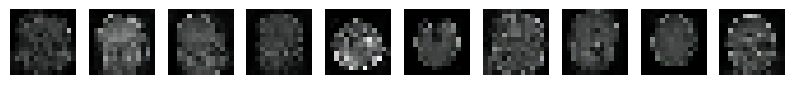

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 1/100 [00:00<00:10,  9.74it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 2/100 [00:00<00:10,  9.49it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 3/100 [00:00<00:10,  9.41it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 4/100 [00:00<00:09,  9.61it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 6/100 [00:00<00:09,  9.99it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 8/100 [00:00<00:08, 10.31it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 10/100 [00:00<00:08, 10.47it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 12/100 [00:01<00:08, 10.38it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 14/100 [00:01<00:08, 10.35it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 16/100 [00:01<00:08, 10.29it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 18/100 [00:01<00:08, 10.20it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 20/100 [00:01<00:07, 10.29it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 22/100 [00:02<00:07, 10.24it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 24/100 [00:02<00:07, 10.54it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 26/100 [00:02<00:06, 10.75it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 28/100 [00:02<00:06, 10.92it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 30/100 [00:02<00:06, 10.90it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 32/100 [00:03<00:06, 10.66it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 34/100 [00:03<00:06, 10.93it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 36/100 [00:03<00:05, 11.02it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 38/100 [00:03<00:05, 10.97it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 40/100 [00:03<00:05, 10.69it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 42/100 [00:03<00:05, 10.54it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 44/100 [00:04<00:05, 10.61it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 46/100 [00:04<00:05, 10.80it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 48/100 [00:04<00:04, 10.78it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 50/100 [00:04<00:04, 10.70it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 10.48it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 54/100 [00:05<00:04, 10.51it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 56/100 [00:05<00:04, 10.89it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 11.04it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 60/100 [00:05<00:03, 10.89it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 10.77it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 64/100 [00:06<00:03, 10.87it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 66/100 [00:06<00:03, 10.93it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 68/100 [00:06<00:02, 10.86it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 70/100 [00:06<00:02, 10.88it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 10.79it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 10.87it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 76/100 [00:07<00:02, 10.89it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 78/100 [00:07<00:02, 10.90it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 80/100 [00:07<00:01, 11.03it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 10.87it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 10.66it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 86/100 [00:08<00:01, 10.79it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 88/100 [00:08<00:01, 10.98it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 90/100 [00:08<00:00, 10.91it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 10.66it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 10.61it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 10.75it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 98/100 [00:09<00:00, 10.93it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 2/100 [00:00<00:08, 10.97it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 4/100 [00:00<00:08, 11.23it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 6/100 [00:00<00:08, 11.10it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 8/100 [00:00<00:08, 10.80it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 10/100 [00:00<00:08, 10.92it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 12/100 [00:01<00:08, 10.76it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 14/100 [00:01<00:07, 10.80it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 16/100 [00:01<00:07, 10.81it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 18/100 [00:01<00:07, 10.77it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 20/100 [00:01<00:07, 10.82it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 22/100 [00:02<00:07, 10.87it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 24/100 [00:02<00:07, 10.77it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 26/100 [00:02<00:06, 10.85it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 28/100 [00:02<00:06, 10.73it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 30/100 [00:02<00:06, 10.78it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 32/100 [00:02<00:06, 10.55it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 34/100 [00:03<00:06, 10.63it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 36/100 [00:03<00:05, 10.70it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 38/100 [00:03<00:05, 10.72it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 40/100 [00:03<00:05, 10.80it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 42/100 [00:03<00:05, 10.57it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 44/100 [00:04<00:05, 10.53it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 46/100 [00:04<00:05, 10.58it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 48/100 [00:04<00:04, 10.54it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 50/100 [00:04<00:04, 10.47it/s]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 10.24it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▍    | 54/100 [00:05<00:04, 10.11it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 56/100 [00:05<00:04, 10.27it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 58/100 [00:05<00:04, 10.43it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 60/100 [00:05<00:03, 10.67it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 10.58it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 10.76it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 66/100 [00:06<00:03, 10.79it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 68/100 [00:06<00:02, 10.87it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 70/100 [00:06<00:02, 10.93it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 10.92it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 11.09it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 76/100 [00:07<00:02, 11.30it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 78/100 [00:07<00:01, 11.28it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 80/100 [00:07<00:01, 11.30it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 11.25it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 11.30it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 11.40it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 88/100 [00:08<00:01, 11.26it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 90/100 [00:08<00:00, 11.29it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 11.19it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 11.10it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 11.07it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 98/100 [00:09<00:00, 11.23it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 1/100 [00:00<00:10,  9.70it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 2/100 [00:00<00:10,  9.40it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 4/100 [00:00<00:09, 10.54it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 6/100 [00:00<00:08, 10.63it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 8/100 [00:00<00:08, 10.81it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 10/100 [00:00<00:08, 10.96it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 12/100 [00:01<00:08, 10.77it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 14/100 [00:01<00:08, 10.70it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 16/100 [00:01<00:07, 10.70it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 18/100 [00:01<00:07, 10.76it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 20/100 [00:01<00:07, 10.89it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 22/100 [00:02<00:07, 10.80it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 24/100 [00:02<00:07, 10.72it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 26/100 [00:02<00:06, 10.60it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 28/100 [00:02<00:06, 10.94it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 30/100 [00:02<00:06, 11.06it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 32/100 [00:02<00:06, 11.00it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 34/100 [00:03<00:05, 11.16it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 36/100 [00:03<00:05, 11.26it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 38/100 [00:03<00:05, 10.86it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 40/100 [00:03<00:05, 10.86it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 42/100 [00:03<00:05, 10.74it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 44/100 [00:04<00:05, 10.86it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 46/100 [00:04<00:04, 10.81it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 48/100 [00:04<00:04, 10.87it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 50/100 [00:04<00:04, 11.05it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 10.98it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 54/100 [00:04<00:04, 10.94it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 56/100 [00:05<00:04, 10.91it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 10.75it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 60/100 [00:05<00:03, 10.69it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 10.41it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 10.58it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 66/100 [00:06<00:03, 10.55it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 68/100 [00:06<00:03, 10.35it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 70/100 [00:06<00:02, 10.24it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 10.28it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 10.44it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 76/100 [00:07<00:02, 10.52it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 78/100 [00:07<00:02, 10.65it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 80/100 [00:07<00:01, 10.41it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 10.09it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 10.14it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 86/100 [00:08<00:01, 10.37it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 88/100 [00:08<00:01, 10.31it/s]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 90/100 [00:08<00:00, 10.29it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 10.23it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 10.34it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 96/100 [00:09<00:00, 10.66it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 98/100 [00:09<00:00, 10.67it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 2/100 [00:00<00:09, 10.06it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 4/100 [00:00<00:08, 10.81it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 6/100 [00:00<00:08, 11.07it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 8/100 [00:00<00:08, 11.30it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 10/100 [00:00<00:08, 11.03it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 12/100 [00:01<00:08, 10.98it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 14/100 [00:01<00:07, 10.98it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 16/100 [00:01<00:07, 10.66it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 18/100 [00:01<00:07, 10.89it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 20/100 [00:01<00:07, 10.88it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 22/100 [00:02<00:07, 10.74it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 24/100 [00:02<00:06, 10.96it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 26/100 [00:02<00:06, 11.19it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 28/100 [00:02<00:06, 11.32it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 30/100 [00:02<00:06, 11.38it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 32/100 [00:02<00:06, 11.17it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 34/100 [00:03<00:05, 11.02it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 36/100 [00:03<00:05, 11.00it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 38/100 [00:03<00:05, 11.04it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 40/100 [00:03<00:05, 10.96it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 42/100 [00:03<00:05, 10.64it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 44/100 [00:04<00:05, 10.66it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 46/100 [00:04<00:05, 10.76it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 48/100 [00:04<00:04, 10.95it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 50/100 [00:04<00:04, 10.77it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 10.55it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 54/100 [00:04<00:04, 10.76it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 56/100 [00:05<00:04, 10.77it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 10.90it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 60/100 [00:05<00:03, 11.01it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 10.94it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 11.02it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 66/100 [00:06<00:03, 11.19it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 68/100 [00:06<00:02, 10.94it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 70/100 [00:06<00:02, 10.89it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 10.72it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 10.64it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 10.65it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 78/100 [00:07<00:02, 10.79it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 80/100 [00:07<00:01, 10.77it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 10.60it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 10.59it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 10.59it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 88/100 [00:08<00:01, 10.67it/s]

1/1 [==============================] - 0s 16ms/step


 90%|█████████ | 90/100 [00:08<00:00, 10.92it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 10.93it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 10.85it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 11.00it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 11.10it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 2/100 [00:00<00:09, 10.10it/s]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 4/100 [00:00<00:09, 10.14it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 6/100 [00:00<00:09, 10.08it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 8/100 [00:00<00:09, 10.12it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 10/100 [00:00<00:08, 10.41it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 12/100 [00:01<00:08, 10.35it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 14/100 [00:01<00:08, 10.48it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 16/100 [00:01<00:07, 10.52it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 18/100 [00:01<00:07, 10.65it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 20/100 [00:01<00:07, 10.67it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 22/100 [00:02<00:07, 10.48it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 24/100 [00:02<00:07, 10.30it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 26/100 [00:02<00:07, 10.35it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 28/100 [00:02<00:06, 10.45it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 30/100 [00:02<00:06, 10.70it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 32/100 [00:03<00:06, 10.66it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 34/100 [00:03<00:06, 10.83it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 36/100 [00:03<00:05, 10.93it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 38/100 [00:03<00:05, 10.83it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 40/100 [00:03<00:05, 11.08it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 42/100 [00:03<00:05, 10.88it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 44/100 [00:04<00:05, 11.10it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 46/100 [00:04<00:04, 11.23it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 48/100 [00:04<00:04, 11.35it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 50/100 [00:04<00:04, 11.22it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 11.17it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 54/100 [00:05<00:04, 11.31it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 56/100 [00:05<00:03, 11.28it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 11.11it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 60/100 [00:05<00:03, 11.12it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 11.15it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 11.12it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 66/100 [00:06<00:03, 11.09it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 68/100 [00:06<00:02, 11.11it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 70/100 [00:06<00:02, 11.25it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 10.85it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 11.02it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 76/100 [00:07<00:02, 11.08it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 78/100 [00:07<00:01, 11.09it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 80/100 [00:07<00:01, 11.15it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 10.99it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 10.77it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 10.94it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 88/100 [00:08<00:01, 11.18it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 90/100 [00:08<00:00, 11.16it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 11.11it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 11.09it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 11.17it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 11.10it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 2/100 [00:00<00:09,  9.87it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 4/100 [00:00<00:09, 10.19it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 6/100 [00:00<00:09, 10.22it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 8/100 [00:00<00:08, 10.50it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 10/100 [00:00<00:08, 10.71it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 12/100 [00:01<00:08, 10.61it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 14/100 [00:01<00:08, 10.61it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 16/100 [00:01<00:07, 10.52it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 18/100 [00:01<00:07, 10.66it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 20/100 [00:01<00:07, 10.88it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 22/100 [00:02<00:07, 10.75it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 24/100 [00:02<00:06, 10.92it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 26/100 [00:02<00:06, 10.89it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 28/100 [00:02<00:06, 10.94it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 30/100 [00:02<00:06, 11.09it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 32/100 [00:02<00:06, 11.22it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 34/100 [00:03<00:05, 11.16it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 36/100 [00:03<00:05, 11.05it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 38/100 [00:03<00:05, 10.93it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 40/100 [00:03<00:05, 10.73it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 42/100 [00:03<00:05, 10.54it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 44/100 [00:04<00:05, 10.61it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 46/100 [00:04<00:05, 10.45it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 48/100 [00:04<00:04, 10.53it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 50/100 [00:04<00:04, 10.67it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 10.66it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 54/100 [00:05<00:04, 10.72it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 56/100 [00:05<00:04, 10.83it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 10.70it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 60/100 [00:05<00:03, 10.37it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 10.44it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 10.64it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 66/100 [00:06<00:03, 10.69it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 68/100 [00:06<00:02, 10.85it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 70/100 [00:06<00:02, 10.85it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 10.75it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 10.80it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 76/100 [00:07<00:02, 11.01it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 78/100 [00:07<00:01, 11.08it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 80/100 [00:07<00:01, 10.83it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 10.70it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 10.73it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 11.01it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 88/100 [00:08<00:01, 11.17it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 90/100 [00:08<00:00, 11.07it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 10.89it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 10.98it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 11.13it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 98/100 [00:09<00:00, 11.21it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 2/100 [00:00<00:09, 10.21it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 4/100 [00:00<00:08, 10.71it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 6/100 [00:00<00:08, 11.03it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 8/100 [00:00<00:08, 11.17it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 10/100 [00:00<00:08, 10.96it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 12/100 [00:01<00:08, 10.79it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 14/100 [00:01<00:08, 10.70it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 16/100 [00:01<00:07, 10.89it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 18/100 [00:01<00:07, 10.94it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 20/100 [00:01<00:07, 11.07it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 22/100 [00:02<00:07, 11.11it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 24/100 [00:02<00:07, 10.71it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 26/100 [00:02<00:06, 10.94it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 28/100 [00:02<00:06, 11.12it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 30/100 [00:02<00:06, 11.06it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 32/100 [00:02<00:06, 11.27it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 34/100 [00:03<00:05, 11.09it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 36/100 [00:03<00:05, 11.01it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 38/100 [00:03<00:05, 11.04it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 40/100 [00:03<00:05, 11.17it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 42/100 [00:03<00:05, 11.14it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 44/100 [00:04<00:05, 10.99it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 46/100 [00:04<00:04, 10.95it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 48/100 [00:04<00:04, 11.02it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 50/100 [00:04<00:04, 11.05it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 11.04it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 54/100 [00:04<00:04, 11.00it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 56/100 [00:05<00:03, 11.12it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 11.11it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 60/100 [00:05<00:03, 11.14it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 11.20it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 11.28it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 66/100 [00:05<00:03, 11.20it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 68/100 [00:06<00:02, 11.25it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 70/100 [00:06<00:02, 11.21it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 11.12it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 10.89it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 10.92it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 78/100 [00:07<00:01, 11.06it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 80/100 [00:07<00:01, 11.14it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 11.12it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 10.90it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 10.82it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 88/100 [00:07<00:01, 10.98it/s]

1/1 [==============================] - 0s 20ms/step


 90%|█████████ | 90/100 [00:08<00:00, 10.75it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 10.85it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 10.50it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 10.68it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 10.75it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 2/100 [00:00<00:09, 10.45it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 4/100 [00:00<00:09, 10.38it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 6/100 [00:00<00:09, 10.40it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 8/100 [00:00<00:08, 10.41it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 10/100 [00:00<00:08, 10.81it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 12/100 [00:01<00:08, 10.81it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 14/100 [00:01<00:08, 10.72it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 16/100 [00:01<00:07, 10.97it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 18/100 [00:01<00:07, 10.92it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 20/100 [00:01<00:07, 11.08it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 22/100 [00:02<00:07, 11.05it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 24/100 [00:02<00:06, 10.88it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 26/100 [00:02<00:06, 10.81it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 28/100 [00:02<00:06, 10.93it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 30/100 [00:02<00:06, 10.85it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 32/100 [00:02<00:06, 10.84it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 34/100 [00:03<00:06, 10.54it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 36/100 [00:03<00:05, 10.71it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 38/100 [00:03<00:05, 10.89it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 40/100 [00:03<00:05, 10.99it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 42/100 [00:03<00:05, 11.06it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 44/100 [00:04<00:05, 10.92it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 46/100 [00:04<00:05, 10.73it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 48/100 [00:04<00:04, 10.91it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 50/100 [00:04<00:04, 10.95it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 10.99it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 54/100 [00:04<00:04, 11.02it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 56/100 [00:05<00:04, 10.97it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 11.11it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 60/100 [00:05<00:03, 11.28it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 11.31it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 11.01it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 66/100 [00:06<00:03, 11.01it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 68/100 [00:06<00:02, 11.12it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 70/100 [00:06<00:02, 11.13it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 11.29it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 11.13it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 11.18it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 78/100 [00:07<00:01, 11.09it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 80/100 [00:07<00:01, 11.09it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 11.13it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 10.89it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 11.00it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 88/100 [00:08<00:01, 11.01it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 90/100 [00:08<00:00, 11.06it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 11.23it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 10.93it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 11.10it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 11.30it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 2/100 [00:00<00:08, 11.11it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 4/100 [00:00<00:08, 10.92it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 6/100 [00:00<00:08, 11.09it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 8/100 [00:00<00:08, 11.18it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 10/100 [00:00<00:08, 11.04it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 12/100 [00:01<00:08, 10.97it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 14/100 [00:01<00:07, 10.79it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 16/100 [00:01<00:07, 10.90it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 18/100 [00:01<00:07, 11.13it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 20/100 [00:01<00:07, 10.73it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 22/100 [00:02<00:07, 10.86it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 24/100 [00:02<00:06, 10.93it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 26/100 [00:02<00:06, 10.93it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 28/100 [00:02<00:06, 10.87it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 30/100 [00:02<00:06, 10.99it/s]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 32/100 [00:02<00:06, 10.94it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 34/100 [00:03<00:06, 10.89it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 36/100 [00:03<00:05, 10.80it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 38/100 [00:03<00:05, 11.03it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 40/100 [00:03<00:05, 11.15it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 42/100 [00:03<00:05, 11.27it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 44/100 [00:03<00:04, 11.24it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 46/100 [00:04<00:04, 11.39it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 48/100 [00:04<00:04, 11.45it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 50/100 [00:04<00:04, 11.00it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 11.12it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 54/100 [00:04<00:04, 11.09it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 56/100 [00:05<00:03, 11.10it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 10.75it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 60/100 [00:05<00:03, 11.00it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 11.09it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 11.00it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 66/100 [00:06<00:03, 10.81it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 68/100 [00:06<00:02, 10.80it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 70/100 [00:06<00:02, 10.86it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 11.03it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 10.99it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 11.00it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 78/100 [00:07<00:01, 11.02it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 80/100 [00:07<00:01, 11.03it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 11.13it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 11.13it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 11.06it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 88/100 [00:07<00:01, 11.03it/s]

1/1 [==============================] - 0s 16ms/step


 90%|█████████ | 90/100 [00:08<00:00, 11.38it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 11.53it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 11.35it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 11.18it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 11.20it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 2/100 [00:00<00:08, 11.20it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 4/100 [00:00<00:09, 10.63it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 6/100 [00:00<00:08, 11.00it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 8/100 [00:00<00:08, 11.13it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 10/100 [00:00<00:08, 11.09it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 12/100 [00:01<00:07, 11.10it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 14/100 [00:01<00:07, 10.82it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 16/100 [00:01<00:07, 10.87it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 18/100 [00:01<00:07, 11.04it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 20/100 [00:01<00:07, 11.27it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 22/100 [00:01<00:06, 11.34it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 24/100 [00:02<00:06, 11.08it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 26/100 [00:02<00:06, 11.29it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 28/100 [00:02<00:06, 11.04it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 30/100 [00:02<00:06, 10.96it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 32/100 [00:02<00:06, 10.87it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 34/100 [00:03<00:06, 10.99it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 36/100 [00:03<00:05, 11.19it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 38/100 [00:03<00:05, 11.28it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 40/100 [00:03<00:05, 11.14it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 42/100 [00:03<00:05, 11.20it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 44/100 [00:03<00:05, 11.10it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 46/100 [00:04<00:04, 11.38it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 48/100 [00:04<00:04, 11.50it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 50/100 [00:04<00:04, 11.14it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 11.06it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 54/100 [00:04<00:04, 10.60it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 56/100 [00:05<00:04, 10.85it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 10.74it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 60/100 [00:05<00:03, 10.93it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 10.91it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 10.67it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 66/100 [00:06<00:03, 10.54it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 68/100 [00:06<00:02, 10.72it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 70/100 [00:06<00:02, 10.52it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 10.66it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 10.54it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 10.58it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 78/100 [00:07<00:02, 10.87it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 80/100 [00:07<00:01, 10.99it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 11.04it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 10.98it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 11.04it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 88/100 [00:08<00:01, 11.14it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 90/100 [00:08<00:00, 11.16it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 11.22it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 11.12it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 11.06it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 11.00it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 100/100 [00:09<00:00, 10.99it/s]


Epoch 81, D Loss: 0.4497, D Acc: 79.69%, G Loss: 1.7003
1/1 [==============================] - 0s 19ms/step


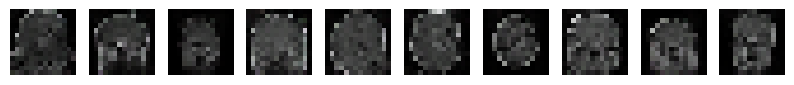

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 1/100 [00:00<00:11,  8.88it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 3/100 [00:00<00:09, 10.28it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 5/100 [00:00<00:08, 10.58it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 7/100 [00:00<00:08, 10.65it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 9/100 [00:00<00:08, 11.01it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 11/100 [00:01<00:08, 11.09it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 13/100 [00:01<00:07, 11.04it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 15/100 [00:01<00:07, 11.23it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 17/100 [00:01<00:07, 10.94it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 19/100 [00:01<00:07, 11.00it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 21/100 [00:01<00:07, 11.07it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 23/100 [00:02<00:06, 11.16it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 25/100 [00:02<00:06, 11.07it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 27/100 [00:02<00:06, 10.99it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 29/100 [00:02<00:06, 11.03it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 31/100 [00:02<00:06, 10.90it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 33/100 [00:03<00:06, 10.88it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 35/100 [00:03<00:05, 10.94it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 37/100 [00:03<00:05, 11.04it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 39/100 [00:03<00:05, 10.98it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 41/100 [00:03<00:05, 10.85it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 43/100 [00:03<00:05, 10.74it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 45/100 [00:04<00:05, 10.80it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 47/100 [00:04<00:04, 10.86it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 49/100 [00:04<00:04, 10.99it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 51/100 [00:04<00:04, 11.16it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 53/100 [00:04<00:04, 11.11it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 55/100 [00:05<00:04, 11.22it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 57/100 [00:05<00:03, 11.30it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 59/100 [00:05<00:03, 11.35it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 61/100 [00:05<00:03, 11.28it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 63/100 [00:05<00:03, 11.43it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 65/100 [00:05<00:03, 11.40it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 67/100 [00:06<00:02, 11.38it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 69/100 [00:06<00:02, 11.46it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 71/100 [00:06<00:02, 11.55it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 73/100 [00:06<00:02, 11.43it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▌  | 75/100 [00:06<00:02, 11.40it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 77/100 [00:06<00:02, 11.47it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 79/100 [00:07<00:03,  5.97it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 81/100 [00:07<00:02,  6.86it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 83/100 [00:08<00:02,  7.63it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 85/100 [00:08<00:01,  8.26it/s]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 87/100 [00:08<00:01,  8.79it/s]

1/1 [==============================] - 0s 21ms/step


 88%|████████▊ | 88/100 [00:08<00:01,  8.77it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 90/100 [00:08<00:01,  9.32it/s]

1/1 [==============================] - 0s 27ms/step


 91%|█████████ | 91/100 [00:08<00:00,  9.42it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 93/100 [00:09<00:00,  9.67it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 95/100 [00:09<00:00,  9.87it/s]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 97/100 [00:09<00:00,  9.70it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 98/100 [00:09<00:00,  9.73it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 1/100 [00:00<00:10,  9.35it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 2/100 [00:00<00:10,  9.62it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 4/100 [00:00<00:09, 10.11it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 6/100 [00:00<00:09, 10.12it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 8/100 [00:00<00:09,  9.65it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 9/100 [00:00<00:09,  9.69it/s]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 10/100 [00:01<00:09,  9.76it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 11/100 [00:01<00:09,  9.80it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 13/100 [00:01<00:08, 10.05it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▌        | 15/100 [00:01<00:08, 10.24it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 17/100 [00:01<00:08,  9.82it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 19/100 [00:01<00:08, 10.01it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 21/100 [00:02<00:07, 10.02it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 23/100 [00:02<00:07, 10.19it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 25/100 [00:02<00:07, 10.32it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 27/100 [00:02<00:07,  9.99it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 29/100 [00:02<00:07, 10.10it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 31/100 [00:03<00:06, 10.16it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 33/100 [00:03<00:06, 10.21it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 35/100 [00:03<00:06, 10.35it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 37/100 [00:03<00:06, 10.12it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 39/100 [00:03<00:06, 10.09it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 41/100 [00:04<00:05, 10.21it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 43/100 [00:04<00:05, 10.19it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 45/100 [00:04<00:05,  9.97it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 46/100 [00:04<00:05,  9.81it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 48/100 [00:04<00:05,  9.81it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 50/100 [00:04<00:04, 10.06it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 52/100 [00:05<00:04, 10.05it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 54/100 [00:05<00:04, 10.00it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 56/100 [00:05<00:04, 10.02it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 58/100 [00:05<00:04, 10.05it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 60/100 [00:05<00:04,  9.98it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 61/100 [00:06<00:03,  9.85it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 63/100 [00:06<00:03, 10.05it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 64/100 [00:06<00:03, 10.02it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 66/100 [00:06<00:03,  9.88it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 68/100 [00:06<00:03,  9.90it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 69/100 [00:06<00:03,  9.82it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 71/100 [00:07<00:02, 10.17it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 73/100 [00:07<00:02, 10.14it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 75/100 [00:07<00:02, 10.29it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 77/100 [00:07<00:02, 10.14it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▉  | 79/100 [00:07<00:02, 10.23it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 81/100 [00:08<00:01, 10.41it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 83/100 [00:08<00:01, 10.27it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 85/100 [00:08<00:01, 10.43it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 87/100 [00:08<00:01, 10.34it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▉ | 89/100 [00:08<00:01, 10.26it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 91/100 [00:09<00:00, 10.52it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 93/100 [00:09<00:00, 10.60it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 95/100 [00:09<00:00, 10.42it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 97/100 [00:09<00:00, 10.37it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 99/100 [00:09<00:00, 10.44it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 2/100 [00:00<00:09, 10.66it/s]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 4/100 [00:00<00:09, 10.37it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 6/100 [00:00<00:09, 10.09it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 8/100 [00:00<00:09, 10.08it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 10/100 [00:00<00:08, 10.23it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 12/100 [00:01<00:08, 10.35it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 14/100 [00:01<00:08, 10.49it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▌        | 16/100 [00:01<00:08, 10.08it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 18/100 [00:01<00:07, 10.35it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 20/100 [00:01<00:07, 10.06it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 22/100 [00:02<00:07, 10.13it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 24/100 [00:02<00:07, 10.11it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 26/100 [00:02<00:07, 10.13it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 28/100 [00:02<00:07, 10.28it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 30/100 [00:02<00:06, 10.19it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 32/100 [00:03<00:06, 10.23it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 34/100 [00:03<00:06, 10.32it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 36/100 [00:03<00:06, 10.18it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 38/100 [00:03<00:06, 10.25it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 40/100 [00:03<00:05, 10.26it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 42/100 [00:04<00:05, 10.32it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 44/100 [00:04<00:05, 10.37it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 46/100 [00:04<00:05, 10.20it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 48/100 [00:04<00:05, 10.31it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 50/100 [00:04<00:04, 10.17it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 52/100 [00:05<00:04, 10.28it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 54/100 [00:05<00:04, 10.36it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 56/100 [00:05<00:04, 10.43it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 58/100 [00:05<00:04, 10.48it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 60/100 [00:05<00:03, 10.51it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 62/100 [00:06<00:03, 10.61it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 64/100 [00:06<00:03, 10.69it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 66/100 [00:06<00:03, 10.50it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 68/100 [00:06<00:03, 10.51it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 70/100 [00:06<00:02, 10.43it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 10.50it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 74/100 [00:07<00:02, 10.21it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 76/100 [00:07<00:02, 10.09it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 78/100 [00:07<00:02, 10.03it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 80/100 [00:07<00:01, 10.11it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 10.12it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 84/100 [00:08<00:01, 10.22it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 86/100 [00:08<00:01, 10.03it/s]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 88/100 [00:08<00:01,  9.90it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 89/100 [00:08<00:01,  9.92it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 90/100 [00:08<00:01,  9.92it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 10.16it/s]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 94/100 [00:09<00:00, 10.30it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 96/100 [00:09<00:00, 10.32it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 98/100 [00:09<00:00, 10.48it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 2/100 [00:00<00:09, 10.36it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 4/100 [00:00<00:09, 10.41it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 6/100 [00:00<00:09, 10.01it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 8/100 [00:00<00:09, 10.15it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 10/100 [00:00<00:08, 10.16it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 12/100 [00:01<00:08, 10.41it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 14/100 [00:01<00:08, 10.40it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 16/100 [00:01<00:08, 10.02it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 18/100 [00:01<00:07, 10.27it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 20/100 [00:01<00:07, 10.43it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 22/100 [00:02<00:07, 10.50it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 24/100 [00:02<00:07, 10.37it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 26/100 [00:02<00:07, 10.17it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 28/100 [00:02<00:06, 10.38it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 30/100 [00:02<00:06, 10.49it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 32/100 [00:03<00:06, 10.59it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 34/100 [00:03<00:06, 10.25it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 36/100 [00:03<00:06,  9.77it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 37/100 [00:03<00:06,  9.80it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 39/100 [00:03<00:06,  9.93it/s]

1/1 [==============================] - 0s 23ms/step


 40%|████      | 40/100 [00:03<00:06,  9.87it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 42/100 [00:04<00:05, 10.08it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 44/100 [00:04<00:05, 10.32it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 46/100 [00:04<00:05, 10.27it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 48/100 [00:04<00:05, 10.12it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 50/100 [00:04<00:04, 10.12it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 52/100 [00:05<00:04, 10.12it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 54/100 [00:05<00:04, 10.19it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 56/100 [00:05<00:04,  9.98it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 57/100 [00:05<00:04,  9.98it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 58/100 [00:05<00:04,  9.96it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 59/100 [00:05<00:04,  9.86it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 61/100 [00:05<00:03, 10.16it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 63/100 [00:06<00:03, 10.28it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 65/100 [00:06<00:03, 10.25it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 67/100 [00:06<00:03, 10.58it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 69/100 [00:06<00:02, 10.37it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 71/100 [00:06<00:02, 10.45it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 73/100 [00:07<00:02, 10.36it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 75/100 [00:07<00:02, 10.34it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 77/100 [00:07<00:02, 10.47it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 79/100 [00:07<00:01, 10.62it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 81/100 [00:07<00:01, 10.87it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 83/100 [00:08<00:01, 10.83it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 85/100 [00:08<00:01, 10.73it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 87/100 [00:08<00:01, 10.88it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 89/100 [00:08<00:01, 10.84it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 91/100 [00:08<00:00, 10.71it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 93/100 [00:08<00:00, 10.90it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 95/100 [00:09<00:00, 10.50it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 97/100 [00:09<00:00, 10.49it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 99/100 [00:09<00:00, 10.57it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 2/100 [00:00<00:08, 11.01it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 4/100 [00:00<00:08, 11.30it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 6/100 [00:00<00:08, 10.48it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 8/100 [00:00<00:08, 10.54it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 10/100 [00:00<00:08, 10.43it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 12/100 [00:01<00:08, 10.49it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 14/100 [00:01<00:08, 10.21it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 16/100 [00:01<00:08, 10.41it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 18/100 [00:01<00:07, 10.63it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 20/100 [00:01<00:07, 10.56it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 22/100 [00:02<00:07, 10.68it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 24/100 [00:02<00:07, 10.64it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 26/100 [00:02<00:06, 10.69it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 28/100 [00:02<00:06, 10.67it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 30/100 [00:02<00:06, 10.67it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 32/100 [00:03<00:06, 10.70it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 34/100 [00:03<00:06, 10.59it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 36/100 [00:03<00:05, 10.76it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 38/100 [00:03<00:05, 10.74it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 40/100 [00:03<00:05, 10.71it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 42/100 [00:03<00:05, 10.85it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 44/100 [00:04<00:05, 10.64it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 46/100 [00:04<00:05, 10.78it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 48/100 [00:04<00:04, 10.83it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 50/100 [00:04<00:04, 10.88it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 10.94it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 54/100 [00:05<00:04, 10.89it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 56/100 [00:05<00:04, 10.99it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 11.03it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 60/100 [00:05<00:03, 10.95it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 11.05it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 10.94it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 66/100 [00:06<00:03, 10.76it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 68/100 [00:06<00:02, 10.93it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 70/100 [00:06<00:02, 10.86it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 11.00it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 10.74it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 76/100 [00:07<00:02, 10.50it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 78/100 [00:07<00:02, 10.46it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 80/100 [00:07<00:01, 10.59it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 10.63it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 10.00it/s]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 86/100 [00:08<00:01, 10.04it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 88/100 [00:08<00:01, 10.05it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 90/100 [00:08<00:00, 10.05it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 10.37it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 10.50it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 96/100 [00:09<00:00, 10.58it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 98/100 [00:09<00:00, 10.37it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 2/100 [00:00<00:09, 10.89it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 4/100 [00:00<00:08, 10.75it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 6/100 [00:00<00:08, 11.00it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 8/100 [00:00<00:08, 10.77it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 10/100 [00:00<00:08, 10.69it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 12/100 [00:01<00:08, 10.66it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 14/100 [00:01<00:08, 10.44it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 16/100 [00:01<00:07, 10.58it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 18/100 [00:01<00:07, 10.83it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 20/100 [00:01<00:07, 10.88it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 22/100 [00:02<00:07, 10.63it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 24/100 [00:02<00:07, 10.63it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 26/100 [00:02<00:06, 10.58it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 28/100 [00:02<00:06, 10.57it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 30/100 [00:02<00:06, 10.62it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 32/100 [00:02<00:06, 10.72it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 34/100 [00:03<00:06, 10.62it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 36/100 [00:03<00:05, 10.80it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 38/100 [00:03<00:05, 10.81it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 40/100 [00:03<00:05, 10.81it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 42/100 [00:03<00:05, 10.83it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 44/100 [00:04<00:05, 10.71it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 46/100 [00:04<00:04, 10.85it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 48/100 [00:04<00:04, 10.94it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 50/100 [00:04<00:04, 10.96it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 11.01it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 54/100 [00:05<00:04, 10.60it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 56/100 [00:05<00:04, 10.64it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 58/100 [00:05<00:04, 10.47it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 60/100 [00:05<00:03, 10.58it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 10.47it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 10.39it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 66/100 [00:06<00:03, 10.53it/s]

1/1 [==============================] - 0s 20ms/step


 68%|██████▊   | 68/100 [00:06<00:03, 10.64it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 70/100 [00:06<00:02, 10.69it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 10.57it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 10.60it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 76/100 [00:07<00:02, 10.60it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 78/100 [00:07<00:02, 10.75it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 80/100 [00:07<00:01, 10.95it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 10.85it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 10.94it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 86/100 [00:08<00:01, 10.68it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 88/100 [00:08<00:01, 10.82it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 90/100 [00:08<00:00, 10.81it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 10.48it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 10.53it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 10.71it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 98/100 [00:09<00:00, 10.50it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 1/100 [00:00<00:10,  9.66it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 2/100 [00:00<00:10,  9.79it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 4/100 [00:00<00:09, 10.44it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 6/100 [00:00<00:09, 10.42it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 8/100 [00:00<00:08, 10.52it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 10/100 [00:00<00:08, 10.62it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 12/100 [00:01<00:08, 10.32it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 14/100 [00:01<00:08, 10.06it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 16/100 [00:01<00:08, 10.09it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 18/100 [00:01<00:08, 10.06it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 20/100 [00:01<00:07, 10.24it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 22/100 [00:02<00:07,  9.98it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 24/100 [00:02<00:07, 10.18it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 26/100 [00:02<00:07, 10.46it/s]

1/1 [==============================] - 0s 20ms/step


 28%|██▊       | 28/100 [00:02<00:06, 10.44it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 30/100 [00:02<00:06, 10.59it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 32/100 [00:03<00:06, 10.71it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 34/100 [00:03<00:06, 10.77it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 36/100 [00:03<00:05, 10.85it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 38/100 [00:03<00:05, 10.76it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 40/100 [00:03<00:05, 10.66it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 42/100 [00:04<00:05, 10.71it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 44/100 [00:04<00:05, 10.91it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 46/100 [00:04<00:04, 11.00it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 48/100 [00:04<00:04, 11.04it/s]

1/1 [==============================] - 0s 20ms/step


 50%|█████     | 50/100 [00:04<00:04, 10.92it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 10.86it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 54/100 [00:05<00:04, 10.85it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 56/100 [00:05<00:04, 10.82it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 10.81it/s]

1/1 [==============================] - 0s 20ms/step


 60%|██████    | 60/100 [00:05<00:03, 10.84it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 10.73it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 64/100 [00:06<00:03, 10.58it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 66/100 [00:06<00:03, 10.54it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 68/100 [00:06<00:03, 10.61it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 70/100 [00:06<00:02, 10.51it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 10.38it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 74/100 [00:07<00:02, 10.50it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 76/100 [00:07<00:02, 10.76it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 78/100 [00:07<00:02, 10.82it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 80/100 [00:07<00:01, 10.85it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 10.52it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 10.67it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 86/100 [00:08<00:01, 10.91it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 88/100 [00:08<00:01, 10.95it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 90/100 [00:08<00:00, 10.93it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 10.74it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 10.82it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 96/100 [00:09<00:00, 10.92it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 98/100 [00:09<00:00, 10.88it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 1/100 [00:00<00:10,  9.71it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 2/100 [00:00<00:10,  9.34it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 3/100 [00:00<00:10,  9.55it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 4/100 [00:00<00:10,  9.35it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 6/100 [00:00<00:09, 10.30it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 8/100 [00:00<00:08, 10.72it/s]

1/1 [==============================] - 0s 22ms/step


 10%|█         | 10/100 [00:00<00:08, 10.61it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 12/100 [00:01<00:08, 10.51it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 14/100 [00:01<00:08, 10.37it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 16/100 [00:01<00:07, 10.53it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 18/100 [00:01<00:07, 10.70it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 20/100 [00:01<00:07, 10.70it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 22/100 [00:02<00:07, 10.66it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 24/100 [00:02<00:07, 10.46it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 26/100 [00:02<00:06, 10.58it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 28/100 [00:02<00:06, 10.61it/s]

1/1 [==============================] - 0s 20ms/step


 30%|███       | 30/100 [00:02<00:06, 10.48it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 32/100 [00:03<00:06, 10.50it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 34/100 [00:03<00:06, 10.61it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 36/100 [00:03<00:06, 10.52it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 38/100 [00:03<00:06, 10.24it/s]

1/1 [==============================] - 0s 24ms/step


 40%|████      | 40/100 [00:03<00:05, 10.35it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 42/100 [00:04<00:05, 10.12it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 44/100 [00:04<00:05, 10.17it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 46/100 [00:04<00:05, 10.19it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 48/100 [00:04<00:05, 10.32it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 50/100 [00:04<00:04, 10.26it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 52/100 [00:05<00:04, 10.09it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 54/100 [00:05<00:04,  9.85it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 56/100 [00:05<00:04, 10.09it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 58/100 [00:05<00:04, 10.36it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 60/100 [00:05<00:03, 10.69it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 10.74it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 64/100 [00:06<00:03, 11.00it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 66/100 [00:06<00:03, 11.06it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 68/100 [00:06<00:02, 11.13it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 70/100 [00:06<00:02, 11.13it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 10.88it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 74/100 [00:07<00:02, 10.88it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▌  | 76/100 [00:07<00:02, 10.56it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 78/100 [00:07<00:02, 10.46it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 80/100 [00:07<00:01, 10.52it/s]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 10.34it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 84/100 [00:08<00:01, 10.33it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 86/100 [00:08<00:01, 10.53it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 88/100 [00:08<00:01, 10.52it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 90/100 [00:08<00:00, 10.81it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 10.40it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 10.53it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 96/100 [00:09<00:00, 10.52it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 98/100 [00:09<00:00, 10.63it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 2/100 [00:00<00:09, 10.13it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 4/100 [00:00<00:08, 10.88it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 6/100 [00:00<00:08, 10.83it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 8/100 [00:00<00:08, 10.93it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 10/100 [00:00<00:08, 11.07it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 12/100 [00:01<00:08, 10.73it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 14/100 [00:01<00:07, 10.76it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 16/100 [00:01<00:07, 10.74it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 18/100 [00:01<00:07, 10.75it/s]

1/1 [==============================] - 0s 23ms/step


 20%|██        | 20/100 [00:01<00:07, 10.70it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 22/100 [00:02<00:07, 10.71it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 24/100 [00:02<00:07, 10.84it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 26/100 [00:02<00:06, 10.89it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 28/100 [00:02<00:06, 11.08it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 30/100 [00:02<00:06, 11.19it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 32/100 [00:02<00:06, 11.01it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 34/100 [00:03<00:05, 11.14it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 36/100 [00:03<00:05, 11.18it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 38/100 [00:03<00:05, 11.08it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 40/100 [00:03<00:05, 11.30it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 42/100 [00:03<00:05, 10.81it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 44/100 [00:04<00:05, 10.98it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 46/100 [00:04<00:04, 10.89it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 48/100 [00:04<00:04, 10.92it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 50/100 [00:04<00:04, 11.12it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 10.82it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 54/100 [00:04<00:04, 10.72it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 56/100 [00:05<00:04, 10.83it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 10.92it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 60/100 [00:05<00:03, 11.06it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 11.00it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 10.61it/s]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 66/100 [00:06<00:03, 10.37it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 68/100 [00:06<00:03, 10.45it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 70/100 [00:06<00:02, 10.63it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 10.28it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 10.33it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 76/100 [00:07<00:02, 10.37it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 78/100 [00:07<00:02, 10.50it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 80/100 [00:07<00:01, 10.26it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 10.09it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 10.19it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 86/100 [00:08<00:01, 10.30it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 88/100 [00:08<00:01, 10.20it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 90/100 [00:08<00:00, 10.38it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 10.59it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 10.72it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 10.84it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 98/100 [00:09<00:00, 10.85it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 2/100 [00:00<00:09, 10.71it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 4/100 [00:00<00:08, 10.97it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 6/100 [00:00<00:08, 10.69it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 8/100 [00:00<00:08, 10.81it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 10/100 [00:00<00:08, 10.83it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 12/100 [00:01<00:08, 10.69it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 14/100 [00:01<00:08, 10.67it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 16/100 [00:01<00:07, 10.92it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 18/100 [00:01<00:07, 10.93it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 20/100 [00:01<00:07, 11.05it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 22/100 [00:02<00:07, 10.79it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 24/100 [00:02<00:07, 10.84it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 26/100 [00:02<00:06, 10.86it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 28/100 [00:02<00:06, 10.90it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 30/100 [00:02<00:06, 11.02it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 32/100 [00:02<00:06, 11.00it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 34/100 [00:03<00:05, 11.15it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 36/100 [00:03<00:05, 11.15it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 38/100 [00:03<00:05, 11.18it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 40/100 [00:03<00:05, 11.05it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 42/100 [00:03<00:05, 10.90it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 44/100 [00:04<00:05, 10.90it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 46/100 [00:04<00:04, 10.80it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 48/100 [00:04<00:04, 11.04it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 50/100 [00:04<00:04, 11.16it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 10.95it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 54/100 [00:04<00:04, 10.99it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 56/100 [00:05<00:03, 11.18it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 11.09it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 60/100 [00:05<00:03, 10.96it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 10.99it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 11.08it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 66/100 [00:06<00:03, 11.23it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 68/100 [00:06<00:02, 11.37it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 70/100 [00:06<00:02, 11.33it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 11.20it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 11.18it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 11.11it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 78/100 [00:07<00:01, 11.19it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 80/100 [00:07<00:01, 11.13it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 11.03it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 11.10it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 11.21it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 88/100 [00:07<00:01, 11.28it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 90/100 [00:08<00:00, 11.18it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 10.99it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 10.70it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 10.74it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 10.64it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 100/100 [00:09<00:00, 10.98it/s]


Epoch 91, D Loss: 0.4392, D Acc: 84.38%, G Loss: 1.8921
1/1 [==============================] - 0s 21ms/step


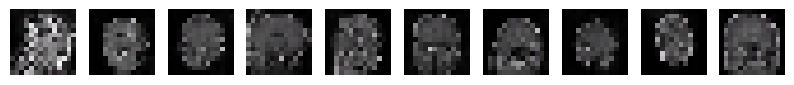

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 1/100 [00:00<00:10,  9.04it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 2/100 [00:00<00:10,  9.30it/s]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 4/100 [00:00<00:09,  9.86it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 6/100 [00:00<00:09,  9.96it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 8/100 [00:00<00:09, 10.19it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 10/100 [00:01<00:08, 10.10it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 12/100 [00:01<00:08, 10.13it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 14/100 [00:01<00:08, 10.33it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 16/100 [00:01<00:08,  9.94it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 18/100 [00:01<00:08, 10.16it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 20/100 [00:01<00:07, 10.24it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 22/100 [00:02<00:07, 10.23it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 24/100 [00:02<00:07, 10.56it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 26/100 [00:02<00:06, 10.59it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 28/100 [00:02<00:06, 10.77it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 30/100 [00:02<00:06, 10.99it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 32/100 [00:03<00:06, 10.94it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 34/100 [00:03<00:06, 10.95it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 36/100 [00:03<00:05, 10.84it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 38/100 [00:03<00:05, 10.86it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 40/100 [00:03<00:05, 10.99it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 42/100 [00:03<00:05, 11.14it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 44/100 [00:04<00:05, 11.01it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 46/100 [00:04<00:04, 10.87it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 48/100 [00:04<00:04, 10.89it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 50/100 [00:04<00:04, 11.01it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 10.92it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 54/100 [00:05<00:04, 10.98it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 56/100 [00:05<00:04, 10.81it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 10.77it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 60/100 [00:05<00:03, 10.84it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 11.06it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 11.20it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 66/100 [00:06<00:03, 11.07it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 68/100 [00:06<00:02, 11.19it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 70/100 [00:06<00:02, 11.08it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 11.08it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 11.30it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 76/100 [00:07<00:02, 11.16it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 78/100 [00:07<00:01, 11.15it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 80/100 [00:07<00:01, 11.00it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 10.97it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 11.03it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 10.95it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 88/100 [00:08<00:01, 10.99it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 90/100 [00:08<00:00, 11.20it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 11.28it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 11.13it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 11.04it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 98/100 [00:09<00:00, 11.06it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 2/100 [00:00<00:08, 11.99it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 4/100 [00:00<00:08, 11.55it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 6/100 [00:00<00:08, 11.05it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 8/100 [00:00<00:08, 11.14it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 10/100 [00:00<00:08, 10.84it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 12/100 [00:01<00:07, 11.20it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 14/100 [00:01<00:07, 11.28it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 16/100 [00:01<00:07, 11.24it/s]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 18/100 [00:01<00:07, 11.12it/s]

1/1 [==============================] - 0s 20ms/step


 20%|██        | 20/100 [00:01<00:07, 11.09it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 22/100 [00:01<00:07, 11.02it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 24/100 [00:02<00:06, 11.12it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 26/100 [00:02<00:06, 10.90it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 28/100 [00:02<00:06, 11.04it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 30/100 [00:02<00:06, 11.10it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 32/100 [00:02<00:06, 11.21it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 34/100 [00:03<00:06, 10.87it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 36/100 [00:03<00:05, 10.76it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 38/100 [00:03<00:05, 10.47it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 40/100 [00:03<00:05, 10.73it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 42/100 [00:03<00:05, 10.66it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 44/100 [00:04<00:05, 10.77it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 46/100 [00:04<00:05, 10.69it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 48/100 [00:04<00:04, 10.72it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 50/100 [00:04<00:04, 10.46it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 10.27it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 54/100 [00:04<00:04, 10.38it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 56/100 [00:05<00:04, 10.41it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 58/100 [00:05<00:04, 10.36it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 60/100 [00:05<00:03, 10.58it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 10.67it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 10.64it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 66/100 [00:06<00:03, 10.60it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 68/100 [00:06<00:02, 10.75it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 70/100 [00:06<00:02, 10.74it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 10.82it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 10.85it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 76/100 [00:07<00:02, 10.85it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 78/100 [00:07<00:02, 10.99it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 80/100 [00:07<00:01, 10.84it/s]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 10.74it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 10.77it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 10.86it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 88/100 [00:08<00:01, 11.12it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 90/100 [00:08<00:00, 11.32it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 11.40it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 11.17it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 10.96it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 98/100 [00:09<00:00, 11.09it/s]

1/1 [==============================] - 0s 23ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 2/100 [00:00<00:08, 10.94it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 4/100 [00:00<00:08, 11.10it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 6/100 [00:00<00:08, 10.92it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 8/100 [00:00<00:08, 10.91it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 10/100 [00:00<00:08, 10.91it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 12/100 [00:01<00:07, 11.08it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 14/100 [00:01<00:07, 11.04it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 16/100 [00:01<00:07, 11.00it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 18/100 [00:01<00:07, 11.10it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 20/100 [00:01<00:07, 11.24it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 22/100 [00:01<00:06, 11.37it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 24/100 [00:02<00:06, 11.34it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 26/100 [00:02<00:06, 11.17it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 28/100 [00:02<00:06, 11.13it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 30/100 [00:02<00:06, 11.28it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 32/100 [00:02<00:06, 11.14it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 34/100 [00:03<00:05, 11.09it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 36/100 [00:03<00:05, 11.10it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 38/100 [00:03<00:05, 10.95it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 40/100 [00:03<00:05, 10.93it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 42/100 [00:03<00:05, 11.14it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 44/100 [00:03<00:04, 11.24it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 46/100 [00:04<00:04, 10.93it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 48/100 [00:04<00:04, 11.01it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 50/100 [00:04<00:04, 10.92it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 11.02it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 54/100 [00:04<00:04, 11.07it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 56/100 [00:05<00:04, 10.92it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 11.10it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 60/100 [00:05<00:03, 11.00it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 11.08it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 11.14it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 66/100 [00:05<00:03, 10.96it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 68/100 [00:06<00:02, 11.03it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 70/100 [00:06<00:02, 10.90it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 10.55it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 10.58it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 10.74it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 78/100 [00:07<00:02, 10.95it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 80/100 [00:07<00:01, 11.00it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 11.03it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 10.98it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 10.56it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 88/100 [00:08<00:01, 10.72it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 90/100 [00:08<00:00, 10.70it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 10.63it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 10.20it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 10.26it/s]

1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 10.50it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 2/100 [00:00<00:08, 10.93it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 4/100 [00:00<00:08, 10.97it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 6/100 [00:00<00:08, 10.84it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 8/100 [00:00<00:08, 11.01it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 10/100 [00:00<00:08, 10.95it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 12/100 [00:01<00:08, 10.98it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 14/100 [00:01<00:07, 10.77it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 16/100 [00:01<00:08, 10.49it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 18/100 [00:01<00:07, 10.74it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 20/100 [00:01<00:07, 10.72it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 22/100 [00:02<00:07, 10.78it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 24/100 [00:02<00:06, 11.07it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 26/100 [00:02<00:06, 11.08it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 28/100 [00:02<00:06, 11.06it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 30/100 [00:02<00:06, 11.25it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 32/100 [00:02<00:06, 11.31it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 34/100 [00:03<00:05, 11.37it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 36/100 [00:03<00:05, 11.38it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 38/100 [00:03<00:05, 11.30it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 40/100 [00:03<00:05, 11.41it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 42/100 [00:03<00:05, 11.40it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 44/100 [00:03<00:04, 11.43it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 46/100 [00:04<00:04, 11.27it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 48/100 [00:04<00:04, 11.41it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 50/100 [00:04<00:04, 11.35it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 11.26it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 54/100 [00:04<00:04, 11.34it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 56/100 [00:05<00:03, 11.40it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 11.51it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 60/100 [00:05<00:03, 11.45it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 11.33it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 11.44it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 66/100 [00:05<00:02, 11.38it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 68/100 [00:06<00:02, 11.44it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 70/100 [00:06<00:02, 11.44it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 11.27it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 11.32it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 11.25it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 78/100 [00:06<00:01, 11.33it/s]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 80/100 [00:07<00:01, 11.19it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 11.31it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 11.30it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 10.95it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 88/100 [00:07<00:01, 11.11it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 90/100 [00:08<00:00, 11.17it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 11.10it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 11.23it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 11.19it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 11.18it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 2/100 [00:00<00:08, 11.23it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 4/100 [00:00<00:08, 11.42it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 6/100 [00:00<00:08, 10.98it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 8/100 [00:00<00:08, 10.84it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 10/100 [00:00<00:08, 10.86it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 12/100 [00:01<00:07, 11.10it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 14/100 [00:01<00:07, 11.22it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 16/100 [00:01<00:07, 11.21it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 18/100 [00:01<00:07, 11.18it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 20/100 [00:01<00:07, 11.24it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 22/100 [00:01<00:06, 11.23it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 24/100 [00:02<00:06, 11.30it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 26/100 [00:02<00:06, 11.04it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 28/100 [00:02<00:06, 10.91it/s]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 30/100 [00:02<00:06, 10.64it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 32/100 [00:02<00:06, 10.37it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 34/100 [00:03<00:06, 10.35it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 36/100 [00:03<00:06, 10.48it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 38/100 [00:03<00:05, 10.36it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 40/100 [00:03<00:05, 10.62it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 42/100 [00:03<00:05, 10.75it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 44/100 [00:04<00:05, 10.94it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 46/100 [00:04<00:04, 11.06it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 48/100 [00:04<00:04, 10.84it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 50/100 [00:04<00:04, 10.92it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 10.76it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 54/100 [00:04<00:04, 10.92it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 56/100 [00:05<00:04, 10.90it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 10.76it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 60/100 [00:05<00:03, 10.91it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 11.12it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 10.96it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 66/100 [00:06<00:03, 10.95it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 68/100 [00:06<00:02, 10.70it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 70/100 [00:06<00:02, 10.91it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 11.12it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 11.28it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 11.44it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 78/100 [00:07<00:01, 11.23it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 80/100 [00:07<00:01, 11.15it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 11.28it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 11.19it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 11.28it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 88/100 [00:08<00:01, 11.11it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 90/100 [00:08<00:00, 11.27it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 11.53it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 11.65it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 11.62it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 11.39it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  2%|▏         | 2/100 [00:00<00:08, 11.30it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 4/100 [00:00<00:08, 11.71it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 6/100 [00:00<00:08, 11.46it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 8/100 [00:00<00:07, 11.52it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 10/100 [00:00<00:07, 11.50it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 12/100 [00:01<00:07, 11.45it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 14/100 [00:01<00:07, 11.34it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 16/100 [00:01<00:07, 11.33it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 18/100 [00:01<00:07, 11.38it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 20/100 [00:01<00:06, 11.45it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 22/100 [00:01<00:06, 11.49it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 24/100 [00:02<00:06, 11.47it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 26/100 [00:02<00:06, 11.42it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 28/100 [00:02<00:06, 11.25it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 30/100 [00:02<00:06, 11.30it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 32/100 [00:02<00:06, 11.31it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 34/100 [00:02<00:05, 11.35it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 36/100 [00:03<00:05, 11.30it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 38/100 [00:03<00:05, 11.23it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 40/100 [00:03<00:05, 11.21it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 42/100 [00:03<00:05, 11.39it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 44/100 [00:03<00:04, 11.55it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 46/100 [00:04<00:04, 11.39it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 48/100 [00:04<00:04, 11.11it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 50/100 [00:04<00:04, 10.78it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 52/100 [00:04<00:04, 10.99it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 54/100 [00:04<00:04, 11.11it/s]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 56/100 [00:04<00:04, 10.96it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 58/100 [00:05<00:03, 10.80it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 60/100 [00:05<00:03, 10.81it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 62/100 [00:05<00:03, 11.09it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 64/100 [00:05<00:03, 11.10it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 66/100 [00:05<00:03, 10.91it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 68/100 [00:06<00:02, 10.71it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 70/100 [00:06<00:02, 10.67it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 72/100 [00:06<00:02, 10.68it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 74/100 [00:06<00:02, 10.81it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 76/100 [00:06<00:02, 11.04it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 78/100 [00:06<00:02, 10.99it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 80/100 [00:07<00:01, 11.00it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 82/100 [00:07<00:01, 11.00it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 84/100 [00:07<00:01, 11.12it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 86/100 [00:07<00:01, 11.17it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 88/100 [00:07<00:01, 11.10it/s]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 90/100 [00:08<00:00, 11.00it/s]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 10.92it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 94/100 [00:08<00:00, 11.04it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 96/100 [00:08<00:00, 11.26it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 98/100 [00:08<00:00, 11.28it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 2/100 [00:00<00:08, 11.41it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 4/100 [00:00<00:08, 11.50it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 6/100 [00:00<00:08, 11.12it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 8/100 [00:00<00:08, 11.15it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 10/100 [00:00<00:08, 10.58it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 12/100 [00:01<00:08, 10.72it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 14/100 [00:01<00:07, 10.97it/s]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 16/100 [00:01<00:07, 10.87it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 18/100 [00:01<00:07, 10.73it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 20/100 [00:01<00:07, 10.82it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 22/100 [00:02<00:07, 10.96it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 24/100 [00:02<00:07, 10.83it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 26/100 [00:02<00:06, 10.66it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 28/100 [00:03<00:12,  5.54it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 29/100 [00:03<00:11,  6.02it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 31/100 [00:03<00:10,  6.81it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 33/100 [00:03<00:08,  7.61it/s]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 34/100 [00:03<00:08,  7.94it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 35/100 [00:03<00:07,  8.15it/s]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 36/100 [00:03<00:07,  8.35it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 38/100 [00:04<00:07,  8.61it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 39/100 [00:04<00:07,  8.36it/s]

1/1 [==============================] - 0s 28ms/step


 40%|████      | 40/100 [00:04<00:07,  8.26it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 41/100 [00:04<00:06,  8.51it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 43/100 [00:04<00:06,  9.13it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▍     | 44/100 [00:04<00:06,  9.25it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 45/100 [00:04<00:05,  9.37it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 46/100 [00:05<00:05,  9.21it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 47/100 [00:05<00:05,  9.14it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 49/100 [00:05<00:05,  9.59it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 50/100 [00:05<00:05,  9.53it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 52/100 [00:05<00:04,  9.86it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 53/100 [00:05<00:04,  9.84it/s]

1/1 [==============================] - 0s 23ms/step


 54%|█████▍    | 54/100 [00:05<00:04,  9.80it/s]

1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 55/100 [00:06<00:04,  9.40it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 57/100 [00:06<00:04,  9.70it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 58/100 [00:06<00:04,  9.56it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 59/100 [00:06<00:04,  9.14it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 60/100 [00:06<00:04,  9.33it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 61/100 [00:06<00:04,  9.29it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 63/100 [00:06<00:03,  9.73it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 64/100 [00:06<00:03,  9.78it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 65/100 [00:07<00:03,  9.37it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 67/100 [00:07<00:03,  9.35it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 68/100 [00:07<00:03,  9.34it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 69/100 [00:07<00:03,  9.27it/s]

1/1 [==============================] - 0s 26ms/step


 70%|███████   | 70/100 [00:07<00:03,  9.36it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 71/100 [00:07<00:03,  9.42it/s]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 72/100 [00:07<00:03,  9.29it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 73/100 [00:07<00:02,  9.02it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 74/100 [00:08<00:02,  8.67it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 75/100 [00:08<00:02,  8.88it/s]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 76/100 [00:08<00:02,  8.85it/s]

1/1 [==============================] - 0s 26ms/step


 78%|███████▊  | 78/100 [00:08<00:02,  9.06it/s]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 80/100 [00:08<00:02,  9.62it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 81/100 [00:08<00:01,  9.63it/s]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 82/100 [00:08<00:01,  9.64it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 83/100 [00:09<00:01,  9.45it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▍ | 84/100 [00:09<00:01,  9.33it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 85/100 [00:09<00:01,  9.24it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 86/100 [00:09<00:01,  9.36it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 87/100 [00:09<00:01,  8.95it/s]

1/1 [==============================] - 0s 20ms/step


 88%|████████▊ | 88/100 [00:09<00:01,  9.11it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 89/100 [00:09<00:01,  9.33it/s]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 90/100 [00:09<00:01,  9.50it/s]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 92/100 [00:09<00:00,  9.87it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 93/100 [00:10<00:00,  9.85it/s]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 94/100 [00:10<00:00,  9.45it/s]

1/1 [==============================] - 0s 27ms/step


 95%|█████████▌| 95/100 [00:10<00:00,  9.24it/s]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 96/100 [00:10<00:00,  9.35it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 97/100 [00:10<00:00,  9.33it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 99/100 [00:10<00:00,  9.75it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 2/100 [00:00<00:09, 10.88it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 4/100 [00:00<00:09, 10.21it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 6/100 [00:00<00:09, 10.06it/s]

1/1 [==============================] - 0s 20ms/step


  8%|▊         | 8/100 [00:00<00:08, 10.23it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 10/100 [00:00<00:08, 10.35it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 12/100 [00:01<00:08, 10.44it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 14/100 [00:01<00:08, 10.27it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▌        | 16/100 [00:01<00:08, 10.38it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 18/100 [00:01<00:07, 10.31it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 20/100 [00:01<00:07, 10.29it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 22/100 [00:02<00:07, 10.17it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 24/100 [00:02<00:07, 10.12it/s]

1/1 [==============================] - 0s 20ms/step


 26%|██▌       | 26/100 [00:02<00:07, 10.34it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 28/100 [00:02<00:07, 10.20it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 30/100 [00:02<00:06, 10.23it/s]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 32/100 [00:03<00:06, 10.29it/s]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 34/100 [00:03<00:06, 10.14it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 36/100 [00:03<00:06, 10.19it/s]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 38/100 [00:03<00:06, 10.20it/s]

1/1 [==============================] - 0s 21ms/step


 40%|████      | 40/100 [00:03<00:05, 10.24it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 42/100 [00:04<00:05, 10.31it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 44/100 [00:04<00:05, 10.01it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▌     | 46/100 [00:04<00:05, 10.13it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 48/100 [00:04<00:05,  9.92it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 50/100 [00:04<00:04, 10.19it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 52/100 [00:05<00:04, 10.39it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 54/100 [00:05<00:04, 10.26it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 56/100 [00:05<00:04, 10.39it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 58/100 [00:05<00:04, 10.36it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 60/100 [00:05<00:03, 10.40it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 62/100 [00:06<00:03, 10.38it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 64/100 [00:06<00:03, 10.15it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 66/100 [00:06<00:03, 10.20it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 68/100 [00:06<00:03, 10.05it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 70/100 [00:06<00:02, 10.11it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 72/100 [00:07<00:02, 10.07it/s]

1/1 [==============================] - 0s 20ms/step


 74%|███████▍  | 74/100 [00:07<00:02, 10.06it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 76/100 [00:07<00:02,  9.83it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 78/100 [00:07<00:02, 10.03it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 80/100 [00:07<00:01, 10.23it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 82/100 [00:08<00:01, 10.17it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 84/100 [00:08<00:01, 10.21it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 86/100 [00:08<00:01, 10.40it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 88/100 [00:08<00:01, 10.28it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 90/100 [00:08<00:00, 10.28it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 92/100 [00:08<00:00, 10.32it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▍| 94/100 [00:09<00:00, 10.21it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 96/100 [00:09<00:00, 10.36it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 98/100 [00:09<00:00, 10.27it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 2/100 [00:00<00:09, 10.16it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 4/100 [00:00<00:09,  9.87it/s]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 6/100 [00:00<00:09, 10.22it/s]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 8/100 [00:00<00:09,  9.89it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 10/100 [00:00<00:08, 10.08it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 12/100 [00:01<00:08, 10.30it/s]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 14/100 [00:01<00:08, 10.11it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 16/100 [00:01<00:08,  9.96it/s]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 17/100 [00:01<00:08,  9.88it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 18/100 [00:01<00:08,  9.74it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 19/100 [00:01<00:08,  9.40it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 20/100 [00:02<00:08,  9.18it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 21/100 [00:02<00:08,  9.30it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 22/100 [00:02<00:08,  9.46it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 23/100 [00:02<00:08,  9.48it/s]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 25/100 [00:02<00:07,  9.84it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 27/100 [00:02<00:07, 10.15it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 29/100 [00:02<00:06, 10.26it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 31/100 [00:03<00:06, 10.50it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 33/100 [00:03<00:06, 10.48it/s]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 35/100 [00:03<00:06, 10.41it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 37/100 [00:03<00:06, 10.26it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 39/100 [00:03<00:05, 10.44it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 41/100 [00:04<00:05, 10.54it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 43/100 [00:04<00:05, 10.46it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 45/100 [00:04<00:05, 10.55it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 47/100 [00:04<00:05, 10.52it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 49/100 [00:04<00:04, 10.48it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 51/100 [00:05<00:04, 10.51it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 53/100 [00:05<00:04, 10.40it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 55/100 [00:05<00:04, 10.43it/s]

1/1 [==============================] - 0s 22ms/step


 57%|█████▋    | 57/100 [00:05<00:04, 10.08it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 59/100 [00:05<00:04, 10.09it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 61/100 [00:06<00:04,  9.67it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 62/100 [00:06<00:03,  9.64it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 63/100 [00:06<00:03,  9.59it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 65/100 [00:06<00:03,  9.76it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 66/100 [00:06<00:03,  9.59it/s]

1/1 [==============================] - 0s 25ms/step


 67%|██████▋   | 67/100 [00:06<00:03,  9.57it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 68/100 [00:06<00:03,  9.67it/s]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 69/100 [00:06<00:03,  9.38it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 70/100 [00:06<00:03,  9.38it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████   | 71/100 [00:07<00:03,  9.48it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 72/100 [00:07<00:02,  9.35it/s]

1/1 [==============================] - 0s 26ms/step


 74%|███████▍  | 74/100 [00:07<00:02,  9.55it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▌  | 75/100 [00:07<00:02,  9.45it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 76/100 [00:07<00:02,  9.51it/s]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 77/100 [00:07<00:02,  9.40it/s]

1/1 [==============================] - 0s 22ms/step


 78%|███████▊  | 78/100 [00:07<00:02,  9.33it/s]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 80/100 [00:08<00:02,  9.52it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████  | 81/100 [00:08<00:02,  9.49it/s]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 82/100 [00:08<00:01,  9.18it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 83/100 [00:08<00:01,  9.28it/s]

1/1 [==============================] - 0s 25ms/step


 84%|████████▍ | 84/100 [00:08<00:01,  9.30it/s]

1/1 [==============================] - 0s 25ms/step


 85%|████████▌ | 85/100 [00:08<00:01,  9.48it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 87/100 [00:08<00:01,  9.91it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 89/100 [00:08<00:01, 10.29it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 91/100 [00:09<00:00, 10.23it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 93/100 [00:09<00:00, 10.03it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 94/100 [00:09<00:00,  9.97it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 96/100 [00:09<00:00, 10.20it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 98/100 [00:09<00:00, 10.24it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 100/100 [00:10<00:00,  9.96it/s]


'\n# Prepare the data\nX_train_resized = (X_train_resized * 2) - 1  # Normalize to [-1, 1] for tanh activation\n\n# Train the GAN\ntrain_gan(generator, discriminator, gan, X_train_resized, epochs=EPOCHS, batch_size=BATCH_SIZE, steps_per_epoch=STEPS_PER_EPOCH, noise_dim=NOISE_DIM)\n'

In [ ]:
X_train_resized = tf.image.resize(X_train, (WIDTH, HEIGHT)).numpy()
X_train_resized = (X_train_resized * 2) - 1  # Normalize to [-1, 1] for tanh activation

# Train the GAN
train_gan(generator, discriminator, gan, X_train_resized, epochs=EPOCHS, batch_size=BATCH_SIZE, steps_per_epoch=STEPS_PER_EPOCH, noise_dim=NOISE_DIM)


1/1 [==============================] - 0s 22ms/step


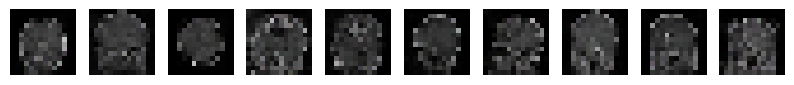

In [ ]:
# Evaluate GAN generated images
def generate_and_display_images(generator, noise_dim, num_images=10):
    noise = np.random.normal(0, 1, (num_images, noise_dim))
    generated_images = generator.predict(noise)
    generated_images = 0.5 * generated_images + 0.5  # Rescale images to [0, 1]

    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.show()

generate_and_display_images(generator, NOISE_DIM)

# GCN (Graph Convolutional Network)


In [ ]:
# Define constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Load the dataset
def load_dataset_from_directory(directory):
    images = []
    labels = []
    class_names = sorted([d.name for d in directory.iterdir() if d.is_dir()])

    for label, class_name in enumerate(class_names):
        class_dir = directory / class_name
        for image_path in class_dir.iterdir():
            if image_path.suffix in ['.png', '.jpg', '.jpeg']:
                image = Image.open(image_path).resize((224, 224)).convert('RGB')
                images.append(np.array(image) / 255.0)
                labels.append(label)

    return np.array(images), np.array(labels), class_names

# Path to the training directory
training_dir = Path('/content/drive/MyDrive/brain_tumour/Training')

# Load the training images and labels
train_images, train_labels, class_names = load_dataset_from_directory(training_dir)

# Convert labels to one-hot encoding
encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = encoder.fit_transform(train_labels.reshape(-1, 1))

# Split the training dataset into training and validation data
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels_one_hot, test_size=0.2, random_state=42)

# Resize images to 14x14
def resize_images(images, size=(14, 14)):
    resized_images = []
    for img in images:
        img = Image.fromarray((img * 255).astype(np.uint8))
        img = img.resize(size, Image.LANCZOS)
        img = np.array(img) / 255.0
        resized_images.append(img)
    return np.array(resized_images)

# Resize the train and validation images
X_train_resized = resize_images(X_train, size=(14, 14))
X_val_resized = resize_images(X_val, size=(14, 14))

In [ ]:
# Custom dataset class for loading images as graphs
class BrainTumorDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].reshape(-1, 3)
        adj = kneighbors_graph(image, n_neighbors=8, include_self=True, mode='connectivity', metric='euclidean')
        adj = csr_matrix(adj)  # Use sparse matrix
        edge_index = torch.tensor(np.array(adj.nonzero()), dtype=torch.long)
        x = torch.tensor(image, dtype=torch.float32)
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        return Data(x=x, edge_index=edge_index, y=y)

# Create datasets
train_dataset = BrainTumorDataset(X_train_resized, y_train)
val_dataset = BrainTumorDataset(X_val_resized, y_val)

# Check the shapes of the graph data
print("Number of training graphs:", len(train_dataset))
print("Number of validation graphs:", len(val_dataset))
print("Sample graph shape (features):", train_dataset[0].x.shape)
print("Sample adjacency matrix shape:", train_dataset[0].edge_index.shape)

Number of training graphs: 4569
Number of validation graphs: 1143
Sample graph shape (features): torch.Size([196, 3])
Sample adjacency matrix shape: torch.Size([2, 1568])


In [ ]:
# GCN Model definition
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, 128)
        self.conv2 = GCNConv(128, 64)
        self.fc = torch.nn.Linear(64, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = torch.mean(x, dim=0)  # Mean aggregation for graph classification
        x = self.fc(x)
        return x  # Return raw scores, no softmax here

# Initialize model, loss, and optimizer
num_features = train_dataset[0].x.shape[1]
num_classes = y_train.shape[1]
model = GCN(num_features, num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()


In [ ]:
# DataLoaders
def create_data_loader(dataset, batch_size=32):
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

train_loader = create_data_loader(train_dataset, batch_size=BATCH_SIZE)
val_loader = create_data_loader(val_dataset, batch_size=BATCH_SIZE)

In [ ]:
# Training function with validation
def train(model, train_loader, val_loader, optimizer, criterion, epochs=20):
    history = {'train_loss': [], 'val_accuracy': []}
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for data in train_loader:
            optimizer.zero_grad()
            out = model(data)
            # Debugging dimensions
            print(f"Model output shape: {out.shape}")
            print(f"Target shape before argmax: {data.y.shape}")

            target = torch.argmax(data.y, dim=0)  # Corrected dimension here
            print(f"Target shape after argmax: {target.shape}")

            loss = criterion(out.unsqueeze(0), target.unsqueeze(0))  # Ensure shapes are aligned
            print(f"Loss: {loss.item()}")

            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        history['train_loss'].append(avg_loss)

        # Validation
        model.eval()
        correct = 0
        with torch.no_grad():
            for data in val_loader:
                out = model(data)
                pred = out.argmax(dim=0)  # Corrected dimension here
                target = torch.argmax(data.y, dim=0)  # Corrected dimension here
                correct += (pred == target).sum().item()
        val_accuracy = correct / len(val_dataset)
        history['val_accuracy'].append(val_accuracy)

        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    return history

# Train the model
history = train(model, train_loader, val_loader, optimizer, criterion, epochs=100)

Streaming output truncated to the last 5000 lines.
Target shape before argmax: torch.Size([128])
Target shape after argmax: torch.Size([])
Loss: 1.3957034349441528
Model output shape: torch.Size([4])
Target shape before argmax: torch.Size([128])
Target shape after argmax: torch.Size([])
Loss: 1.489524006843567
Model output shape: torch.Size([4])
Target shape before argmax: torch.Size([128])
Target shape after argmax: torch.Size([])
Loss: 1.2388814687728882
Model output shape: torch.Size([4])
Target shape before argmax: torch.Size([128])
Target shape after argmax: torch.Size([])
Loss: 1.3870638608932495
Model output shape: torch.Size([4])
Target shape before argmax: torch.Size([128])
Target shape after argmax: torch.Size([])
Loss: 1.4474940299987793
Model output shape: torch.Size([4])
Target shape before argmax: torch.Size([128])
Target shape after argmax: torch.Size([])
Loss: 1.4981635808944702
Model output shape: torch.Size([4])
Target shape before argmax: torch.Size([128])
Target sha

In [ ]:
# Training function with validation
def train(model, train_loader, val_loader, optimizer, criterion, epochs=20):
    history = {'train_loss': [], 'val_accuracy': []}
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for data in train_loader:
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out, torch.argmax(data.y, dim=1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        history['train_loss'].append(avg_loss)

        # Validation
        model.eval()
        correct = 0
        with torch.no_grad():
            for data in val_loader:
                out = model(data)
                pred = out.argmax(dim=0)
                target = torch.argmax(data.y, dim=1)
                correct += (pred == target).sum().item()
        val_accuracy = correct / len(val_dataset)
        history['val_accuracy'].append(val_accuracy)

        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    return history

# Train the model
history = train(model, train_loader, val_loader, optimizer, criterion, epochs=100)

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [ ]:
# Training function
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

In [ ]:
# Validation function
def validate():
    model.eval()
    correct = 0
    with torch.no_grad():
        for data in val_loader:
            output = model(data)
            pred = output.argmax(dim=1)
            correct += (pred == data.y).sum().item()
    return correct / len(val_dataset)


In [ ]:
# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    train_loss = train()
    val_accuracy = validate()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

RuntimeError: size mismatch (got input: [4], target: [128])

In [ ]:
# Custom dataset class for loading images as graphs
class BrainTumorDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def len(self):
        return len(self.images)

    def get(self, idx):
        image = self.images[idx].reshape(-1, 3)
        adj = kneighbors_graph(image, n_neighbors=8, include_self=True, mode='connectivity', metric='euclidean')
        adj = csr_matrix(adj)  # Use sparse matrix
        edge_index = torch.tensor(np.array(adj.nonzero()), dtype=torch.long)
        x = torch.tensor(image, dtype=torch.float32)
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        return Data(x=x, edge_index=edge_index, y=y)

# Create datasets
train_dataset = BrainTumorDataset(X_train_resized, y_train)
val_dataset = BrainTumorDataset(X_val_resized, y_val)

# Check the shapes of the graph data
print("Number of training graphs:", len(train_dataset))
print("Number of validation graphs:", len(val_dataset))
print("Sample graph shape (features):", train_dataset.get(0).x.shape)
print("Sample adjacency matrix shape:", train_dataset.get(0).edge_index.shape)

AttributeError: 'BrainTumorDataset' object has no attribute 'graphs'